In [1]:
import datetime
import itertools
import pickle
import sys

import xarray
import numpy
import matplotlib.pyplot as plt
from tensorflow import keras
import scipy.interpolate
#import xskillscore

In [2]:
# IMD anomalies from 1901 to 2021, with climatology computed over 1950 to 2007
imd_regress_anomalies = xarray.open_dataarray('data/anomalies.nc')

In [3]:
# ERA5 anomalies from 1950 to 2021, with climatology computed over 1993 to 2007
era5_verify_anomalies = xarray.open_dataarray('data/era5_anomalies.nc')
era5_clim = xarray.open_dataarray('data/era5_clim.nc')

In [4]:
# MISO index
miso_dat = era5_verify_anomalies.mean('lon').sel(lat=range(12, 32)).sel(time=(era5_verify_anomalies.time.dt.year <= 2008) & (era5_verify_anomalies.time.dt.year >= 1997) & (era5_verify_anomalies.time.dt.month >= 6) & (era5_verify_anomalies.time.dt.month <= 9)).values

In [567]:
miso_dat2 = numpy.reshape(miso_dat, ((2008-1997+1), 122, 20))

In [568]:
D = 20
n_regress_days = 15
n_days = 122
n_years = 2008 - 1997 + 1
n_samples = n_years*(n_days - n_regress_days)

x_new = numpy.zeros((n_samples, n_regress_days, D))

k = 0
for i in range(n_years):
    for j in range(n_regress_days, n_days):
        x_new[k, :, :] = miso_dat2[i, j-n_regress_days:j, :]
        k += 1

In [569]:
x_new = numpy.reshape(x_new, (n_samples, -1))

In [570]:
C = numpy.cov(x_new.T)

In [571]:
u, s, v = numpy.linalg.svd(C)
eofs = v

In [10]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

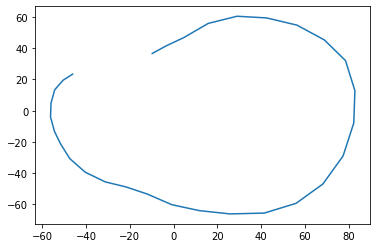

In [58]:
plt.plot(-x_new[-30:, :]@eofs[0, :], -x_new[-30:, :]@eofs[1, :])
#plt.plot(x_new[-122:, :]@eofs[1, :])

In [127]:
plt.psd(x_new[:, :]@eofs[1, :])
#plt.psd(running_mean(x_new[:1000, :]@eofs[:, 3], 15))

NameError: name 'x_new' is not defined

In [4]:
# SEAS5 anomalies from 1981 to 2021, with climatology computed over 1993 to 2007
seas5_anomalies = xarray.open_dataarray('seas5_anomalies_combined.nc').isel(ensemble=range(25))

In [5]:
seas5_clim = xarray.open_dataarray('seas5_clim.nc')

In [5]:
mask = xarray.open_dataset('data/mask.h5')["mask"].values.astype(bool)
mask_lowres = xarray.open_dataset('data/mask_lowres.h5')["mask"].values.astype(bool)

In [20]:
pcs = xarray.open_dataset('data/pcs.h5')["pcs"].values.T
pcs2 = pcs.reshape(107, 275, 2)

pcs_fcst = xarray.open_dataset('pcs_fcst.h5')["pcs"].values.T
pcs_fcst2 = pcs_fcst.reshape(9, 275, 2)

In [97]:
275/30

9.166666666666666

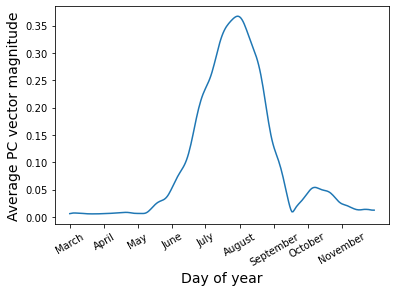

In [15]:
plt.plot(numpy.sqrt(pcs2.mean(axis=0)[:, 0]**2 + pcs2.mean(axis=0)[:, 1]**2))
plt.xticks([0, 31, 61, 92, 122, 153, 184, 214, 245],
           ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'], rotation=30)
plt.xlabel('Day of year', size=14)
plt.ylabel('Average PC vector magnitude', size=14)
plt.savefig("pc_magnitude.pdf")

In [7]:
def forecast_pcs(initial_pcs, lead_time, k, year):
    pcs3 = pcs2[:year - year0, :, :]
    if lead_time == 0:
        return initial_pcs
    pc_dist = numpy.sqrt(numpy.sum((pcs3 - initial_pcs)**2, axis=2))
    idx2 = numpy.unravel_index(numpy.argsort(pc_dist.ravel()), pc_dist.shape)
    idx2 = (idx2[0][:k], idx2[1][:k])
    day_dists = (idx2[1][1:] - idx2[1][:-1])
    year_dists = (idx2[0][1:] - idx2[0][:-1])
    too_close = numpy.where((year_dists == 0) & (day_dists <= 10))[0] + 1
    too_close_mask = numpy.ones(idx2[1].shape, dtype=bool)
    too_close_mask[too_close] = False
    same_year = (idx2[1] + lead_time) < 275
    dist_mask = pc_dist[idx2[0], idx2[1]] <= pc_radius
    dists = pc_dist[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask]]
    pcs_fcst = (pcs3[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask] + lead_time, :]/dists.reshape(-1, 1)).sum(axis=0)/sum(1/dists.reshape(-1, 1))
    return pcs_fcst

In [8]:
nn_model_past = keras.models.load_model("nn_past")
#nn_model_past_era = keras.models.load_model("era_past45_2/")
#nn_model_centered_era = keras.models.load_model("data/nn_centered_era")
nn_model_centered_era = keras.models.load_model("nn_centered_era2")
nn_model_future_era = keras.models.load_model("nn_future_era")

2023-05-15 13:17:40.283783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 13:17:40.285732: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
scaler_past = pickle.load(open('scaler_past', 'rb'))
#scaler_centered_era = pickle.load(open('data/scaler_centered_era', 'rb'))
scaler_centered_era = pickle.load(open('scaler_centered_era2', 'rb'))
scaler_future_era = pickle.load(open('scaler_future_era', 'rb'))

/home/ebach/miniconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
def get_pcs_past(data):                                                              
    return nn_model_past(scaler_past.transform(data)).numpy()

def get_pcs_past_lasso(data):                                                              
    return clf_lasso.predict(scaler_past_lasso.transform(data))

def get_pcs_past_era(data):                                                              
    return nn_model_past_era(data).numpy()

def get_pcs_centered_era(data):                                                              
    return nn_model_centered_era(scaler_centered_era.transform(data)).numpy()

def get_pcs_future_era(data):                                                              
    return nn_model_future_era(scaler_future_era.transform(data)).numpy()

In [11]:
# Constants
day = 1
regress_days = 29
half_regress_days = 14
regress_days_past = 45
n_ens = 25
n_pcs = 2
k = 50
pc_radius = 1.0
year0 = 1901

In [12]:
class Metrics:
    def __init__(self, ensemble, obs, metrics):
        self.results = {}
        for metric_name, metric_function in metrics.items():
            self.results[metric_name] = metric_function(ensemble, obs)

In [13]:
def rmse(ensemble, obs):
    ens_mean = ensemble.mean(['ensemble'])
    return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))

def rmse2(ensemble, obs):
    ens_mean = ensemble.mean(axis=0)
    return numpy.sqrt(numpy.nanmean((ens_mean - obs)**2))

def rmse_region(ensemble, obs, region):
    ens_mean = ensemble.mean(['ensemble'])
    return numpy.sqrt(numpy.nanmean((ens_mean.values[mask_lowres][state_data["st_nm"] == region]
                                     - obs[mask_lowres][state_data["st_nm"] == region])**2))

def rmse_india(ensemble, obs):
    ens_mean = ensemble.mean(['ensemble'])
    return numpy.sqrt(numpy.nanmean((ens_mean.values[mask_lowres] - obs[mask_lowres])**2))

def rmse_india2(ensemble, obs):
    ens_mean = ensemble.mean(axis=0)
    return numpy.sqrt(numpy.nanmean((ens_mean[mask_lowres] - obs[mask_lowres])**2))

def crps(ensemble, obs):
    return xskillscore.crps_ensemble(obs, ensemble, member_dim='ensemble').values

def mean_prec(ensemble, obs):
    return ensemble.mean().values.item()

def mean_prec_india(ensemble, obs):
    return ensemble.mean("ensemble").values[mask_lowres].mean()

def corr(ensemble, obs):
    ens_mean = ensemble.mean(['ensemble'])
    return numpy.corrcoef(ens_mean.values.ravel(), obs.ravel())[0, 1]

def corr2(ensemble, obs):
    ens_mean = ensemble.mean(axis=0)
    return numpy.corrcoef(ens_mean.ravel(), obs.ravel())[0, 1]

def diff_map(ensemble, obs):
    ens_mean = ensemble.mean(['ensemble'])
    return ens_mean.values - obs

def corr_india(ensemble, obs):
    ens_mean = ensemble.mean(['ensemble'])
    return numpy.corrcoef(ens_mean.values[mask_lowres].ravel(), obs[mask_lowres].ravel())[0, 1]

def corr_india2(ensemble, obs):
    ens_mean = ensemble.mean(axis=0)
    return numpy.corrcoef(ens_mean[mask_lowres].ravel(), obs[mask_lowres].ravel())[0, 1]

metrics = {'rmse': rmse, 'rmse_india': rmse_india, 'crps': crps, 'mean_prec': mean_prec, 'mean_prec_india': mean_prec_india, 'corr': corr,
           'corr_india': corr_india, 'diff_map': diff_map}

In [129]:
len(range(-regress_days + 1, 1))

29

In [40]:
def run_enoc(year, month, lead_time, m_p, compute_mp=True, mp_metric=rmse):
    def opt(ordered_idx, test_ens, i):
        best_idx = ordered_idx[:i]
        return test_ens.sel(ensemble=best_idx)

    def rand(test_ens, i):
        rand_idx = numpy.arange(n_ens)
        numpy.random.shuffle(rand_idx)
        rand_idx = rand_idx[:i]
        return test_ens.sel(ensemble=rand_idx)
    
    initial_date = datetime.datetime(year=year, month=month, day=day)
    
    if (m_p < n_ens) or compute_mp:
        #initial_data = numpy.hstack([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values for i in range(-regress_days_past + 1, 1)])
        initial_data = numpy.hstack([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-regress_days + 1, 1)])
        initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

        date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
        #initial_pc_true = pcs2[year - 1901, date_days, :]

        pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k, year=year)

        pcs_model = numpy.zeros((n_ens, n_pcs))

        for ens in range(n_ens):
            if lead_time <= half_regress_days:
                data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time, lead_time + regress_days)]
                pcs_model[ens, :] = numpy.array(get_pcs_future_era(numpy.hstack(data_ens).reshape(1, -1)))
            else:
                data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time - half_regress_days, lead_time + half_regress_days + 1)]
                pcs_model[ens, :] = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

        if year >= 2008:
            true_pc = pcs_fcst2[year - 2008, date_days + lead_time, :]

        pc_dists = numpy.mean((pcs_model - pcs_fcst)**2, axis=1)

        if not any(numpy.isnan(pc_dists)):
            ordered_idx = numpy.argsort(pc_dists)
            best_idx = ordered_idx[:m_p]
        else:
            raise Exception
    else:
        best_idx = range(n_ens)

    enoc_ens = seas5_anomalies.sel(ensemble=best_idx, initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")
    mean_ens = seas5_anomalies.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

    #enoc_pred = enoc_ens.mean(["ensemble"])
    #mean_pred = mean_ens.mean(["ensemble"])

    obs_state_era = numpy.mean([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    obs_state_imd = numpy.mean([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    
    if compute_mp:
        test_ens = seas5_anomalies.sel(initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

        opt_mp = [mp_metric(opt(ordered_idx, test_ens, i), obs_state_era) for i in range(1, n_ens + 1)]
        rand_mp = [mp_metric(rand(test_ens, i), obs_state_era) for i in range(1, n_ens + 1)]

    #err_corr = rmse(enoc_ens, obs_state_era)
    #err_uncorr = rmse(mean_ens, obs_state_era)
    #err_uncorr = numpy.sqrt(numpy.nanmean((numpy.zeros(obs_state_era.shape) - obs_state_era)**2))

    print("Year: ", year, "Month: ", month, "Lead time: ", lead_time)

    #fcst_pcs.append(pcs_fcst)
    #true_pcs.append(true_pc)
    #pred_corr.append(enoc_pred)
    #pred_uncorr.append(mean_pred)
    
    return {'ens_corr': enoc_ens, 'ens_uncorr': mean_ens, 'obs_state': obs_state_era, 'obs_state_imd': obs_state_imd, 'opt_mp': opt_mp if compute_mp else None,
            'rand_mp': rand_mp if compute_mp else None, 'pcs': (true_pc, pcs_fcst, pcs_model) if year >= 2008 else None}

    #errs_corr.append(err_corr)
    #errs_uncorr.append(err_uncorr)
    #initial_pcs.append(initial_pc)
    #initial_pcs_true.append(initial_pc_true)
    #ens_dists.append(pc_dists)

In [9]:
def run_enoc_dist(year, month, lead_time, opt_dist, compute_mp=True, mp_metric=rmse):
#year=2008
#month=8
#lead_time=15
#opt_dist=10.0
#compute_mp=True
#mp_metric=rmse

#if True:
    def opt(dists, test_ens, d):
        return test_ens.sel(ensemble=numpy.where(dists <= d)[0])

    initial_date = datetime.datetime(year=year, month=month, day=day)
    
    if compute_mp:
        #initial_data = numpy.hstack([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values for i in range(-regress_days_past + 1, 1)])
        initial_data = numpy.hstack([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-regress_days + 1, 1)])
        initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

        date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
        #initial_pc_true = pcs2[year - 1901, date_days, :]

        pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k, year=year)

        pcs_model = numpy.zeros((n_ens, n_pcs))

        for ens in range(n_ens):
            if lead_time <= half_regress_days:
                data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time, lead_time + regress_days)]
                pcs_model[ens, :] = numpy.array(get_pcs_future_era(numpy.hstack(data_ens).reshape(1, -1)))
            else:
                data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time - half_regress_days, lead_time + half_regress_days + 1)]
                pcs_model[ens, :] = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

        #true_pc = pcs2[year - 1901, date_days + lead_time, :]
        pc_dists = numpy.mean((pcs_model - pcs_fcst)**2, axis=1)

        if not any(numpy.isnan(pc_dists)):
            best_idx = numpy.where(pc_dists <= opt_dist)[0]
            #ordered_idx = numpy.argsort(pc_dists)
            #best_idx = ordered_idx[:m_p]
        else:
            raise Exception
    else:
        best_idx = range(n_ens)

    enoc_ens = seas5_anomalies.sel(ensemble=best_idx, initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")
    mean_ens = seas5_anomalies.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

    #enoc_pred = enoc_ens.mean(["ensemble"])
    #mean_pred = mean_ens.mean(["ensemble"])

    obs_state_era = numpy.mean([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)

    if compute_mp:
        test_ens = seas5_anomalies.sel(initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

        opt_dist = [mp_metric(opt(pc_dists, test_ens, d), obs_state_era) for d in numpy.arange(1.0, 11.0, 1.0)]

    #err_corr = rmse(enoc_ens, obs_state_era)
    #err_uncorr = rmse(mean_ens, obs_state_era)
    #err_uncorr = numpy.sqrt(numpy.nanmean((numpy.zeros(obs_state_era.shape) - obs_state_era)**2))

    print("Year: ", year, "Month: ", month, "Lead time: ", lead_time)

    #fcst_pcs.append(pcs_fcst)
    #true_pcs.append(true_pc)
    #pred_corr.append(enoc_pred)
    #pred_uncorr.append(mean_pred)
    
    return {'ens_corr': enoc_ens, 'ens_uncorr': mean_ens, 'obs_state': obs_state_era, 'opt_dist': opt_dist if compute_mp else None}

    #errs_corr.append(err_corr)
    #errs_uncorr.append(err_uncorr)
    #initial_pcs.append(initial_pc)
    #initial_pcs_true.append(initial_pc_true)
    #ens_dists.append(pc_dists)

In [15]:
#era5_masked = era5_verify_anomalies.values[:, mask_lowres]

In [16]:
#seas5_masked = seas5_anomalies.values[:, :, :, mask_lowres]

In [15]:
regions = ['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [6]:
def run_enoc_region(year, month, lead_time, m_p, compute_mp=True, mp_metric=rmse_region):
    def opt(ordered_idx, test_ens, i):
        best_idx = ordered_idx[:i]
        return test_ens.sel(ensemble=best_idx)

    def rand(test_ens, i):
        rand_idx = numpy.arange(n_ens)
        numpy.random.shuffle(rand_idx)
        rand_idx = rand_idx[:i]
        return test_ens.sel(ensemble=rand_idx)
    
    initial_date = datetime.datetime(year=year, month=month, day=day)
    
    #initial_data = numpy.hstack([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values for i in range(-regress_days_past + 1, 1)])
    initial_data = numpy.hstack([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-regress_days + 1, 1)])
    initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    #initial_pc_true = pcs2[year - 1901, date_days, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    pcs_model = numpy.zeros((n_ens, n_pcs))

    for ens in range(n_ens):
        if lead_time <= half_regress_days:
            data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time, lead_time + regress_days)]
            pcs_model[ens, :] = numpy.array(get_pcs_future_era(numpy.hstack(data_ens).reshape(1, -1)))
        else:
            data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time - half_regress_days, lead_time + half_regress_days + 1)]
            pcs_model[ens, :] = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

    #true_pc = pcs2[year - 1901, date_days + lead_time, :]
    pc_dists = numpy.mean((pcs_model - pcs_fcst)**2, axis=1)

    obs_state_era = numpy.mean([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    
    mean_ens = seas5_anomalies.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

    enoc_ens = {}
    errs_corr = dict((region, []) for region in regions)
    errs_uncorr = dict((region, []) for region in regions)
    for region in regions:
        if not any(numpy.isnan(pc_dists)):
            ordered_idx = numpy.argsort(pc_dists)
            best_idx = ordered_idx[:m_p[region]]
        else:
            raise Exception
        enoc_ens[region] = seas5_anomalies.sel(ensemble=best_idx, initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")
        test_ens = seas5_anomalies.sel(initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")
        errs_corr[region].append(mp_metric(opt(best_idx, test_ens, m_p[region]), obs_state_era, region))
        errs_uncorr[region].append(mp_metric(mean_ens, obs_state_era, region))
            
    #enoc_pred = enoc_ens.mean(["ensemble"])
    #mean_pred = mean_ens.mean(["ensemble"])
    opt_mp = {}
    if compute_mp:
        test_ens = seas5_anomalies.sel(initial_time=initial_date).isel(forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean("forecast_time")

        for region in regions:
            opt_mp[region] = [mp_metric(opt(ordered_idx, test_ens, i), obs_state_era, region) for i in range(1, n_ens + 1)]
            #rand_mp = [mp_metric(rand(test_ens, i), obs_state_era) for i in range(1, n_ens + 1)]

    #err_corr = rmse(enoc_ens, obs_state_era)
    #err_uncorr = rmse(mean_ens, obs_state_era)
    #err_uncorr = numpy.sqrt(numpy.nanmean((numpy.zeros(obs_state_era.shape) - obs_state_era)**2))

    print("Year: ", year, "Month: ", month, "Lead time: ", lead_time)

    #fcst_pcs.append(pcs_fcst)
    #true_pcs.append(true_pc)
    #pred_corr.append(enoc_pred)
    #pred_uncorr.append(mean_pred)
    
    return {'ens_corr': enoc_ens, 'ens_uncorr': mean_ens, 'obs_state': obs_state_era, 'opt_mp': opt_mp if compute_mp else None,
            'errs_corr': errs_corr, 'errs_uncorr': errs_uncorr}
            #'rand_mp': rand_mp if compute_mp else None}

    #errs_corr.append(err_corr)
    #errs_uncorr.append(err_uncorr)
    #initial_pcs.append(initial_pc)
    #initial_pcs_true.append(initial_pc_true)
    #ens_dists.append(pc_dists)

NameError: name 'rmse_region' is not defined

In [39]:
# Single

m_p = 25

opt_mps = []
rand_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

l_average_days = 7
r_average_days = 7

all_res_corr = {}
all_res_uncorr = {}
all_res_obs = {}
all_res_obs_imd = {}
all_res_clim = {}

for month in range(7, 10):
    all_res_corr[month] = {}
    all_res_uncorr[month] = {}
    all_res_obs[month] = {}
    all_res_obs_imd[month] = {}
    all_res_clim[month] = {}

    for lead_time in range(0, 45):
        all_res_corr[month][lead_time] = []
        all_res_uncorr[month][lead_time] = []
        all_res_obs[month][lead_time] = []
        all_res_obs_imd[month][lead_time] = []
        all_res_clim[month][lead_time] = []

        opt_mps = []

        for year in range(1993, 2008):
            res = run_enoc(year, month, lead_time, m_p, mp_metric=rmse)
            opt_mps.append(res['opt_mp'])
            rand_mps.append(res['rand_mp'])

        m_p = numpy.argmin(numpy.mean(opt_mps, axis=0)) + 1
        #pval = scipy.stats.ttest_ind([opt_mps[i][m_p-1] for i in range(15)], [opt_mps[i][-1] for i in range(15)]).pvalue
        #if pval > 1.0:
        #    if m_p < 25:
        #        print('failed significance test', pval)
        #    m_p = 25
        #print(m_p, pval)

        #errs_corr = []
        #errs_uncorr = []
        for year in range(2008, 2017):
            res = run_enoc(year, month, lead_time, m_p, compute_mp=True, mp_metric=rmse)
            #corr_metrics = Metrics(res['ens_corr'], res['obs_state'], metrics=metrics).results
            #uncorr_metrics = Metrics(res['ens_uncorr'], res['obs_state'], metrics=metrics).results
            #obs_metrics = Metrics(xarray.DataArray([res['obs_state']]).rename(dim_0="ensemble"), res['obs_state'], metrics=metrics).results
            #clim_metrics = Metrics(res['ens_uncorr'].sel(ensemble=range(1))*0, res['obs_state'], metrics=metrics).results
            #opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])
            #print(corr_metrics['rmse']/uncorr_metrics['rmse'])

            all_res_corr[month][lead_time].append(res['ens_corr'])
            all_res_uncorr[month][lead_time].append(res['ens_uncorr'])
            all_res_obs[month][lead_time].append(res['obs_state'])
            all_res_obs_imd[month][lead_time].append(res['obs_state_imd'])
            #all_res_clim[month][lead_time].append(res['ens_corr'])

        #all_errs_corr.append(errs_corr)
        #all_errs_uncorr.append(errs_uncorr)

#pickle.dump(all_res_obs, open("all_res_obs", "wb"))
#pickle.dump(all_res_corr, open("all_res_corr", "wb"))
#pickle.dump(all_res_uncorr, open("all_res_uncorr", "wb"))

Year:  2008 Month:  7 Lead time:  0
Year:  2009 Month:  7 Lead time:  0
Year:  2010 Month:  7 Lead time:  0
Year:  2011 Month:  7 Lead time:  0
Year:  2012 Month:  7 Lead time:  0
Year:  2013 Month:  7 Lead time:  0
Year:  2014 Month:  7 Lead time:  0
Year:  2015 Month:  7 Lead time:  0
Year:  2016 Month:  7 Lead time:  0
Year:  2008 Month:  7 Lead time:  1
Year:  2009 Month:  7 Lead time:  1
Year:  2010 Month:  7 Lead time:  1
Year:  2011 Month:  7 Lead time:  1
Year:  2012 Month:  7 Lead time:  1
Year:  2013 Month:  7 Lead time:  1
Year:  2014 Month:  7 Lead time:  1
Year:  2015 Month:  7 Lead time:  1
Year:  2016 Month:  7 Lead time:  1
Year:  2008 Month:  7 Lead time:  2
Year:  2009 Month:  7 Lead time:  2
Year:  2010 Month:  7 Lead time:  2
Year:  2011 Month:  7 Lead time:  2
Year:  2012 Month:  7 Lead time:  2
Year:  2013 Month:  7 Lead time:  2
Year:  2014 Month:  7 Lead time:  2
Year:  2015 Month:  7 Lead time:  2
Year:  2016 Month:  7 Lead time:  2
Year:  2008 Month:  7 Lead t

Year:  2013 Month:  7 Lead time:  25
Year:  2014 Month:  7 Lead time:  25
Year:  2015 Month:  7 Lead time:  25
Year:  2016 Month:  7 Lead time:  25
Year:  2008 Month:  7 Lead time:  26
Year:  2009 Month:  7 Lead time:  26
Year:  2010 Month:  7 Lead time:  26
Year:  2011 Month:  7 Lead time:  26
Year:  2012 Month:  7 Lead time:  26
Year:  2013 Month:  7 Lead time:  26
Year:  2014 Month:  7 Lead time:  26
Year:  2015 Month:  7 Lead time:  26
Year:  2016 Month:  7 Lead time:  26
Year:  2008 Month:  7 Lead time:  27
Year:  2009 Month:  7 Lead time:  27
Year:  2010 Month:  7 Lead time:  27
Year:  2011 Month:  7 Lead time:  27
Year:  2012 Month:  7 Lead time:  27
Year:  2013 Month:  7 Lead time:  27
Year:  2014 Month:  7 Lead time:  27
Year:  2015 Month:  7 Lead time:  27
Year:  2016 Month:  7 Lead time:  27
Year:  2008 Month:  7 Lead time:  28
Year:  2009 Month:  7 Lead time:  28
Year:  2010 Month:  7 Lead time:  28
Year:  2011 Month:  7 Lead time:  28
Year:  2012 Month:  7 Lead time:  28
Y

Year:  2011 Month:  8 Lead time:  6
Year:  2012 Month:  8 Lead time:  6
Year:  2013 Month:  8 Lead time:  6
Year:  2014 Month:  8 Lead time:  6
Year:  2015 Month:  8 Lead time:  6
Year:  2016 Month:  8 Lead time:  6
Year:  2008 Month:  8 Lead time:  7
Year:  2009 Month:  8 Lead time:  7
Year:  2010 Month:  8 Lead time:  7
Year:  2011 Month:  8 Lead time:  7
Year:  2012 Month:  8 Lead time:  7
Year:  2013 Month:  8 Lead time:  7
Year:  2014 Month:  8 Lead time:  7
Year:  2015 Month:  8 Lead time:  7
Year:  2016 Month:  8 Lead time:  7
Year:  2008 Month:  8 Lead time:  8
Year:  2009 Month:  8 Lead time:  8
Year:  2010 Month:  8 Lead time:  8
Year:  2011 Month:  8 Lead time:  8
Year:  2012 Month:  8 Lead time:  8
Year:  2013 Month:  8 Lead time:  8
Year:  2014 Month:  8 Lead time:  8
Year:  2015 Month:  8 Lead time:  8
Year:  2016 Month:  8 Lead time:  8
Year:  2008 Month:  8 Lead time:  9
Year:  2009 Month:  8 Lead time:  9
Year:  2010 Month:  8 Lead time:  9
Year:  2011 Month:  8 Lead t

Year:  2010 Month:  8 Lead time:  32
Year:  2011 Month:  8 Lead time:  32
Year:  2012 Month:  8 Lead time:  32
Year:  2013 Month:  8 Lead time:  32
Year:  2014 Month:  8 Lead time:  32
Year:  2015 Month:  8 Lead time:  32
Year:  2016 Month:  8 Lead time:  32
Year:  2008 Month:  8 Lead time:  33
Year:  2009 Month:  8 Lead time:  33
Year:  2010 Month:  8 Lead time:  33
Year:  2011 Month:  8 Lead time:  33
Year:  2012 Month:  8 Lead time:  33
Year:  2013 Month:  8 Lead time:  33
Year:  2014 Month:  8 Lead time:  33
Year:  2015 Month:  8 Lead time:  33
Year:  2016 Month:  8 Lead time:  33
Year:  2008 Month:  8 Lead time:  34
Year:  2009 Month:  8 Lead time:  34
Year:  2010 Month:  8 Lead time:  34
Year:  2011 Month:  8 Lead time:  34
Year:  2012 Month:  8 Lead time:  34
Year:  2013 Month:  8 Lead time:  34
Year:  2014 Month:  8 Lead time:  34
Year:  2015 Month:  8 Lead time:  34
Year:  2016 Month:  8 Lead time:  34
Year:  2008 Month:  8 Lead time:  35
Year:  2009 Month:  8 Lead time:  35
Y

Year:  2008 Month:  9 Lead time:  13
Year:  2009 Month:  9 Lead time:  13
Year:  2010 Month:  9 Lead time:  13
Year:  2011 Month:  9 Lead time:  13
Year:  2012 Month:  9 Lead time:  13
Year:  2013 Month:  9 Lead time:  13
Year:  2014 Month:  9 Lead time:  13
Year:  2015 Month:  9 Lead time:  13
Year:  2016 Month:  9 Lead time:  13
Year:  2008 Month:  9 Lead time:  14
Year:  2009 Month:  9 Lead time:  14
Year:  2010 Month:  9 Lead time:  14
Year:  2011 Month:  9 Lead time:  14
Year:  2012 Month:  9 Lead time:  14
Year:  2013 Month:  9 Lead time:  14
Year:  2014 Month:  9 Lead time:  14
Year:  2015 Month:  9 Lead time:  14
Year:  2016 Month:  9 Lead time:  14
Year:  2008 Month:  9 Lead time:  15
Year:  2009 Month:  9 Lead time:  15
Year:  2010 Month:  9 Lead time:  15
Year:  2011 Month:  9 Lead time:  15
Year:  2012 Month:  9 Lead time:  15
Year:  2013 Month:  9 Lead time:  15
Year:  2014 Month:  9 Lead time:  15
Year:  2015 Month:  9 Lead time:  15
Year:  2016 Month:  9 Lead time:  15
Y

Year:  2015 Month:  9 Lead time:  37
Year:  2016 Month:  9 Lead time:  37
Year:  2008 Month:  9 Lead time:  38
Year:  2009 Month:  9 Lead time:  38
Year:  2010 Month:  9 Lead time:  38
Year:  2011 Month:  9 Lead time:  38
Year:  2012 Month:  9 Lead time:  38
Year:  2013 Month:  9 Lead time:  38
Year:  2014 Month:  9 Lead time:  38
Year:  2015 Month:  9 Lead time:  38
Year:  2016 Month:  9 Lead time:  38
Year:  2008 Month:  9 Lead time:  39
Year:  2009 Month:  9 Lead time:  39
Year:  2010 Month:  9 Lead time:  39
Year:  2011 Month:  9 Lead time:  39
Year:  2012 Month:  9 Lead time:  39
Year:  2013 Month:  9 Lead time:  39
Year:  2014 Month:  9 Lead time:  39
Year:  2015 Month:  9 Lead time:  39
Year:  2016 Month:  9 Lead time:  39
Year:  2008 Month:  9 Lead time:  40
Year:  2009 Month:  9 Lead time:  40
Year:  2010 Month:  9 Lead time:  40
Year:  2011 Month:  9 Lead time:  40
Year:  2012 Month:  9 Lead time:  40
Year:  2013 Month:  9 Lead time:  40
Year:  2014 Month:  9 Lead time:  40
Y

In [177]:
# MISO index

m_p = 25

opt_mps = []
rand_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

all_res_corr = {}
all_res_uncorr = {}
all_res_obs = {}
all_res_clim = {}
all_pcs = {}

for month in range(7, 10):
    all_res_corr[month] = {}
    all_res_uncorr[month] = {}
    all_res_obs[month] = {}
    all_res_clim[month] = {}
    all_pcs[month] = {}

    for lead_time in range(0, 45):
        all_res_corr[month][lead_time] = []
        all_res_uncorr[month][lead_time] = []
        all_res_obs[month][lead_time] = []
        all_res_clim[month][lead_time] = []
        all_pcs[month][lead_time] = []

        opt_mps = []

        l_average_days = 7
        r_average_days = 7
        
        for year in range(1993, 2008):
            res = run_enoc(year, month, lead_time, m_p, mp_metric=rmse)
            opt_mps.append(res['opt_mp'])
            rand_mps.append(res['rand_mp'])

        m_p = numpy.argmin(numpy.mean(opt_mps, axis=0)) + 1

        l_average_days = 0
        r_average_days = 0
        
        #errs_corr = []
        #errs_uncorr = []
        for year in range(2008, 2017):
            res = run_enoc(year, month, lead_time, m_p, compute_mp=True, mp_metric=rmse)
            #corr_metrics = Metrics(res['ens_corr'], res['obs_state'], metrics=metrics).results
            #uncorr_metrics = Metrics(res['ens_uncorr'], res['obs_state'], metrics=metrics).results
            #obs_metrics = Metrics(xarray.DataArray([res['obs_state']]).rename(dim_0="ensemble"), res['obs_state'], metrics=metrics).results
            #clim_metrics = Metrics(res['ens_uncorr'].sel(ensemble=range(1))*0, res['obs_state'], metrics=metrics).results
            #opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])
            #print(corr_metrics['rmse']/uncorr_metrics['rmse'])

            all_res_corr[month][lead_time].append(res['ens_corr'])
            all_res_uncorr[month][lead_time].append(res['ens_uncorr'])
            all_res_obs[month][lead_time].append(res['obs_state'])
            all_pcs[month][lead_time].append(res['pcs'])
            #all_res_clim[month][lead_time].append(res['ens_corr'])

        #all_errs_corr.append(errs_corr)
        #all_errs_uncorr.append(errs_uncorr)

#pickle.dump(all_res_obs, open("all_res_obs", "wb"))
#pickle.dump(all_res_corr, open("all_res_corr", "wb"))
#pickle.dump(all_res_uncorr, open("all_res_uncorr", "wb"))

Year:  1993 Month:  7 Lead time:  0
Year:  1994 Month:  7 Lead time:  0
Year:  1995 Month:  7 Lead time:  0
Year:  1996 Month:  7 Lead time:  0
Year:  1997 Month:  7 Lead time:  0
Year:  1998 Month:  7 Lead time:  0
Year:  1999 Month:  7 Lead time:  0
Year:  2000 Month:  7 Lead time:  0
Year:  2001 Month:  7 Lead time:  0
Year:  2002 Month:  7 Lead time:  0
Year:  2003 Month:  7 Lead time:  0
Year:  2004 Month:  7 Lead time:  0
Year:  2005 Month:  7 Lead time:  0
Year:  2006 Month:  7 Lead time:  0
Year:  2007 Month:  7 Lead time:  0
Year:  2008 Month:  7 Lead time:  0
Year:  2009 Month:  7 Lead time:  0
Year:  2010 Month:  7 Lead time:  0
Year:  2011 Month:  7 Lead time:  0
Year:  2012 Month:  7 Lead time:  0
Year:  2013 Month:  7 Lead time:  0
Year:  2014 Month:  7 Lead time:  0
Year:  2015 Month:  7 Lead time:  0
Year:  2016 Month:  7 Lead time:  0
Year:  1993 Month:  7 Lead time:  1
Year:  1994 Month:  7 Lead time:  1
Year:  1995 Month:  7 Lead time:  1
Year:  1996 Month:  7 Lead t

Year:  2005 Month:  7 Lead time:  9
Year:  2006 Month:  7 Lead time:  9
Year:  2007 Month:  7 Lead time:  9
Year:  2008 Month:  7 Lead time:  9
Year:  2009 Month:  7 Lead time:  9
Year:  2010 Month:  7 Lead time:  9
Year:  2011 Month:  7 Lead time:  9
Year:  2012 Month:  7 Lead time:  9
Year:  2013 Month:  7 Lead time:  9
Year:  2014 Month:  7 Lead time:  9
Year:  2015 Month:  7 Lead time:  9
Year:  2016 Month:  7 Lead time:  9
Year:  1993 Month:  7 Lead time:  10
Year:  1994 Month:  7 Lead time:  10
Year:  1995 Month:  7 Lead time:  10
Year:  1996 Month:  7 Lead time:  10
Year:  1997 Month:  7 Lead time:  10
Year:  1998 Month:  7 Lead time:  10
Year:  1999 Month:  7 Lead time:  10
Year:  2000 Month:  7 Lead time:  10
Year:  2001 Month:  7 Lead time:  10
Year:  2002 Month:  7 Lead time:  10
Year:  2003 Month:  7 Lead time:  10
Year:  2004 Month:  7 Lead time:  10
Year:  2005 Month:  7 Lead time:  10
Year:  2006 Month:  7 Lead time:  10
Year:  2007 Month:  7 Lead time:  10
Year:  2008 M

Year:  2011 Month:  7 Lead time:  18
Year:  2012 Month:  7 Lead time:  18
Year:  2013 Month:  7 Lead time:  18
Year:  2014 Month:  7 Lead time:  18
Year:  2015 Month:  7 Lead time:  18
Year:  2016 Month:  7 Lead time:  18
Year:  1993 Month:  7 Lead time:  19
Year:  1994 Month:  7 Lead time:  19
Year:  1995 Month:  7 Lead time:  19
Year:  1996 Month:  7 Lead time:  19
Year:  1997 Month:  7 Lead time:  19
Year:  1998 Month:  7 Lead time:  19
Year:  1999 Month:  7 Lead time:  19
Year:  2000 Month:  7 Lead time:  19
Year:  2001 Month:  7 Lead time:  19
Year:  2002 Month:  7 Lead time:  19
Year:  2003 Month:  7 Lead time:  19
Year:  2004 Month:  7 Lead time:  19
Year:  2005 Month:  7 Lead time:  19
Year:  2006 Month:  7 Lead time:  19
Year:  2007 Month:  7 Lead time:  19
Year:  2008 Month:  7 Lead time:  19
Year:  2009 Month:  7 Lead time:  19
Year:  2010 Month:  7 Lead time:  19
Year:  2011 Month:  7 Lead time:  19
Year:  2012 Month:  7 Lead time:  19
Year:  2013 Month:  7 Lead time:  19
Y

Year:  1993 Month:  7 Lead time:  28
Year:  1994 Month:  7 Lead time:  28
Year:  1995 Month:  7 Lead time:  28
Year:  1996 Month:  7 Lead time:  28
Year:  1997 Month:  7 Lead time:  28
Year:  1998 Month:  7 Lead time:  28
Year:  1999 Month:  7 Lead time:  28
Year:  2000 Month:  7 Lead time:  28
Year:  2001 Month:  7 Lead time:  28
Year:  2002 Month:  7 Lead time:  28
Year:  2003 Month:  7 Lead time:  28
Year:  2004 Month:  7 Lead time:  28
Year:  2005 Month:  7 Lead time:  28
Year:  2006 Month:  7 Lead time:  28
Year:  2007 Month:  7 Lead time:  28
Year:  2008 Month:  7 Lead time:  28
Year:  2009 Month:  7 Lead time:  28
Year:  2010 Month:  7 Lead time:  28
Year:  2011 Month:  7 Lead time:  28
Year:  2012 Month:  7 Lead time:  28
Year:  2013 Month:  7 Lead time:  28
Year:  2014 Month:  7 Lead time:  28
Year:  2015 Month:  7 Lead time:  28
Year:  2016 Month:  7 Lead time:  28
Year:  1993 Month:  7 Lead time:  29
Year:  1994 Month:  7 Lead time:  29
Year:  1995 Month:  7 Lead time:  29
Y

Year:  1999 Month:  7 Lead time:  37
Year:  2000 Month:  7 Lead time:  37
Year:  2001 Month:  7 Lead time:  37
Year:  2002 Month:  7 Lead time:  37
Year:  2003 Month:  7 Lead time:  37
Year:  2004 Month:  7 Lead time:  37
Year:  2005 Month:  7 Lead time:  37
Year:  2006 Month:  7 Lead time:  37
Year:  2007 Month:  7 Lead time:  37
Year:  2008 Month:  7 Lead time:  37
Year:  2009 Month:  7 Lead time:  37
Year:  2010 Month:  7 Lead time:  37
Year:  2011 Month:  7 Lead time:  37
Year:  2012 Month:  7 Lead time:  37
Year:  2013 Month:  7 Lead time:  37
Year:  2014 Month:  7 Lead time:  37
Year:  2015 Month:  7 Lead time:  37
Year:  2016 Month:  7 Lead time:  37
Year:  1993 Month:  7 Lead time:  38
Year:  1994 Month:  7 Lead time:  38
Year:  1995 Month:  7 Lead time:  38
Year:  1996 Month:  7 Lead time:  38
Year:  1997 Month:  7 Lead time:  38
Year:  1998 Month:  7 Lead time:  38
Year:  1999 Month:  7 Lead time:  38
Year:  2000 Month:  7 Lead time:  38
Year:  2001 Month:  7 Lead time:  38
Y

Year:  2006 Month:  8 Lead time:  1
Year:  2007 Month:  8 Lead time:  1
Year:  2008 Month:  8 Lead time:  1
Year:  2009 Month:  8 Lead time:  1
Year:  2010 Month:  8 Lead time:  1
Year:  2011 Month:  8 Lead time:  1
Year:  2012 Month:  8 Lead time:  1
Year:  2013 Month:  8 Lead time:  1
Year:  2014 Month:  8 Lead time:  1
Year:  2015 Month:  8 Lead time:  1
Year:  2016 Month:  8 Lead time:  1
Year:  1993 Month:  8 Lead time:  2
Year:  1994 Month:  8 Lead time:  2
Year:  1995 Month:  8 Lead time:  2
Year:  1996 Month:  8 Lead time:  2
Year:  1997 Month:  8 Lead time:  2
Year:  1998 Month:  8 Lead time:  2
Year:  1999 Month:  8 Lead time:  2
Year:  2000 Month:  8 Lead time:  2
Year:  2001 Month:  8 Lead time:  2
Year:  2002 Month:  8 Lead time:  2
Year:  2003 Month:  8 Lead time:  2
Year:  2004 Month:  8 Lead time:  2
Year:  2005 Month:  8 Lead time:  2
Year:  2006 Month:  8 Lead time:  2
Year:  2007 Month:  8 Lead time:  2
Year:  2008 Month:  8 Lead time:  2
Year:  2009 Month:  8 Lead t

Year:  1993 Month:  8 Lead time:  11
Year:  1994 Month:  8 Lead time:  11
Year:  1995 Month:  8 Lead time:  11
Year:  1996 Month:  8 Lead time:  11
Year:  1997 Month:  8 Lead time:  11
Year:  1998 Month:  8 Lead time:  11
Year:  1999 Month:  8 Lead time:  11
Year:  2000 Month:  8 Lead time:  11
Year:  2001 Month:  8 Lead time:  11
Year:  2002 Month:  8 Lead time:  11
Year:  2003 Month:  8 Lead time:  11
Year:  2004 Month:  8 Lead time:  11
Year:  2005 Month:  8 Lead time:  11
Year:  2006 Month:  8 Lead time:  11
Year:  2007 Month:  8 Lead time:  11
Year:  2008 Month:  8 Lead time:  11
Year:  2009 Month:  8 Lead time:  11
Year:  2010 Month:  8 Lead time:  11
Year:  2011 Month:  8 Lead time:  11
Year:  2012 Month:  8 Lead time:  11
Year:  2013 Month:  8 Lead time:  11
Year:  2014 Month:  8 Lead time:  11
Year:  2015 Month:  8 Lead time:  11
Year:  2016 Month:  8 Lead time:  11
Year:  1993 Month:  8 Lead time:  12
Year:  1994 Month:  8 Lead time:  12
Year:  1995 Month:  8 Lead time:  12
Y

Year:  1999 Month:  8 Lead time:  20
Year:  2000 Month:  8 Lead time:  20
Year:  2001 Month:  8 Lead time:  20
Year:  2002 Month:  8 Lead time:  20
Year:  2003 Month:  8 Lead time:  20
Year:  2004 Month:  8 Lead time:  20
Year:  2005 Month:  8 Lead time:  20
Year:  2006 Month:  8 Lead time:  20
Year:  2007 Month:  8 Lead time:  20
Year:  2008 Month:  8 Lead time:  20
Year:  2009 Month:  8 Lead time:  20
Year:  2010 Month:  8 Lead time:  20
Year:  2011 Month:  8 Lead time:  20
Year:  2012 Month:  8 Lead time:  20
Year:  2013 Month:  8 Lead time:  20
Year:  2014 Month:  8 Lead time:  20
Year:  2015 Month:  8 Lead time:  20
Year:  2016 Month:  8 Lead time:  20
Year:  1993 Month:  8 Lead time:  21
Year:  1994 Month:  8 Lead time:  21
Year:  1995 Month:  8 Lead time:  21
Year:  1996 Month:  8 Lead time:  21
Year:  1997 Month:  8 Lead time:  21
Year:  1998 Month:  8 Lead time:  21
Year:  1999 Month:  8 Lead time:  21
Year:  2000 Month:  8 Lead time:  21
Year:  2001 Month:  8 Lead time:  21
Y

Year:  2005 Month:  8 Lead time:  29
Year:  2006 Month:  8 Lead time:  29
Year:  2007 Month:  8 Lead time:  29
Year:  2008 Month:  8 Lead time:  29
Year:  2009 Month:  8 Lead time:  29
Year:  2010 Month:  8 Lead time:  29
Year:  2011 Month:  8 Lead time:  29
Year:  2012 Month:  8 Lead time:  29
Year:  2013 Month:  8 Lead time:  29
Year:  2014 Month:  8 Lead time:  29
Year:  2015 Month:  8 Lead time:  29
Year:  2016 Month:  8 Lead time:  29
Year:  1993 Month:  8 Lead time:  30
Year:  1994 Month:  8 Lead time:  30
Year:  1995 Month:  8 Lead time:  30
Year:  1996 Month:  8 Lead time:  30
Year:  1997 Month:  8 Lead time:  30
Year:  1998 Month:  8 Lead time:  30
Year:  1999 Month:  8 Lead time:  30
Year:  2000 Month:  8 Lead time:  30
Year:  2001 Month:  8 Lead time:  30
Year:  2002 Month:  8 Lead time:  30
Year:  2003 Month:  8 Lead time:  30
Year:  2004 Month:  8 Lead time:  30
Year:  2005 Month:  8 Lead time:  30
Year:  2006 Month:  8 Lead time:  30
Year:  2007 Month:  8 Lead time:  30
Y

Year:  2011 Month:  8 Lead time:  38
Year:  2012 Month:  8 Lead time:  38
Year:  2013 Month:  8 Lead time:  38
Year:  2014 Month:  8 Lead time:  38
Year:  2015 Month:  8 Lead time:  38
Year:  2016 Month:  8 Lead time:  38
Year:  1993 Month:  8 Lead time:  39
Year:  1994 Month:  8 Lead time:  39
Year:  1995 Month:  8 Lead time:  39
Year:  1996 Month:  8 Lead time:  39
Year:  1997 Month:  8 Lead time:  39
Year:  1998 Month:  8 Lead time:  39
Year:  1999 Month:  8 Lead time:  39
Year:  2000 Month:  8 Lead time:  39
Year:  2001 Month:  8 Lead time:  39
Year:  2002 Month:  8 Lead time:  39
Year:  2003 Month:  8 Lead time:  39
Year:  2004 Month:  8 Lead time:  39
Year:  2005 Month:  8 Lead time:  39
Year:  2006 Month:  8 Lead time:  39
Year:  2007 Month:  8 Lead time:  39
Year:  2008 Month:  8 Lead time:  39
Year:  2009 Month:  8 Lead time:  39
Year:  2010 Month:  8 Lead time:  39
Year:  2011 Month:  8 Lead time:  39
Year:  2012 Month:  8 Lead time:  39
Year:  2013 Month:  8 Lead time:  39
Y

Year:  1995 Month:  9 Lead time:  3
Year:  1996 Month:  9 Lead time:  3
Year:  1997 Month:  9 Lead time:  3
Year:  1998 Month:  9 Lead time:  3
Year:  1999 Month:  9 Lead time:  3
Year:  2000 Month:  9 Lead time:  3
Year:  2001 Month:  9 Lead time:  3
Year:  2002 Month:  9 Lead time:  3
Year:  2003 Month:  9 Lead time:  3
Year:  2004 Month:  9 Lead time:  3
Year:  2005 Month:  9 Lead time:  3
Year:  2006 Month:  9 Lead time:  3
Year:  2007 Month:  9 Lead time:  3
Year:  2008 Month:  9 Lead time:  3
Year:  2009 Month:  9 Lead time:  3
Year:  2010 Month:  9 Lead time:  3
Year:  2011 Month:  9 Lead time:  3
Year:  2012 Month:  9 Lead time:  3
Year:  2013 Month:  9 Lead time:  3
Year:  2014 Month:  9 Lead time:  3
Year:  2015 Month:  9 Lead time:  3
Year:  2016 Month:  9 Lead time:  3
Year:  1993 Month:  9 Lead time:  4
Year:  1994 Month:  9 Lead time:  4
Year:  1995 Month:  9 Lead time:  4
Year:  1996 Month:  9 Lead time:  4
Year:  1997 Month:  9 Lead time:  4
Year:  1998 Month:  9 Lead t

Year:  2005 Month:  9 Lead time:  12
Year:  2006 Month:  9 Lead time:  12
Year:  2007 Month:  9 Lead time:  12
Year:  2008 Month:  9 Lead time:  12
Year:  2009 Month:  9 Lead time:  12
Year:  2010 Month:  9 Lead time:  12
Year:  2011 Month:  9 Lead time:  12
Year:  2012 Month:  9 Lead time:  12
Year:  2013 Month:  9 Lead time:  12
Year:  2014 Month:  9 Lead time:  12
Year:  2015 Month:  9 Lead time:  12
Year:  2016 Month:  9 Lead time:  12
Year:  1993 Month:  9 Lead time:  13
Year:  1994 Month:  9 Lead time:  13
Year:  1995 Month:  9 Lead time:  13
Year:  1996 Month:  9 Lead time:  13
Year:  1997 Month:  9 Lead time:  13
Year:  1998 Month:  9 Lead time:  13
Year:  1999 Month:  9 Lead time:  13
Year:  2000 Month:  9 Lead time:  13
Year:  2001 Month:  9 Lead time:  13
Year:  2002 Month:  9 Lead time:  13
Year:  2003 Month:  9 Lead time:  13
Year:  2004 Month:  9 Lead time:  13
Year:  2005 Month:  9 Lead time:  13
Year:  2006 Month:  9 Lead time:  13
Year:  2007 Month:  9 Lead time:  13
Y

Year:  2011 Month:  9 Lead time:  21
Year:  2012 Month:  9 Lead time:  21
Year:  2013 Month:  9 Lead time:  21
Year:  2014 Month:  9 Lead time:  21
Year:  2015 Month:  9 Lead time:  21
Year:  2016 Month:  9 Lead time:  21
Year:  1993 Month:  9 Lead time:  22
Year:  1994 Month:  9 Lead time:  22
Year:  1995 Month:  9 Lead time:  22
Year:  1996 Month:  9 Lead time:  22
Year:  1997 Month:  9 Lead time:  22
Year:  1998 Month:  9 Lead time:  22
Year:  1999 Month:  9 Lead time:  22
Year:  2000 Month:  9 Lead time:  22
Year:  2001 Month:  9 Lead time:  22
Year:  2002 Month:  9 Lead time:  22
Year:  2003 Month:  9 Lead time:  22
Year:  2004 Month:  9 Lead time:  22
Year:  2005 Month:  9 Lead time:  22
Year:  2006 Month:  9 Lead time:  22
Year:  2007 Month:  9 Lead time:  22
Year:  2008 Month:  9 Lead time:  22
Year:  2009 Month:  9 Lead time:  22
Year:  2010 Month:  9 Lead time:  22
Year:  2011 Month:  9 Lead time:  22
Year:  2012 Month:  9 Lead time:  22
Year:  2013 Month:  9 Lead time:  22
Y

Year:  1993 Month:  9 Lead time:  31
Year:  1994 Month:  9 Lead time:  31
Year:  1995 Month:  9 Lead time:  31
Year:  1996 Month:  9 Lead time:  31
Year:  1997 Month:  9 Lead time:  31
Year:  1998 Month:  9 Lead time:  31
Year:  1999 Month:  9 Lead time:  31
Year:  2000 Month:  9 Lead time:  31
Year:  2001 Month:  9 Lead time:  31
Year:  2002 Month:  9 Lead time:  31
Year:  2003 Month:  9 Lead time:  31
Year:  2004 Month:  9 Lead time:  31
Year:  2005 Month:  9 Lead time:  31
Year:  2006 Month:  9 Lead time:  31
Year:  2007 Month:  9 Lead time:  31
Year:  2008 Month:  9 Lead time:  31
Year:  2009 Month:  9 Lead time:  31
Year:  2010 Month:  9 Lead time:  31
Year:  2011 Month:  9 Lead time:  31
Year:  2012 Month:  9 Lead time:  31
Year:  2013 Month:  9 Lead time:  31
Year:  2014 Month:  9 Lead time:  31
Year:  2015 Month:  9 Lead time:  31
Year:  2016 Month:  9 Lead time:  31
Year:  1993 Month:  9 Lead time:  32
Year:  1994 Month:  9 Lead time:  32
Year:  1995 Month:  9 Lead time:  32
Y

Year:  1999 Month:  9 Lead time:  40
Year:  2000 Month:  9 Lead time:  40
Year:  2001 Month:  9 Lead time:  40
Year:  2002 Month:  9 Lead time:  40
Year:  2003 Month:  9 Lead time:  40
Year:  2004 Month:  9 Lead time:  40
Year:  2005 Month:  9 Lead time:  40
Year:  2006 Month:  9 Lead time:  40
Year:  2007 Month:  9 Lead time:  40
Year:  2008 Month:  9 Lead time:  40
Year:  2009 Month:  9 Lead time:  40
Year:  2010 Month:  9 Lead time:  40
Year:  2011 Month:  9 Lead time:  40
Year:  2012 Month:  9 Lead time:  40
Year:  2013 Month:  9 Lead time:  40
Year:  2014 Month:  9 Lead time:  40
Year:  2015 Month:  9 Lead time:  40
Year:  2016 Month:  9 Lead time:  40
Year:  1993 Month:  9 Lead time:  41
Year:  1994 Month:  9 Lead time:  41
Year:  1995 Month:  9 Lead time:  41
Year:  1996 Month:  9 Lead time:  41
Year:  1997 Month:  9 Lead time:  41
Year:  1998 Month:  9 Lead time:  41
Year:  1999 Month:  9 Lead time:  41
Year:  2000 Month:  9 Lead time:  41
Year:  2001 Month:  9 Lead time:  41
Y

In [21]:
# MISO index

m_p = 25

opt_mps = []
rand_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

all_res_corr = {}
all_res_uncorr = {}
all_res_obs = {}
all_res_clim = {}
opt_mps = {}

l_average_days = 3
r_average_days = 3

l_mp_days = 7
r_mp_days = 7

for month in range(7, 10):
    opt_mps[month] = {}

    for lead_time in range(0, 50):
        opt_mps[month][lead_time] = []
        
        for year in range(1993, 2008):
            res = run_enoc(year, month, lead_time, m_p, mp_metric=rmse)
            opt_mps[month][lead_time].append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])

l_average_days = 0
r_average_days = 0

for month in range(7, 10):
    all_res_corr[month] = {}
    all_res_uncorr[month] = {}
    all_res_obs[month] = {}
    all_res_clim[month] = {}

    for lead_time in range(l_mp_days, 50 - r_mp_days - 1):
        all_res_corr[month][lead_time] = []
        all_res_uncorr[month][lead_time] = []
        all_res_obs[month][lead_time] = []
        all_res_clim[month][lead_time] = []

        m_p = numpy.argmin(numpy.mean([opt_mps[month][lead] for lead in range(lead_time - l_mp_days, lead_time + r_mp_days + 1)], axis=(0, 1))) + 1

        for year in range(2008, 2017):
            res = run_enoc(year, month, lead_time, m_p, compute_mp=True, mp_metric=rmse)
            #corr_metrics = Metrics(res['ens_corr'], res['obs_state'], metrics=metrics).results
            #uncorr_metrics = Metrics(res['ens_uncorr'], res['obs_state'], metrics=metrics).results
            #obs_metrics = Metrics(xarray.DataArray([res['obs_state']]).rename(dim_0="ensemble"), res['obs_state'], metrics=metrics).results
            #clim_metrics = Metrics(res['ens_uncorr'].sel(ensemble=range(1))*0, res['obs_state'], metrics=metrics).results
            #opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])
            #print(corr_metrics['rmse']/uncorr_metrics['rmse'])

            all_res_corr[month][lead_time].append(res['ens_corr'])
            all_res_uncorr[month][lead_time].append(res['ens_uncorr'])
            all_res_obs[month][lead_time].append(res['obs_state'])
            #all_res_clim[month][lead_time].append(res['ens_corr'])

        #all_errs_corr.append(errs_corr)
        #all_errs_uncorr.append(errs_uncorr)

#pickle.dump(all_res_obs, open("all_res_obs", "wb"))
#pickle.dump(all_res_corr, open("all_res_corr", "wb"))
#pickle.dump(all_res_uncorr, open("all_res_uncorr", "wb"))

Year:  1993 Month:  7 Lead time:  0
Year:  1994 Month:  7 Lead time:  0
Year:  1995 Month:  7 Lead time:  0
Year:  1996 Month:  7 Lead time:  0
Year:  1997 Month:  7 Lead time:  0
Year:  1998 Month:  7 Lead time:  0
Year:  1999 Month:  7 Lead time:  0
Year:  2000 Month:  7 Lead time:  0
Year:  2001 Month:  7 Lead time:  0
Year:  2002 Month:  7 Lead time:  0
Year:  2003 Month:  7 Lead time:  0
Year:  2004 Month:  7 Lead time:  0
Year:  2005 Month:  7 Lead time:  0
Year:  2006 Month:  7 Lead time:  0
Year:  2007 Month:  7 Lead time:  0
Year:  1993 Month:  7 Lead time:  1
Year:  1994 Month:  7 Lead time:  1
Year:  1995 Month:  7 Lead time:  1
Year:  1996 Month:  7 Lead time:  1
Year:  1997 Month:  7 Lead time:  1
Year:  1998 Month:  7 Lead time:  1
Year:  1999 Month:  7 Lead time:  1
Year:  2000 Month:  7 Lead time:  1
Year:  2001 Month:  7 Lead time:  1
Year:  2002 Month:  7 Lead time:  1
Year:  2003 Month:  7 Lead time:  1
Year:  2004 Month:  7 Lead time:  1
Year:  2005 Month:  7 Lead t

Year:  1994 Month:  7 Lead time:  15
Year:  1995 Month:  7 Lead time:  15
Year:  1996 Month:  7 Lead time:  15
Year:  1997 Month:  7 Lead time:  15
Year:  1998 Month:  7 Lead time:  15
Year:  1999 Month:  7 Lead time:  15
Year:  2000 Month:  7 Lead time:  15
Year:  2001 Month:  7 Lead time:  15
Year:  2002 Month:  7 Lead time:  15
Year:  2003 Month:  7 Lead time:  15
Year:  2004 Month:  7 Lead time:  15
Year:  2005 Month:  7 Lead time:  15
Year:  2006 Month:  7 Lead time:  15
Year:  2007 Month:  7 Lead time:  15
Year:  1993 Month:  7 Lead time:  16
Year:  1994 Month:  7 Lead time:  16
Year:  1995 Month:  7 Lead time:  16
Year:  1996 Month:  7 Lead time:  16
Year:  1997 Month:  7 Lead time:  16
Year:  1998 Month:  7 Lead time:  16
Year:  1999 Month:  7 Lead time:  16
Year:  2000 Month:  7 Lead time:  16
Year:  2001 Month:  7 Lead time:  16
Year:  2002 Month:  7 Lead time:  16
Year:  2003 Month:  7 Lead time:  16
Year:  2004 Month:  7 Lead time:  16
Year:  2005 Month:  7 Lead time:  16
Y

Year:  2006 Month:  7 Lead time:  29
Year:  2007 Month:  7 Lead time:  29
Year:  1993 Month:  7 Lead time:  30
Year:  1994 Month:  7 Lead time:  30
Year:  1995 Month:  7 Lead time:  30
Year:  1996 Month:  7 Lead time:  30
Year:  1997 Month:  7 Lead time:  30
Year:  1998 Month:  7 Lead time:  30
Year:  1999 Month:  7 Lead time:  30
Year:  2000 Month:  7 Lead time:  30
Year:  2001 Month:  7 Lead time:  30
Year:  2002 Month:  7 Lead time:  30
Year:  2003 Month:  7 Lead time:  30
Year:  2004 Month:  7 Lead time:  30
Year:  2005 Month:  7 Lead time:  30
Year:  2006 Month:  7 Lead time:  30
Year:  2007 Month:  7 Lead time:  30
Year:  1993 Month:  7 Lead time:  31
Year:  1994 Month:  7 Lead time:  31
Year:  1995 Month:  7 Lead time:  31
Year:  1996 Month:  7 Lead time:  31
Year:  1997 Month:  7 Lead time:  31
Year:  1998 Month:  7 Lead time:  31
Year:  1999 Month:  7 Lead time:  31
Year:  2000 Month:  7 Lead time:  31
Year:  2001 Month:  7 Lead time:  31
Year:  2002 Month:  7 Lead time:  31
Y

Year:  2003 Month:  7 Lead time:  44
Year:  2004 Month:  7 Lead time:  44
Year:  2005 Month:  7 Lead time:  44
Year:  2006 Month:  7 Lead time:  44
Year:  2007 Month:  7 Lead time:  44
Year:  1993 Month:  7 Lead time:  45
Year:  1994 Month:  7 Lead time:  45
Year:  1995 Month:  7 Lead time:  45
Year:  1996 Month:  7 Lead time:  45
Year:  1997 Month:  7 Lead time:  45
Year:  1998 Month:  7 Lead time:  45
Year:  1999 Month:  7 Lead time:  45
Year:  2000 Month:  7 Lead time:  45
Year:  2001 Month:  7 Lead time:  45
Year:  2002 Month:  7 Lead time:  45
Year:  2003 Month:  7 Lead time:  45
Year:  2004 Month:  7 Lead time:  45
Year:  2005 Month:  7 Lead time:  45
Year:  2006 Month:  7 Lead time:  45
Year:  2007 Month:  7 Lead time:  45
Year:  1993 Month:  7 Lead time:  46
Year:  1994 Month:  7 Lead time:  46
Year:  1995 Month:  7 Lead time:  46
Year:  1996 Month:  7 Lead time:  46
Year:  1997 Month:  7 Lead time:  46
Year:  1998 Month:  7 Lead time:  46
Year:  1999 Month:  7 Lead time:  46
Y

Year:  2004 Month:  8 Lead time:  9
Year:  2005 Month:  8 Lead time:  9
Year:  2006 Month:  8 Lead time:  9
Year:  2007 Month:  8 Lead time:  9
Year:  1993 Month:  8 Lead time:  10
Year:  1994 Month:  8 Lead time:  10
Year:  1995 Month:  8 Lead time:  10
Year:  1996 Month:  8 Lead time:  10
Year:  1997 Month:  8 Lead time:  10
Year:  1998 Month:  8 Lead time:  10
Year:  1999 Month:  8 Lead time:  10
Year:  2000 Month:  8 Lead time:  10
Year:  2001 Month:  8 Lead time:  10
Year:  2002 Month:  8 Lead time:  10
Year:  2003 Month:  8 Lead time:  10
Year:  2004 Month:  8 Lead time:  10
Year:  2005 Month:  8 Lead time:  10
Year:  2006 Month:  8 Lead time:  10
Year:  2007 Month:  8 Lead time:  10
Year:  1993 Month:  8 Lead time:  11
Year:  1994 Month:  8 Lead time:  11
Year:  1995 Month:  8 Lead time:  11
Year:  1996 Month:  8 Lead time:  11
Year:  1997 Month:  8 Lead time:  11
Year:  1998 Month:  8 Lead time:  11
Year:  1999 Month:  8 Lead time:  11
Year:  2000 Month:  8 Lead time:  11
Year:

Year:  2001 Month:  8 Lead time:  24
Year:  2002 Month:  8 Lead time:  24
Year:  2003 Month:  8 Lead time:  24
Year:  2004 Month:  8 Lead time:  24
Year:  2005 Month:  8 Lead time:  24
Year:  2006 Month:  8 Lead time:  24
Year:  2007 Month:  8 Lead time:  24
Year:  1993 Month:  8 Lead time:  25
Year:  1994 Month:  8 Lead time:  25
Year:  1995 Month:  8 Lead time:  25
Year:  1996 Month:  8 Lead time:  25
Year:  1997 Month:  8 Lead time:  25
Year:  1998 Month:  8 Lead time:  25
Year:  1999 Month:  8 Lead time:  25
Year:  2000 Month:  8 Lead time:  25
Year:  2001 Month:  8 Lead time:  25
Year:  2002 Month:  8 Lead time:  25
Year:  2003 Month:  8 Lead time:  25
Year:  2004 Month:  8 Lead time:  25
Year:  2005 Month:  8 Lead time:  25
Year:  2006 Month:  8 Lead time:  25
Year:  2007 Month:  8 Lead time:  25
Year:  1993 Month:  8 Lead time:  26
Year:  1994 Month:  8 Lead time:  26
Year:  1995 Month:  8 Lead time:  26
Year:  1996 Month:  8 Lead time:  26
Year:  1997 Month:  8 Lead time:  26
Y

Year:  1998 Month:  8 Lead time:  39
Year:  1999 Month:  8 Lead time:  39
Year:  2000 Month:  8 Lead time:  39
Year:  2001 Month:  8 Lead time:  39
Year:  2002 Month:  8 Lead time:  39
Year:  2003 Month:  8 Lead time:  39
Year:  2004 Month:  8 Lead time:  39
Year:  2005 Month:  8 Lead time:  39
Year:  2006 Month:  8 Lead time:  39
Year:  2007 Month:  8 Lead time:  39
Year:  1993 Month:  8 Lead time:  40
Year:  1994 Month:  8 Lead time:  40
Year:  1995 Month:  8 Lead time:  40
Year:  1996 Month:  8 Lead time:  40
Year:  1997 Month:  8 Lead time:  40
Year:  1998 Month:  8 Lead time:  40
Year:  1999 Month:  8 Lead time:  40
Year:  2000 Month:  8 Lead time:  40
Year:  2001 Month:  8 Lead time:  40
Year:  2002 Month:  8 Lead time:  40
Year:  2003 Month:  8 Lead time:  40
Year:  2004 Month:  8 Lead time:  40
Year:  2005 Month:  8 Lead time:  40
Year:  2006 Month:  8 Lead time:  40
Year:  2007 Month:  8 Lead time:  40
Year:  1993 Month:  8 Lead time:  41
Year:  1994 Month:  8 Lead time:  41
Y

Year:  1997 Month:  9 Lead time:  4
Year:  1998 Month:  9 Lead time:  4
Year:  1999 Month:  9 Lead time:  4
Year:  2000 Month:  9 Lead time:  4
Year:  2001 Month:  9 Lead time:  4
Year:  2002 Month:  9 Lead time:  4
Year:  2003 Month:  9 Lead time:  4
Year:  2004 Month:  9 Lead time:  4
Year:  2005 Month:  9 Lead time:  4
Year:  2006 Month:  9 Lead time:  4
Year:  2007 Month:  9 Lead time:  4
Year:  1993 Month:  9 Lead time:  5
Year:  1994 Month:  9 Lead time:  5
Year:  1995 Month:  9 Lead time:  5
Year:  1996 Month:  9 Lead time:  5
Year:  1997 Month:  9 Lead time:  5
Year:  1998 Month:  9 Lead time:  5
Year:  1999 Month:  9 Lead time:  5
Year:  2000 Month:  9 Lead time:  5
Year:  2001 Month:  9 Lead time:  5
Year:  2002 Month:  9 Lead time:  5
Year:  2003 Month:  9 Lead time:  5
Year:  2004 Month:  9 Lead time:  5
Year:  2005 Month:  9 Lead time:  5
Year:  2006 Month:  9 Lead time:  5
Year:  2007 Month:  9 Lead time:  5
Year:  1993 Month:  9 Lead time:  6
Year:  1994 Month:  9 Lead t

Year:  1996 Month:  9 Lead time:  19
Year:  1997 Month:  9 Lead time:  19
Year:  1998 Month:  9 Lead time:  19
Year:  1999 Month:  9 Lead time:  19
Year:  2000 Month:  9 Lead time:  19
Year:  2001 Month:  9 Lead time:  19
Year:  2002 Month:  9 Lead time:  19
Year:  2003 Month:  9 Lead time:  19
Year:  2004 Month:  9 Lead time:  19
Year:  2005 Month:  9 Lead time:  19
Year:  2006 Month:  9 Lead time:  19
Year:  2007 Month:  9 Lead time:  19
Year:  1993 Month:  9 Lead time:  20
Year:  1994 Month:  9 Lead time:  20
Year:  1995 Month:  9 Lead time:  20
Year:  1996 Month:  9 Lead time:  20
Year:  1997 Month:  9 Lead time:  20
Year:  1998 Month:  9 Lead time:  20
Year:  1999 Month:  9 Lead time:  20
Year:  2000 Month:  9 Lead time:  20
Year:  2001 Month:  9 Lead time:  20
Year:  2002 Month:  9 Lead time:  20
Year:  2003 Month:  9 Lead time:  20
Year:  2004 Month:  9 Lead time:  20
Year:  2005 Month:  9 Lead time:  20
Year:  2006 Month:  9 Lead time:  20
Year:  2007 Month:  9 Lead time:  20
Y

Year:  1993 Month:  9 Lead time:  34
Year:  1994 Month:  9 Lead time:  34
Year:  1995 Month:  9 Lead time:  34
Year:  1996 Month:  9 Lead time:  34
Year:  1997 Month:  9 Lead time:  34
Year:  1998 Month:  9 Lead time:  34
Year:  1999 Month:  9 Lead time:  34
Year:  2000 Month:  9 Lead time:  34
Year:  2001 Month:  9 Lead time:  34
Year:  2002 Month:  9 Lead time:  34
Year:  2003 Month:  9 Lead time:  34
Year:  2004 Month:  9 Lead time:  34
Year:  2005 Month:  9 Lead time:  34
Year:  2006 Month:  9 Lead time:  34
Year:  2007 Month:  9 Lead time:  34
Year:  1993 Month:  9 Lead time:  35
Year:  1994 Month:  9 Lead time:  35
Year:  1995 Month:  9 Lead time:  35
Year:  1996 Month:  9 Lead time:  35
Year:  1997 Month:  9 Lead time:  35
Year:  1998 Month:  9 Lead time:  35
Year:  1999 Month:  9 Lead time:  35
Year:  2000 Month:  9 Lead time:  35
Year:  2001 Month:  9 Lead time:  35
Year:  2002 Month:  9 Lead time:  35
Year:  2003 Month:  9 Lead time:  35
Year:  2004 Month:  9 Lead time:  35
Y

Year:  2005 Month:  9 Lead time:  48
Year:  2006 Month:  9 Lead time:  48
Year:  2007 Month:  9 Lead time:  48
Year:  1993 Month:  9 Lead time:  49
Year:  1994 Month:  9 Lead time:  49
Year:  1995 Month:  9 Lead time:  49
Year:  1996 Month:  9 Lead time:  49
Year:  1997 Month:  9 Lead time:  49
Year:  1998 Month:  9 Lead time:  49
Year:  1999 Month:  9 Lead time:  49
Year:  2000 Month:  9 Lead time:  49
Year:  2001 Month:  9 Lead time:  49
Year:  2002 Month:  9 Lead time:  49
Year:  2003 Month:  9 Lead time:  49
Year:  2004 Month:  9 Lead time:  49
Year:  2005 Month:  9 Lead time:  49
Year:  2006 Month:  9 Lead time:  49
Year:  2007 Month:  9 Lead time:  49
Year:  2008 Month:  7 Lead time:  7
Year:  2009 Month:  7 Lead time:  7
Year:  2010 Month:  7 Lead time:  7
Year:  2011 Month:  7 Lead time:  7
Year:  2012 Month:  7 Lead time:  7
Year:  2013 Month:  7 Lead time:  7
Year:  2014 Month:  7 Lead time:  7
Year:  2015 Month:  7 Lead time:  7
Year:  2016 Month:  7 Lead time:  7
Year:  200

Year:  2015 Month:  7 Lead time:  29
Year:  2016 Month:  7 Lead time:  29
Year:  2008 Month:  7 Lead time:  30
Year:  2009 Month:  7 Lead time:  30
Year:  2010 Month:  7 Lead time:  30
Year:  2011 Month:  7 Lead time:  30
Year:  2012 Month:  7 Lead time:  30
Year:  2013 Month:  7 Lead time:  30
Year:  2014 Month:  7 Lead time:  30
Year:  2015 Month:  7 Lead time:  30
Year:  2016 Month:  7 Lead time:  30
Year:  2008 Month:  7 Lead time:  31
Year:  2009 Month:  7 Lead time:  31
Year:  2010 Month:  7 Lead time:  31
Year:  2011 Month:  7 Lead time:  31
Year:  2012 Month:  7 Lead time:  31
Year:  2013 Month:  7 Lead time:  31
Year:  2014 Month:  7 Lead time:  31
Year:  2015 Month:  7 Lead time:  31
Year:  2016 Month:  7 Lead time:  31
Year:  2008 Month:  7 Lead time:  32
Year:  2009 Month:  7 Lead time:  32
Year:  2010 Month:  7 Lead time:  32
Year:  2011 Month:  7 Lead time:  32
Year:  2012 Month:  7 Lead time:  32
Year:  2013 Month:  7 Lead time:  32
Year:  2014 Month:  7 Lead time:  32
Y

Year:  2013 Month:  8 Lead time:  19
Year:  2014 Month:  8 Lead time:  19
Year:  2015 Month:  8 Lead time:  19
Year:  2016 Month:  8 Lead time:  19
Year:  2008 Month:  8 Lead time:  20
Year:  2009 Month:  8 Lead time:  20
Year:  2010 Month:  8 Lead time:  20
Year:  2011 Month:  8 Lead time:  20
Year:  2012 Month:  8 Lead time:  20
Year:  2013 Month:  8 Lead time:  20
Year:  2014 Month:  8 Lead time:  20
Year:  2015 Month:  8 Lead time:  20
Year:  2016 Month:  8 Lead time:  20
Year:  2008 Month:  8 Lead time:  21
Year:  2009 Month:  8 Lead time:  21
Year:  2010 Month:  8 Lead time:  21
Year:  2011 Month:  8 Lead time:  21
Year:  2012 Month:  8 Lead time:  21
Year:  2013 Month:  8 Lead time:  21
Year:  2014 Month:  8 Lead time:  21
Year:  2015 Month:  8 Lead time:  21
Year:  2016 Month:  8 Lead time:  21
Year:  2008 Month:  8 Lead time:  22
Year:  2009 Month:  8 Lead time:  22
Year:  2010 Month:  8 Lead time:  22
Year:  2011 Month:  8 Lead time:  22
Year:  2012 Month:  8 Lead time:  22
Y

Year:  2010 Month:  9 Lead time:  9
Year:  2011 Month:  9 Lead time:  9
Year:  2012 Month:  9 Lead time:  9
Year:  2013 Month:  9 Lead time:  9
Year:  2014 Month:  9 Lead time:  9
Year:  2015 Month:  9 Lead time:  9
Year:  2016 Month:  9 Lead time:  9
Year:  2008 Month:  9 Lead time:  10
Year:  2009 Month:  9 Lead time:  10
Year:  2010 Month:  9 Lead time:  10
Year:  2011 Month:  9 Lead time:  10
Year:  2012 Month:  9 Lead time:  10
Year:  2013 Month:  9 Lead time:  10
Year:  2014 Month:  9 Lead time:  10
Year:  2015 Month:  9 Lead time:  10
Year:  2016 Month:  9 Lead time:  10
Year:  2008 Month:  9 Lead time:  11
Year:  2009 Month:  9 Lead time:  11
Year:  2010 Month:  9 Lead time:  11
Year:  2011 Month:  9 Lead time:  11
Year:  2012 Month:  9 Lead time:  11
Year:  2013 Month:  9 Lead time:  11
Year:  2014 Month:  9 Lead time:  11
Year:  2015 Month:  9 Lead time:  11
Year:  2016 Month:  9 Lead time:  11
Year:  2008 Month:  9 Lead time:  12
Year:  2009 Month:  9 Lead time:  12
Year:  2

Year:  2016 Month:  9 Lead time:  33
Year:  2008 Month:  9 Lead time:  34
Year:  2009 Month:  9 Lead time:  34
Year:  2010 Month:  9 Lead time:  34
Year:  2011 Month:  9 Lead time:  34
Year:  2012 Month:  9 Lead time:  34
Year:  2013 Month:  9 Lead time:  34
Year:  2014 Month:  9 Lead time:  34
Year:  2015 Month:  9 Lead time:  34
Year:  2016 Month:  9 Lead time:  34
Year:  2008 Month:  9 Lead time:  35
Year:  2009 Month:  9 Lead time:  35
Year:  2010 Month:  9 Lead time:  35
Year:  2011 Month:  9 Lead time:  35
Year:  2012 Month:  9 Lead time:  35
Year:  2013 Month:  9 Lead time:  35
Year:  2014 Month:  9 Lead time:  35
Year:  2015 Month:  9 Lead time:  35
Year:  2016 Month:  9 Lead time:  35
Year:  2008 Month:  9 Lead time:  36
Year:  2009 Month:  9 Lead time:  36
Year:  2010 Month:  9 Lead time:  36
Year:  2011 Month:  9 Lead time:  36
Year:  2012 Month:  9 Lead time:  36
Year:  2013 Month:  9 Lead time:  36
Year:  2014 Month:  9 Lead time:  36
Year:  2015 Month:  9 Lead time:  36
Y

In [43]:
import scipy.interpolate

highres_lons, highres_lats = numpy.meshgrid(numpy.arange(66.5, 100.25, 0.25),
                                            numpy.arange(6.5, 38.75, 0.25))

lowres_lons, lowres_lats = numpy.meshgrid(era5_verify_anomalies.lon, era5_verify_anomalies.lat)

def upscale(data):
    coords = numpy.vstack((highres_lons.ravel(), highres_lats.ravel())).T
    interp = scipy.interpolate.griddata(coords, data.ravel(), (lowres_lons, lowres_lats), method='nearest')

    return interp

In [61]:
l_avg_days = 7
r_avg_days = 7

avg_corr = {}
avg_uncorr = {}
avg_obs = {}
avg_obs_imd = {}

for month in range(7, 10):
    avg_corr[month] = {}
    avg_uncorr[month] = {}
    avg_obs[month] = {}
    avg_obs_imd[month] = {}

    for lead_time in range(7, 38):
        avg_corr[month][lead_time] = []
        avg_uncorr[month][lead_time] = []
        avg_obs[month][lead_time] = []
        avg_obs_imd[month][lead_time] = []

        for year in range(9):
            avg_corr[month][lead_time].append(numpy.mean([all_res_corr[month][lead_time+i][year] for i in range(-l_avg_days, r_avg_days+1)], axis=0))
            avg_uncorr[month][lead_time].append(numpy.mean([all_res_uncorr[month][lead_time+i][year] for i in range(-l_avg_days, r_avg_days+1)], axis=0))
            avg_obs[month][lead_time].append(numpy.mean([all_res_obs[month][lead_time+i][year] for i in range(-l_avg_days, r_avg_days+1)], axis=0))
            avg_obs_imd[month][lead_time].append(numpy.mean([upscale(all_res_obs_imd[month][lead_time+i][year]) for i in range(-l_avg_days, r_avg_days+1)], axis=0)[mask_lowres])

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/ebach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

In [73]:
month = 7
tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs_imd[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs_imd[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

In [16]:
bartlett = numpy.bartlett(15)/7

In [14]:
all_miso_corr = {}
all_miso_uncorr = {}
all_miso_obs = {}

for month in range(7, 10):
    all_miso_corr[month] = {}
    all_miso_uncorr[month] = {}
    all_miso_obs[month] = {}

    for lead_time in range(1+15, 40):
        all_miso_corr[month][lead_time] = []
        all_miso_uncorr[month][lead_time] = []
        all_miso_obs[month][lead_time] = []
        
        for year_i, year in enumerate(range(2008, 2017)):
            corrs = numpy.hstack([all_res_corr[month][lead_i][year_i].mean('ensemble').mean('lon').sel(lat=range(12, 32)) for lead_i in range(lead_time-15, lead_time)])
            uncorrs = numpy.hstack([all_res_uncorr[month][lead_i][year_i].mean('ensemble').mean('lon').sel(lat=range(12, 32)) for lead_i in range(lead_time-15, lead_time)])
            obs = numpy.hstack([all_res_obs[month][lead_i][year_i].mean(axis=1)[6:26] for lead_i in range(lead_time-15, lead_time)])
            
            all_miso_corr[month][lead_time].append(corrs@eofs[:2, :].T)
            all_miso_uncorr[month][lead_time].append(uncorrs@eofs[:2, :].T)
            all_miso_obs[month][lead_time].append(obs@eofs[:2, :].T)

NameError: name 'eofs' is not defined

Text(0.5, 1.0, 'August')

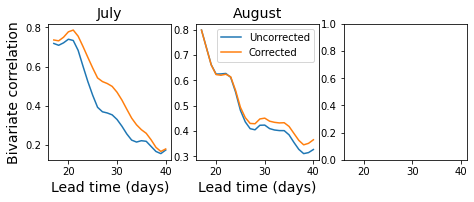

In [648]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7.5, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

corr_sum = numpy.zeros(24)
uncorr_sum = numpy.zeros(24)

i = 0

for month in range(7, 9):
    axs[i].plot(range(23-6, 41), [bcorr(numpy.array(all_miso_obs[month][i]), numpy.array(all_miso_uncorr[month][i])) for i in range(22-6, 40)],
             label='Uncorrected')
    axs[i].plot(range(23-6, 41), [bcorr(numpy.array(all_miso_obs[month][i]), numpy.array(all_miso_corr[month][i])) for i in range(22-6, 40)],
             label='Corrected')
    corr_sum += 0.5*numpy.arctanh(numpy.array([bcorr(numpy.array(all_miso_obs[month][i]), numpy.array(all_miso_corr[month][i])) for i in range(22-6, 40)]))
    uncorr_sum += 0.5*numpy.arctanh(numpy.array([bcorr(numpy.array(all_miso_obs[month][i]), numpy.array(all_miso_uncorr[month][i])) for i in range(22-6, 40)]))
    #axs[i].set_xticks(range(24, 41, 2))
    axs[i].set_xlabel('Lead time (days)', fontsize=14)
    
    i += 1

axs[0].set_ylabel('Bivariate correlation', fontsize=14)
axs[1].legend()
axs[0].set_title('July', fontsize=14)
axs[1].set_title('August', fontsize=14)

#plt.savefig('miso_skill.pdf')

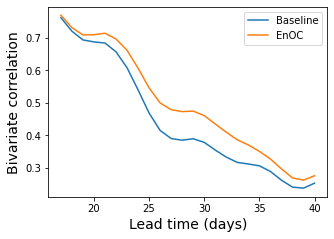

In [649]:
plt.figure(figsize=(5, 3.5))

plt.plot(range(23-6, 41), numpy.tanh(uncorr_sum), label="Baseline")
plt.plot(range(23-6, 41), numpy.tanh(corr_sum), label="EnOC")

plt.xlabel('Lead time (days)', fontsize=14)
plt.ylabel('Bivariate correlation', fontsize=14)
plt.legend()
plt.savefig("miso_skill_july_august2.pdf")

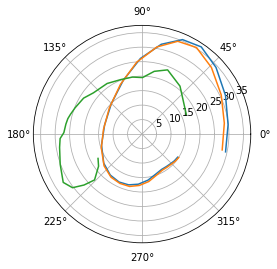

In [642]:
y = 8
m = 9
plt.polar([numpy.angle(complex(*all_miso_uncorr[m][l][y])) for l in range(16, 40)],
          [numpy.abs(complex(*all_miso_uncorr[m][l][y])) for l in range(16, 40)])
plt.polar([numpy.angle(complex(*all_miso_corr[m][l][y])) for l in range(16, 40)],
          [numpy.abs(complex(*all_miso_corr[m][l][y])) for l in range(16, 40)])
plt.polar([numpy.angle(complex(*all_miso_obs[m][l][y])) for l in range(16, 40)],
          [numpy.abs(complex(*all_miso_obs[m][l][y])) for l in range(16, 40)])

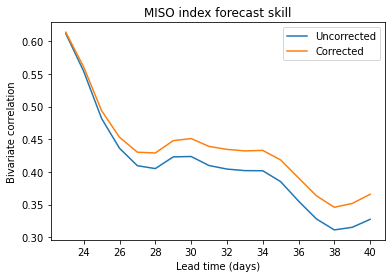

In [178]:
plt.plot(range(23, 41), [bcorr(numpy.array(all_miso_obs[8][i]), numpy.array(all_miso_uncorr[8][i])) for i in range(22, 40)],
         label='Uncorrected')
plt.plot(range(23, 41), [bcorr(numpy.array(all_miso_obs[8][i]), numpy.array(all_miso_corr[8][i])) for i in range(22, 40)],
         label='Corrected')
plt.xticks(range(24, 41, 2))
plt.xlabel('Lead time (days)')
plt.ylabel('Bivariate correlation')
plt.title('MISO index forecast skill')
plt.legend()

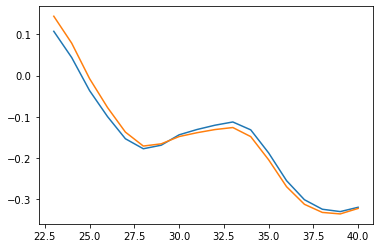

In [582]:
plt.plot(range(23, 41), [bcorr(numpy.array(all_miso_obs[9][i]), numpy.array(all_miso_uncorr[9][i])) for i in range(22, 40)],
         label='Uncorrected')
plt.plot(range(23, 41), [bcorr(numpy.array(all_miso_obs[9][i]), numpy.array(all_miso_corr[9][i])) for i in range(22, 40)],
         label='Corrected')

In [116]:
# Distance-based

opt_dist = 10.0

opt_dists = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

l_average_days = 7
r_average_days = 7

all_res_corr = {}
all_res_uncorr = {}
all_res_obs = {}
all_res_clim = {}

for month in range(7, 8):
    all_res_corr[month] = {}
    all_res_uncorr[month] = {}
    all_res_obs[month] = {}
    all_res_clim[month] = {}

    for lead_time in range(10, 30):
        all_res_corr[month][lead_time] = []
        all_res_uncorr[month][lead_time] = []
        all_res_obs[month][lead_time] = []
        all_res_clim[month][lead_time] = []

        opt_dists = []

        for year in range(1993, 2008):
            res = run_enoc_dist(year, month, lead_time, opt_dist, mp_metric=rmse)
            opt_dists.append(res['opt_dist'])
            #rand_mps.append(res['rand_mp'])

        opt_dist = numpy.arange(1.0, 11.0, 1.0)[numpy.nanargmin(numpy.mean(opt_dists, axis=0))]
        print('opt:', numpy.nanargmin(numpy.mean(opt_dists, axis=0)))

        #errs_corr = []
        #errs_uncorr = []
        for year in range(2008, 2017):
            res = run_enoc_dist(year, month, lead_time, opt_dist, compute_mp=True, mp_metric=rmse)
            #corr_metrics = Metrics(res['ens_corr'], res['obs_state'], metrics=metrics).results
            #uncorr_metrics = Metrics(res['ens_uncorr'], res['obs_state'], metrics=metrics).results
            #obs_metrics = Metrics(xarray.DataArray([res['obs_state']]).rename(dim_0="ensemble"), res['obs_state'], metrics=metrics).results
            #clim_metrics = Metrics(res['ens_uncorr'].sel(ensemble=range(1))*0, res['obs_state'], metrics=metrics).results
            #opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])
            #print(corr_metrics['rmse']/uncorr_metrics['rmse'])

            all_res_corr[month][lead_time].append(res['ens_corr'])
            all_res_uncorr[month][lead_time].append(res['ens_uncorr'])
            all_res_obs[month][lead_time].append(res['obs_state'])
            #all_res_clim[month][lead_time].append(res['ens_corr'])

        #all_errs_corr.append(errs_corr)
        #all_errs_uncorr.append(errs_uncorr)

#pickle.dump(all_res_obs, open("all_res_obs", "wb"))
#pickle.dump(all_res_corr, open("all_res_corr", "wb"))
#pickle.dump(all_res_uncorr, open("all_res_uncorr", "wb"))

Year:  1993 Month:  7 Lead time:  10
Year:  1994 Month:  7 Lead time:  10
Year:  1995 Month:  7 Lead time:  10
Year:  1996 Month:  7 Lead time:  10
Year:  1997 Month:  7 Lead time:  10
Year:  1998 Month:  7 Lead time:  10
Year:  1999 Month:  7 Lead time:  10
Year:  2000 Month:  7 Lead time:  10


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  10
Year:  2002 Month:  7 Lead time:  10
Year:  2003 Month:  7 Lead time:  10
Year:  2004 Month:  7 Lead time:  10
Year:  2005 Month:  7 Lead time:  10
Year:  2006 Month:  7 Lead time:  10
Year:  2007 Month:  7 Lead time:  10
opt: 9
Year:  2008 Month:  7 Lead time:  10
Year:  2009 Month:  7 Lead time:  10
Year:  2010 Month:  7 Lead time:  10
Year:  2011 Month:  7 Lead time:  10
Year:  2012 Month:  7 Lead time:  10
Year:  2013 Month:  7 Lead time:  10
Year:  2014 Month:  7 Lead time:  10
Year:  2015 Month:  7 Lead time:  10
Year:  2016 Month:  7 Lead time:  10
Year:  1993 Month:  7 Lead time:  11


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  11
Year:  1995 Month:  7 Lead time:  11
Year:  1996 Month:  7 Lead time:  11
Year:  1997 Month:  7 Lead time:  11
Year:  1998 Month:  7 Lead time:  11
Year:  1999 Month:  7 Lead time:  11
Year:  2000 Month:  7 Lead time:  11


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  11
Year:  2002 Month:  7 Lead time:  11
Year:  2003 Month:  7 Lead time:  11
Year:  2004 Month:  7 Lead time:  11
Year:  2005 Month:  7 Lead time:  11
Year:  2006 Month:  7 Lead time:  11
Year:  2007 Month:  7 Lead time:  11
opt: 9
Year:  2008 Month:  7 Lead time:  11
Year:  2009 Month:  7 Lead time:  11
Year:  2010 Month:  7 Lead time:  11
Year:  2011 Month:  7 Lead time:  11
Year:  2012 Month:  7 Lead time:  11
Year:  2013 Month:  7 Lead time:  11
Year:  2014 Month:  7 Lead time:  11
Year:  2015 Month:  7 Lead time:  11
Year:  2016 Month:  7 Lead time:  11
Year:  1993 Month:  7 Lead time:  12


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  12
Year:  1995 Month:  7 Lead time:  12
Year:  1996 Month:  7 Lead time:  12
Year:  1997 Month:  7 Lead time:  12
Year:  1998 Month:  7 Lead time:  12
Year:  1999 Month:  7 Lead time:  12
Year:  2000 Month:  7 Lead time:  12


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  12
Year:  2002 Month:  7 Lead time:  12
Year:  2003 Month:  7 Lead time:  12
Year:  2004 Month:  7 Lead time:  12
Year:  2005 Month:  7 Lead time:  12
Year:  2006 Month:  7 Lead time:  12
Year:  2007 Month:  7 Lead time:  12
opt: 9
Year:  2008 Month:  7 Lead time:  12
Year:  2009 Month:  7 Lead time:  12
Year:  2010 Month:  7 Lead time:  12
Year:  2011 Month:  7 Lead time:  12
Year:  2012 Month:  7 Lead time:  12
Year:  2013 Month:  7 Lead time:  12
Year:  2014 Month:  7 Lead time:  12
Year:  2015 Month:  7 Lead time:  12
Year:  2016 Month:  7 Lead time:  12
Year:  1993 Month:  7 Lead time:  13
Year:  1994 Month:  7 Lead time:  13
Year:  1995 Month:  7 Lead time:  13
Year:  1996 Month:  7 Lead time:  13
Year:  1997 Month:  7 Lead time:  13
Year:  1998 Month:  7 Lead time:  13
Year:  1999 Month:  7 Lead time:  13
Year:  2000 Month:  7 Lead time:  13


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  13
Year:  2002 Month:  7 Lead time:  13
Year:  2003 Month:  7 Lead time:  13
Year:  2004 Month:  7 Lead time:  13
Year:  2005 Month:  7 Lead time:  13
Year:  2006 Month:  7 Lead time:  13
Year:  2007 Month:  7 Lead time:  13
opt: 9
Year:  2008 Month:  7 Lead time:  13
Year:  2009 Month:  7 Lead time:  13
Year:  2010 Month:  7 Lead time:  13
Year:  2011 Month:  7 Lead time:  13
Year:  2012 Month:  7 Lead time:  13
Year:  2013 Month:  7 Lead time:  13
Year:  2014 Month:  7 Lead time:  13
Year:  2015 Month:  7 Lead time:  13
Year:  2016 Month:  7 Lead time:  13
Year:  1993 Month:  7 Lead time:  14
Year:  1994 Month:  7 Lead time:  14
Year:  1995 Month:  7 Lead time:  14
Year:  1996 Month:  7 Lead time:  14
Year:  1997 Month:  7 Lead time:  14
Year:  1998 Month:  7 Lead time:  14
Year:  1999 Month:  7 Lead time:  14
Year:  2000 Month:  7 Lead time:  14
Year:  2001 Month:  7 Lead time:  14
Year:  2002 Month:  7 Lead time:  14
Year:  2003 Month:  7 Lead time

/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  14
Year:  2009 Month:  7 Lead time:  14
Year:  2010 Month:  7 Lead time:  14
Year:  2011 Month:  7 Lead time:  14
Year:  2012 Month:  7 Lead time:  14
Year:  2013 Month:  7 Lead time:  14
Year:  2014 Month:  7 Lead time:  14
Year:  2015 Month:  7 Lead time:  14
Year:  2016 Month:  7 Lead time:  14
Year:  1993 Month:  7 Lead time:  15


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  15
Year:  1995 Month:  7 Lead time:  15
Year:  1996 Month:  7 Lead time:  15
Year:  1997 Month:  7 Lead time:  15
Year:  1998 Month:  7 Lead time:  15
Year:  1999 Month:  7 Lead time:  15
Year:  2000 Month:  7 Lead time:  15
Year:  2001 Month:  7 Lead time:  15
Year:  2002 Month:  7 Lead time:  15
Year:  2003 Month:  7 Lead time:  15
Year:  2004 Month:  7 Lead time:  15
Year:  2005 Month:  7 Lead time:  15
Year:  2006 Month:  7 Lead time:  15
Year:  2007 Month:  7 Lead time:  15
opt: 8


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  15
Year:  2009 Month:  7 Lead time:  15
Year:  2010 Month:  7 Lead time:  15
Year:  2011 Month:  7 Lead time:  15
Year:  2012 Month:  7 Lead time:  15
Year:  2013 Month:  7 Lead time:  15
Year:  2014 Month:  7 Lead time:  15
Year:  2015 Month:  7 Lead time:  15
Year:  2016 Month:  7 Lead time:  15
Year:  1993 Month:  7 Lead time:  16


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  16
Year:  1995 Month:  7 Lead time:  16
Year:  1996 Month:  7 Lead time:  16
Year:  1997 Month:  7 Lead time:  16
Year:  1998 Month:  7 Lead time:  16
Year:  1999 Month:  7 Lead time:  16
Year:  2000 Month:  7 Lead time:  16
Year:  2001 Month:  7 Lead time:  16
Year:  2002 Month:  7 Lead time:  16
Year:  2003 Month:  7 Lead time:  16
Year:  2004 Month:  7 Lead time:  16
Year:  2005 Month:  7 Lead time:  16
Year:  2006 Month:  7 Lead time:  16
Year:  2007 Month:  7 Lead time:  16
opt: 8


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  16
Year:  2009 Month:  7 Lead time:  16
Year:  2010 Month:  7 Lead time:  16
Year:  2011 Month:  7 Lead time:  16
Year:  2012 Month:  7 Lead time:  16
Year:  2013 Month:  7 Lead time:  16
Year:  2014 Month:  7 Lead time:  16
Year:  2015 Month:  7 Lead time:  16
Year:  2016 Month:  7 Lead time:  16
Year:  1993 Month:  7 Lead time:  17


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  17
Year:  1995 Month:  7 Lead time:  17
Year:  1996 Month:  7 Lead time:  17
Year:  1997 Month:  7 Lead time:  17
Year:  1998 Month:  7 Lead time:  17
Year:  1999 Month:  7 Lead time:  17
Year:  2000 Month:  7 Lead time:  17


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  17
Year:  2002 Month:  7 Lead time:  17
Year:  2003 Month:  7 Lead time:  17
Year:  2004 Month:  7 Lead time:  17
Year:  2005 Month:  7 Lead time:  17
Year:  2006 Month:  7 Lead time:  17
Year:  2007 Month:  7 Lead time:  17
opt: 3
Year:  2008 Month:  7 Lead time:  17
Year:  2009 Month:  7 Lead time:  17
Year:  2010 Month:  7 Lead time:  17
Year:  2011 Month:  7 Lead time:  17
Year:  2012 Month:  7 Lead time:  17
Year:  2013 Month:  7 Lead time:  17
Year:  2014 Month:  7 Lead time:  17
Year:  2015 Month:  7 Lead time:  17
Year:  2016 Month:  7 Lead time:  17
Year:  1993 Month:  7 Lead time:  18


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  18
Year:  1995 Month:  7 Lead time:  18
Year:  1996 Month:  7 Lead time:  18
Year:  1997 Month:  7 Lead time:  18
Year:  1998 Month:  7 Lead time:  18
Year:  1999 Month:  7 Lead time:  18
Year:  2000 Month:  7 Lead time:  18


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  18
Year:  2002 Month:  7 Lead time:  18
Year:  2003 Month:  7 Lead time:  18
Year:  2004 Month:  7 Lead time:  18
Year:  2005 Month:  7 Lead time:  18
Year:  2006 Month:  7 Lead time:  18
Year:  2007 Month:  7 Lead time:  18
opt: 9
Year:  2008 Month:  7 Lead time:  18
Year:  2009 Month:  7 Lead time:  18
Year:  2010 Month:  7 Lead time:  18
Year:  2011 Month:  7 Lead time:  18
Year:  2012 Month:  7 Lead time:  18
Year:  2013 Month:  7 Lead time:  18
Year:  2014 Month:  7 Lead time:  18
Year:  2015 Month:  7 Lead time:  18
Year:  2016 Month:  7 Lead time:  18
Year:  1993 Month:  7 Lead time:  19


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  19
Year:  1995 Month:  7 Lead time:  19
Year:  1996 Month:  7 Lead time:  19
Year:  1997 Month:  7 Lead time:  19
Year:  1998 Month:  7 Lead time:  19
Year:  1999 Month:  7 Lead time:  19
Year:  2000 Month:  7 Lead time:  19


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  19
Year:  2002 Month:  7 Lead time:  19
Year:  2003 Month:  7 Lead time:  19
Year:  2004 Month:  7 Lead time:  19
Year:  2005 Month:  7 Lead time:  19
Year:  2006 Month:  7 Lead time:  19
Year:  2007 Month:  7 Lead time:  19
opt: 9
Year:  2008 Month:  7 Lead time:  19
Year:  2009 Month:  7 Lead time:  19
Year:  2010 Month:  7 Lead time:  19
Year:  2011 Month:  7 Lead time:  19
Year:  2012 Month:  7 Lead time:  19
Year:  2013 Month:  7 Lead time:  19
Year:  2014 Month:  7 Lead time:  19
Year:  2015 Month:  7 Lead time:  19
Year:  2016 Month:  7 Lead time:  19
Year:  1993 Month:  7 Lead time:  20
Year:  1994 Month:  7 Lead time:  20
Year:  1995 Month:  7 Lead time:  20
Year:  1996 Month:  7 Lead time:  20
Year:  1997 Month:  7 Lead time:  20
Year:  1998 Month:  7 Lead time:  20
Year:  1999 Month:  7 Lead time:  20
Year:  2000 Month:  7 Lead time:  20


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  20
Year:  2002 Month:  7 Lead time:  20
Year:  2003 Month:  7 Lead time:  20
Year:  2004 Month:  7 Lead time:  20
Year:  2005 Month:  7 Lead time:  20
Year:  2006 Month:  7 Lead time:  20
Year:  2007 Month:  7 Lead time:  20
opt: 9
Year:  2008 Month:  7 Lead time:  20
Year:  2009 Month:  7 Lead time:  20
Year:  2010 Month:  7 Lead time:  20
Year:  2011 Month:  7 Lead time:  20
Year:  2012 Month:  7 Lead time:  20
Year:  2013 Month:  7 Lead time:  20
Year:  2014 Month:  7 Lead time:  20
Year:  2015 Month:  7 Lead time:  20
Year:  2016 Month:  7 Lead time:  20
Year:  1993 Month:  7 Lead time:  21
Year:  1994 Month:  7 Lead time:  21
Year:  1995 Month:  7 Lead time:  21
Year:  1996 Month:  7 Lead time:  21
Year:  1997 Month:  7 Lead time:  21
Year:  1998 Month:  7 Lead time:  21
Year:  1999 Month:  7 Lead time:  21
Year:  2000 Month:  7 Lead time:  21


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  21
Year:  2002 Month:  7 Lead time:  21
Year:  2003 Month:  7 Lead time:  21
Year:  2004 Month:  7 Lead time:  21
Year:  2005 Month:  7 Lead time:  21
Year:  2006 Month:  7 Lead time:  21
Year:  2007 Month:  7 Lead time:  21
opt: 9
Year:  2008 Month:  7 Lead time:  21
Year:  2009 Month:  7 Lead time:  21
Year:  2010 Month:  7 Lead time:  21
Year:  2011 Month:  7 Lead time:  21
Year:  2012 Month:  7 Lead time:  21
Year:  2013 Month:  7 Lead time:  21
Year:  2014 Month:  7 Lead time:  21
Year:  2015 Month:  7 Lead time:  21
Year:  2016 Month:  7 Lead time:  21
Year:  1993 Month:  7 Lead time:  22
Year:  1994 Month:  7 Lead time:  22
Year:  1995 Month:  7 Lead time:  22
Year:  1996 Month:  7 Lead time:  22
Year:  1997 Month:  7 Lead time:  22
Year:  1998 Month:  7 Lead time:  22
Year:  1999 Month:  7 Lead time:  22
Year:  2000 Month:  7 Lead time:  22
Year:  2001 Month:  7 Lead time:  22
Year:  2002 Month:  7 Lead time:  22
Year:  2003 Month:  7 Lead time

/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  23
Year:  1995 Month:  7 Lead time:  23
Year:  1996 Month:  7 Lead time:  23
Year:  1997 Month:  7 Lead time:  23
Year:  1998 Month:  7 Lead time:  23
Year:  1999 Month:  7 Lead time:  23
Year:  2000 Month:  7 Lead time:  23


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  23
Year:  2002 Month:  7 Lead time:  23
Year:  2003 Month:  7 Lead time:  23
Year:  2004 Month:  7 Lead time:  23
Year:  2005 Month:  7 Lead time:  23
Year:  2006 Month:  7 Lead time:  23
Year:  2007 Month:  7 Lead time:  23
opt: 9


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  23
Year:  2009 Month:  7 Lead time:  23
Year:  2010 Month:  7 Lead time:  23
Year:  2011 Month:  7 Lead time:  23
Year:  2012 Month:  7 Lead time:  23
Year:  2013 Month:  7 Lead time:  23
Year:  2014 Month:  7 Lead time:  23
Year:  2015 Month:  7 Lead time:  23
Year:  2016 Month:  7 Lead time:  23
Year:  1993 Month:  7 Lead time:  24


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  24
Year:  1995 Month:  7 Lead time:  24
Year:  1996 Month:  7 Lead time:  24
Year:  1997 Month:  7 Lead time:  24
Year:  1998 Month:  7 Lead time:  24
Year:  1999 Month:  7 Lead time:  24
Year:  2000 Month:  7 Lead time:  24


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2001 Month:  7 Lead time:  24
Year:  2002 Month:  7 Lead time:  24
Year:  2003 Month:  7 Lead time:  24
Year:  2004 Month:  7 Lead time:  24
Year:  2005 Month:  7 Lead time:  24
Year:  2006 Month:  7 Lead time:  24
Year:  2007 Month:  7 Lead time:  24
opt: 6


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  24
Year:  2009 Month:  7 Lead time:  24
Year:  2010 Month:  7 Lead time:  24
Year:  2011 Month:  7 Lead time:  24
Year:  2012 Month:  7 Lead time:  24
Year:  2013 Month:  7 Lead time:  24
Year:  2014 Month:  7 Lead time:  24
Year:  2015 Month:  7 Lead time:  24
Year:  2016 Month:  7 Lead time:  24
Year:  1993 Month:  7 Lead time:  25


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  1994 Month:  7 Lead time:  25
Year:  1995 Month:  7 Lead time:  25
Year:  1996 Month:  7 Lead time:  25
Year:  1997 Month:  7 Lead time:  25
Year:  1998 Month:  7 Lead time:  25
Year:  1999 Month:  7 Lead time:  25
Year:  2000 Month:  7 Lead time:  25
Year:  2001 Month:  7 Lead time:  25
Year:  2002 Month:  7 Lead time:  25
Year:  2003 Month:  7 Lead time:  25
Year:  2004 Month:  7 Lead time:  25
Year:  2005 Month:  7 Lead time:  25
Year:  2006 Month:  7 Lead time:  25
Year:  2007 Month:  7 Lead time:  25
opt: 7


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  25
Year:  2009 Month:  7 Lead time:  25
Year:  2010 Month:  7 Lead time:  25
Year:  2011 Month:  7 Lead time:  25
Year:  2012 Month:  7 Lead time:  25
Year:  2013 Month:  7 Lead time:  25
Year:  2014 Month:  7 Lead time:  25
Year:  2015 Month:  7 Lead time:  25
Year:  2016 Month:  7 Lead time:  25
Year:  1993 Month:  7 Lead time:  26
Year:  1994 Month:  7 Lead time:  26
Year:  1995 Month:  7 Lead time:  26
Year:  1996 Month:  7 Lead time:  26
Year:  1997 Month:  7 Lead time:  26
Year:  1998 Month:  7 Lead time:  26
Year:  1999 Month:  7 Lead time:  26
Year:  2000 Month:  7 Lead time:  26
Year:  2001 Month:  7 Lead time:  26
Year:  2002 Month:  7 Lead time:  26
Year:  2003 Month:  7 Lead time:  26
Year:  2004 Month:  7 Lead time:  26
Year:  2005 Month:  7 Lead time:  26
Year:  2006 Month:  7 Lead time:  26
Year:  2007 Month:  7 Lead time:  26
opt: 6


/tmp/ipykernel_235508/4169335441.py:3: RuntimeWarning: Mean of empty slice
  return numpy.sqrt(numpy.nanmean((ens_mean.values - obs)**2))


Year:  2008 Month:  7 Lead time:  26
Year:  2009 Month:  7 Lead time:  26
Year:  2010 Month:  7 Lead time:  26
Year:  2011 Month:  7 Lead time:  26
Year:  2012 Month:  7 Lead time:  26
Year:  2013 Month:  7 Lead time:  26
Year:  2014 Month:  7 Lead time:  26
Year:  2015 Month:  7 Lead time:  26
Year:  2016 Month:  7 Lead time:  26
Year:  1993 Month:  7 Lead time:  27
Year:  1994 Month:  7 Lead time:  27
Year:  1995 Month:  7 Lead time:  27
Year:  1996 Month:  7 Lead time:  27
Year:  1997 Month:  7 Lead time:  27
Year:  1998 Month:  7 Lead time:  27
Year:  1999 Month:  7 Lead time:  27
Year:  2000 Month:  7 Lead time:  27
Year:  2001 Month:  7 Lead time:  27
Year:  2002 Month:  7 Lead time:  27
Year:  2003 Month:  7 Lead time:  27
Year:  2004 Month:  7 Lead time:  27
Year:  2005 Month:  7 Lead time:  27
Year:  2006 Month:  7 Lead time:  27
Year:  2007 Month:  7 Lead time:  27
opt: 3
Year:  2008 Month:  7 Lead time:  27
Year:  2009 Month:  7 Lead time:  27
Year:  2010 Month:  7 Lead time

In [11]:
all_res_obs = pickle.load(open("all_res_obs2", "rb"))
all_res_corr = pickle.load(open("all_res_corr2", "rb"))
all_res_uncorr = pickle.load(open("all_res_uncorr2", "rb"))

In [31]:
pickle.dump(all_res_obs, open("all_res_obs_ext", "wb"))
pickle.dump(all_res_corr, open("all_res_corr_ext", "wb"))
pickle.dump(all_res_uncorr, open("all_res_uncorr_ext", "wb"))

In [178]:
pickle.dump(all_res_obs, open("all_res_obs_avg2", "wb"))
pickle.dump(all_res_corr, open("all_res_corr_avg2", "wb"))
pickle.dump(all_res_uncorr, open("all_res_uncorr_avg2", "wb"))
pickle.dump(all_pcs, open("all_pcs", "wb"))

In [15]:
# use this
all_res_obs = pickle.load(open("all_res_obs_avg2", "rb"))
all_res_corr = pickle.load(open("all_res_corr_avg2", "rb"))
all_res_uncorr = pickle.load(open("all_res_uncorr_avg2", "rb"))

In [20]:
all_pcs = pickle.load(open("all_pcs", "rb"))

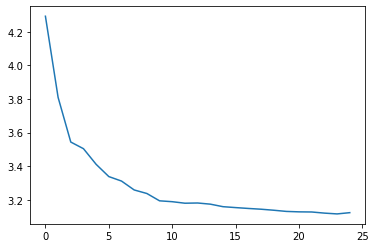

In [22]:
plt.plot(numpy.mean(opt_mps, axis=0))

In [297]:
numpy.mean([opt_mps[i][-1] for i in range(15)])

3.178387

In [144]:
import scipy.stats

In [11]:
# Multi-region

m_p = dict((region, 25) for region in regions)

opt_mps = []
rand_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

l_average_days = 7
r_average_days = 7

all_res_corr = {}
all_res_uncorr = {}
all_res_obs = {}
all_res_clim = {}

all_errs_corr = {}
all_errs_uncorr = {}

for month in range(7, 10):
    all_res_corr[month] = {}
    all_res_uncorr[month] = {}
    all_res_obs[month] = {}
    all_res_clim[month] = {}
    
    all_errs_corr[month] = {}
    all_errs_uncorr[month] = {}

    for lead_time in range(10, 30):
        all_res_corr[month][lead_time] = []
        all_res_uncorr[month][lead_time] = []
        all_res_obs[month][lead_time] = []
        all_res_clim[month][lead_time] = []
        
        all_errs_corr[month][lead_time] = []
        all_errs_uncorr[month][lead_time] = []


        opt_mps = []

        for year in range(1981, 2008):
            res = run_enoc_region(year, month, lead_time, m_p, mp_metric=rmse_region)
            opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])

        m_p = dict([(region, numpy.argmin(numpy.mean([opt_mps[i][region] for i in range(15)], axis=0))+1) for region in regions])
        print(m_p)

        errs_corr = []
        errs_uncorr = []
        for year in range(2008, 2017):
            res = run_enoc_region(year, month, lead_time, m_p, mp_metric=rmse_region, compute_mp=False)
        #    #corr_metrics = Metrics(res['ens_corr'], res['obs_state'], metrics=metrics).results
        #    #uncorr_metrics = Metrics(res['ens_uncorr'], res['obs_state'], metrics=metrics).results
        #    #obs_metrics = Metrics(xarray.DataArray([res['obs_state']]).rename(dim_0="ensemble"), res['obs_state'], metrics=metrics).results
        #    #clim_metrics = Metrics(res['ens_uncorr'].sel(ensemble=range(1))*0, res['obs_state'], metrics=metrics).results
            #opt_mps.append(res['opt_mp'])
            #rand_mps.append(res['rand_mp'])
        #    #print(corr_metrics['rmse']/uncorr_metrics['rmse'])

            all_res_corr[month][lead_time].append(res['ens_corr'])
            all_res_uncorr[month][lead_time].append(res['ens_uncorr'])
            all_res_obs[month][lead_time].append(res['obs_state'])

            all_errs_corr[month][lead_time].append(res['errs_corr'])
            all_errs_uncorr[month][lead_time].append(res['errs_uncorr'])
            #all_res_clim[month][lead_time].append(res['ens_corr'])

        #all_errs_corr.append(errs_corr)
        #all_errs_uncorr.append(errs_uncorr)

NameError: name 'regions' is not defined

In [132]:
m_p = dict([(region, numpy.argmin(numpy.mean([opt_mps[i][region] for i in range(15)], axis=0))+1) for region in regions])

In [185]:
numpy.argmin(numpy.mean([opt_mps[i]['South'] for i in range(15)], axis=0))

21

In [217]:
scipy.stats.ttest_ind([opt_mps[i]['South'][21] for i in range(15)], [opt_mps[i]['South'][-1] for i in range(15)]).pvalue

TypeError: list indices must be integers or slices, not str

In [ ]:
numpy.mean([opt_mps[i][region] for i in range(15)], axis=0)

In [30]:
for region in regions:
    corr = numpy.mean([all_errs_corr[month][lead_time][i][region] for i in range(8)])
    uncorr = numpy.mean([all_errs_uncorr[month][lead_time][i][region] for i in range(8)])

    print(corr/uncorr)

0.97209036
1.002952
1.0001714
1.0
0.99916625
0.90027577


In [130]:
regions

['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [71]:
m_p = dict([(region, numpy.argmin(numpy.mean([opt_mps[i][region] for i in range(15)], axis=0))+1) for region in regions])

In [78]:
m_p

{'South': 15,
 'North': 25,
 'East': 25,
 'West': 21,
 'Northeast': 19,
 'Central': 25}

In [64]:
regions

['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [265]:
month = 9

corrs = [numpy.mean([rmse(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
uncorrs = [numpy.mean([rmse(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
clims = [numpy.mean([rmse(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

In [34]:
numpy.mean([rmse(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)])

4.1725373

In [35]:
numpy.mean([rmse(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)])

4.201344

0.99639636
1.0008743
0.9983123
0.9954836
1.0004702
0.9980853


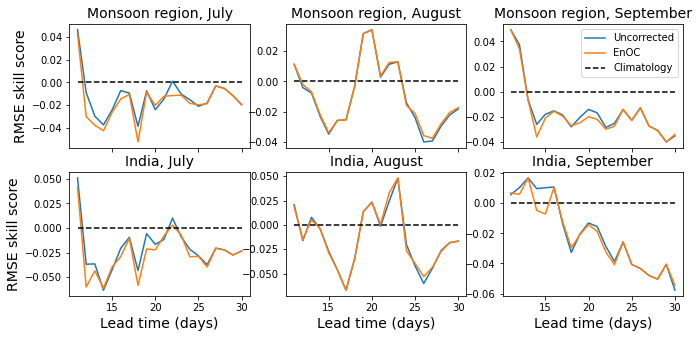

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 5), sharex=True, sharey=False)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([rmse(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    uncorrs = [numpy.mean([rmse(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    clims = [numpy.mean([rmse(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(11, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].plot(range(11, 31), 1 - numpy.array(clims)/numpy.array(clims), label="Climatology", c='black',
                linestyle='--')
    print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))
    
    axs[i].set_title('Monsoon region, ' + ['July', 'August', 'September'][i%3], fontsize=14)

    i += 1

for month in range(7, 10):
    corrs = [numpy.mean([rmse_india(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    uncorrs = [numpy.mean([rmse_india(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    clims = [numpy.mean([rmse_india(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(11, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].plot(range(11, 31), 1 - numpy.array(clims)/numpy.array(clims), label="Climatology", c='black',
                linestyle='--')
    print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))
    
    axs[i].set_title('India, ' + ['July', 'August', 'September'][i%3], fontsize=14)

    i += 1

axs[0].set_ylabel("RMSE skill score", fontsize=14)
axs[3].set_ylabel("RMSE skill score", fontsize=14)
axs[3].set_xlabel("Lead time (days)", fontsize=14)
axs[4].set_xlabel("Lead time (days)", fontsize=14)
axs[5].set_xlabel("Lead time (days)", fontsize=14)

axs[2].legend()
#plt.savefig('rmsess_panel3.pdf')

1.0139165
1.0062947
1.0062302
1.0120468
1.0093691
1.0054344


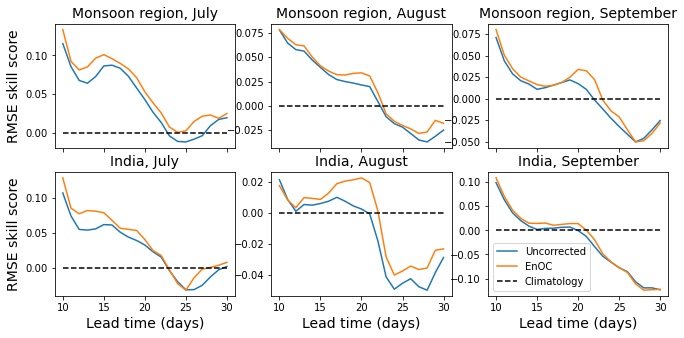

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 5), sharex=True, sharey=False)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([rmse2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    uncorrs = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    clims = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i]*0, avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

    axs[i].plot(range(10, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(10, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].plot(range(10, 31), 1 - numpy.array(clims)/numpy.array(clims), label="Climatology", c='black',
                linestyle='--')
    print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))
    
    axs[i].set_title('Monsoon region, ' + ['July', 'August', 'September'][i%3], fontsize=14)

    i += 1

for month in range(7, 10):
    corrs = [numpy.mean([rmse_india2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    uncorrs = [numpy.mean([rmse_india2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    clims = [numpy.mean([rmse_india2(avg_uncorr[month][lead_time][i]*0, avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

    axs[i].plot(range(10, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(10, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].plot(range(10, 31), 1 - numpy.array(clims)/numpy.array(clims), label="Climatology", c='black',
                linestyle='--')
    print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))
    
    axs[i].set_title('India, ' + ['July', 'August', 'September'][i%3], fontsize=14)

    i += 1

axs[0].set_ylabel("RMSE skill score", fontsize=14)
axs[3].set_ylabel("RMSE skill score", fontsize=14)
axs[3].set_xlabel("Lead time (days)", fontsize=14)
axs[4].set_xlabel("Lead time (days)", fontsize=14)
axs[5].set_xlabel("Lead time (days)", fontsize=14)

axs[5].legend()
#plt.savefig('rmsess_panel4.pdf')

1.0062302
1.0062302


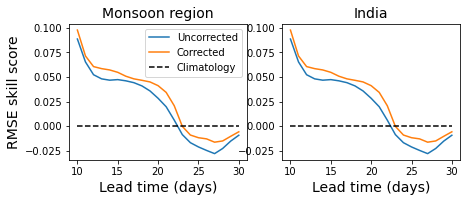

In [287]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

corrs_sum = numpy.zeros(21)
uncorrs_sum = numpy.zeros(21)
clims_sum = numpy.zeros(21)

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([rmse2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    uncorrs = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    clims = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i]*0, avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

    corrs_sum += numpy.array(corrs)/3
    uncorrs_sum += numpy.array(uncorrs)/3
    clims_sum += numpy.array(clims)/3

axs[i].plot(range(10, 31), 1 - uncorrs_sum/clims_sum, label="Uncorrected")
axs[i].plot(range(10, 31), 1 - corrs_sum/clims_sum, label="Corrected")
axs[i].plot(range(10, 31), 1 - clims_sum/clims_sum, label="Climatology", c='black',
            linestyle='--')
print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))

axs[i].set_title('Monsoon region', fontsize=14)

i += 1
    
# corrs_sum = numpy.zeros(21)
# uncorrs_sum = numpy.zeros(21)
# clims_sum = numpy.zeros(21)

# for month in range(7, 10):
#     corrs = [numpy.mean([rmse_india2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
#     uncorrs = [numpy.mean([rmse_india2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
#     clims = [numpy.mean([rmse_india2(avg_uncorr[month][lead_time][i]*0, avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

#     corrs_sum += numpy.array(corrs)/3
#     uncorrs_sum += numpy.array(uncorrs)/3
#     clims_sum += numpy.array(clims)/3
    
axs[i].plot(range(10, 31), 1 - uncorrs_sum/clims_sum, label="Uncorrected")
axs[i].plot(range(10, 31), 1 - corrs_sum/clims_sum, label="Corrected")
axs[i].plot(range(10, 31), 1 - clims_sum/clims_sum, label="Climatology", c='black',
            linestyle='--')
print(numpy.mean(numpy.array(uncorrs)/numpy.array(corrs)))

axs[i].set_title('India', fontsize=14)

i += 1

axs[0].set_ylabel("RMSE skill score", fontsize=14)
axs[0].set_xlabel("Lead time (days)", fontsize=14)
axs[1].set_xlabel("Lead time (days)", fontsize=14)

axs[0].legend()
#plt.savefig('rmsess_averaged.pdf')

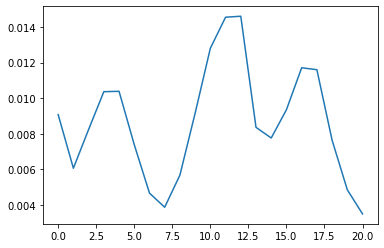

In [290]:
plt.plot((1 - corrs_sum/clims_sum)-(1 - uncorrs_sum/clims_sum))

In [89]:
corrs_sum = numpy.zeros(21)
uncorrs_sum = numpy.zeros(21)
clims_sum = numpy.zeros(21)

for month in range(7, 10):
    corrs = [numpy.mean([rmse_2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    uncorrs = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    clims = [numpy.mean([rmse2(avg_uncorr[month][lead_time][i]*0, avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

    corrs_sum += numpy.array(corrs)/3
    uncorrs_sum += numpy.array(uncorrs)/3
    clims_sum += numpy.array(clims)/3

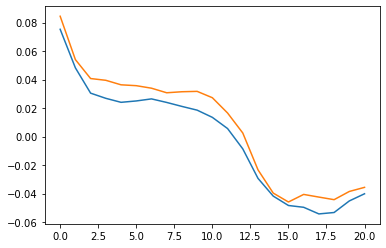

In [90]:
plt.plot(1 - uncorrs_sum/clims_sum)
plt.plot(1 - corrs_sum/clims_sum)

Text(0.5, 0, 'Lead time (days)')

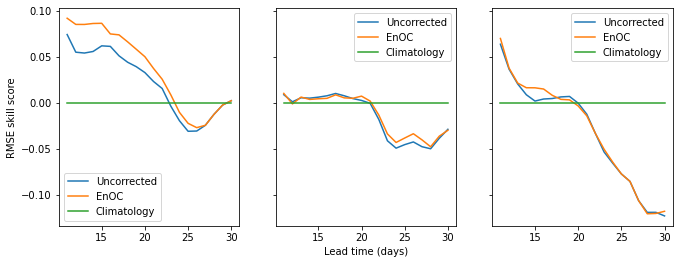

In [296]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey=True)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([rmse_india(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    uncorrs = [numpy.mean([rmse_india(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    clims = [numpy.mean([rmse_india(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(11, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].plot(range(11, 31), 1 - numpy.array(clims)/numpy.array(clims), label="Climatology")
    axs[i].legend()
    
    i += 1

axs[0].set_ylabel("RMSE skill score")
axs[1].set_xlabel("Lead time (days)")

KeyError: 8

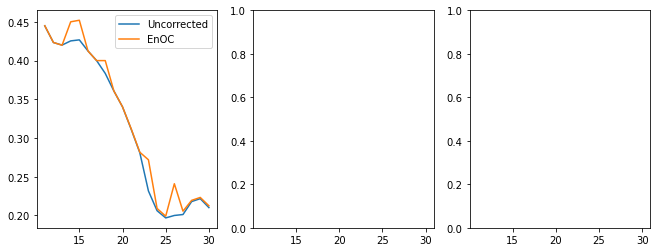

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey=False)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([corr(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]
    uncorrs = [numpy.mean([corr(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(11, 31), numpy.array(uncorrs), label="Uncorrected")
    axs[i].plot(range(11, 31), numpy.array(corrs), label="EnOC")
    axs[i].legend()
    
    i += 1

axs[0].set_ylabel("Anomaly correlation")
axs[1].set_xlabel("Lead time (days)")

Text(0.5, 0, 'Lead time (days)')

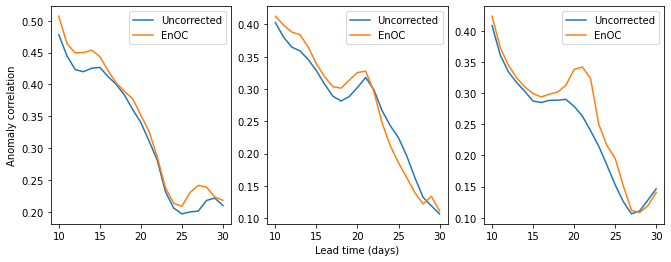

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey=False)
axs=axs.flatten()

corrs_sum = numpy.zeros(21)
uncorrs_sum = numpy.zeros(21)

j = 0
for month in range(7, 10):
    corrs = [numpy.mean([corr2(avg_corr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]
    uncorrs = [numpy.mean([corr2(avg_uncorr[month][lead_time][i], avg_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(9, 30)]

    corrs_sum += corrs
    uncorrs_sum += uncorrs
    axs[j].plot(range(10, 31), numpy.array(uncorrs), label="Uncorrected")
    axs[j].plot(range(10, 31), numpy.array(corrs), label="EnOC")
    axs[j].legend()
    
    j += 1

axs[0].set_ylabel("Anomaly correlation")
axs[1].set_xlabel("Lead time (days)")

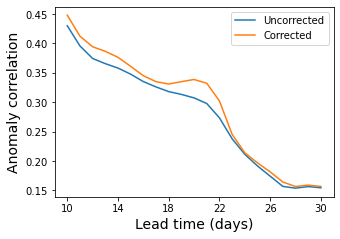

In [12]:
plt.figure(figsize=(5, 3.5))
plt.plot(range(10, 31), uncorrs_sum/3, label="Uncorrected")
plt.plot(range(10, 31), corrs_sum/3, label="Corrected")
plt.xlabel("Lead time (days)", fontsize=14)
plt.ylabel("Anomaly correlation", fontsize=14)
plt.xticks(range(10, 32, 4))
plt.legend()
#plt.savefig("acorr2.pdf")

In [16]:
uncorrs_sum/corrs_sum

array([0.95993719, 0.9597779 , 0.94933573, 0.94592355, 0.95146366,
       0.96310488, 0.97115274, 0.97318853, 0.96104939, 0.9353055 ,
       0.90752955, 0.89626748, 0.90484191, 0.96925816, 0.98783747,
       0.97316295, 0.95941198, 0.95449355, 0.98232397, 0.98418985,
       0.98546582])

Text(0.5, 0, 'Lead time (days)')

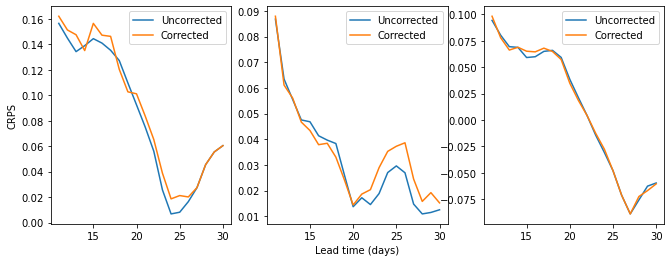

In [219]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey=False)
axs=axs.flatten()

def get_clim(i, month, lead_time):
    return xarray.DataArray(numpy.array(all_res_obs[month][lead_time])[list(set(range(9)) - set([i]))]).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})

def get_corr(i, month, lead_time):
    clim = get_clim(i, month, lead_time)
    corr = xarray.DataArray(all_res_corr[month][lead_time][i].data).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})
    return corr

def get_uncorr(i, month, lead_time):
    uncorr = xarray.DataArray(all_res_uncorr[month][lead_time][i].data).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})
    return uncorr

def get_obs(i, month, lead_time):
    return xarray.DataArray(all_res_obs[month][lead_time][i]).rename({'dim_0': 'lat', 'dim_1': 'lon'})

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([crps(get_corr(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(10, 30)]
    uncorrs = [numpy.mean([crps(get_uncorr(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(10, 30)]
    clims = [numpy.mean([crps(get_clim(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(10, 30)]

    #clims = [numpy.mean([crps(all_res_uncorr[month][lead_time][i]*0, xarray.DataArray(all_res_obs[month][lead_time][i]).rename({'dim_0': 'lat', 'dim_1': 'lon'})) for i in range(9)]) for lead_time in range(10, 30)]
    #clims = [numpy.mean([crps(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(11, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="Corrected")
    #axs[i].plot(range(11, 31), numpy.array(clims), label="Climatology")
    #axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].legend()
    
    i += 1

axs[0].set_ylabel("CRPS")
axs[1].set_xlabel("Lead time (days)")

Text(0.5, 0, 'Lead time (days)')

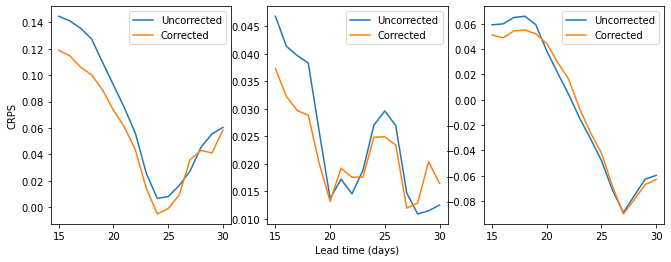

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey=False)
axs=axs.flatten()

def get_clim(i, month, lead_time):
    return xarray.DataArray(numpy.array(avg_obs[month][lead_time])[list(set(range(9)) - set([i]))]).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})

def get_corr(i, month, lead_time):
    #clim = get_clim(i, month, lead_time)
    corr = xarray.DataArray(avg_corr[month][lead_time][i].data).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})
    uncorr = get_uncorr(i, month, lead_time)
    return corr

def get_uncorr(i, month, lead_time):
    uncorr = xarray.DataArray(avg_uncorr[month][lead_time][i].data).rename({'dim_0': 'ensemble', 'dim_1': 'lat', 'dim_2': 'lon'})
    return uncorr

def get_obs(i, month, lead_time):
    return xarray.DataArray(avg_obs[month][lead_time][i]).rename({'dim_0': 'lat', 'dim_1': 'lon'})

i = 0
for month in range(7, 10):
    corrs = [numpy.mean([crps(get_corr(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(14, 30)]
    uncorrs = [numpy.mean([crps(get_uncorr(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(14, 30)]
    clims = [numpy.mean([crps(get_clim(i, month, lead_time), get_obs(i, month, lead_time)) for i in range(9)]) for lead_time in range(14, 30)]

    #clims = [numpy.mean([crps(all_res_uncorr[month][lead_time][i]*0, xarray.DataArray(all_res_obs[month][lead_time][i]).rename({'dim_0': 'lat', 'dim_1': 'lon'})) for i in range(9)]) for lead_time in range(10, 30)]
    #clims = [numpy.mean([crps(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i]) for i in range(9)]) for lead_time in range(10, 30)]

    axs[i].plot(range(15, 31), 1 - numpy.array(uncorrs)/numpy.array(clims), label="Uncorrected")
    axs[i].plot(range(15, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="Corrected")
    #axs[i].plot(range(11, 31), numpy.array(clims), label="Climatology")
    #axs[i].plot(range(11, 31), 1 - numpy.array(corrs)/numpy.array(clims), label="EnOC")
    axs[i].legend()
    
    i += 1

axs[0].set_ylabel("CRPS")
axs[1].set_xlabel("Lead time (days)")

In [114]:
get_corr(i, month, lead_time)*numpy.std(get_uncorr(i, month, lead_time), axis=0)/numpy.std(get_corr(i, month, lead_time), axis=0)

<xarray.DataArray (ensemble: 24, lat: 34, lon: 35)>
array([[[-2.15275049e+00, -2.32285953e+00, -3.22356820e+00, ...,
         -5.15682817e-01,  5.54827881e+00,  1.14663363e+01],
        [-1.32743573e+00, -7.60919869e-01, -9.78710055e-01, ...,
          4.66818523e+00,  1.16106672e+01,  3.99329233e+00],
        [-1.02581954e+00, -7.66164482e-01,  6.42243505e-01, ...,
          3.31424761e+00,  1.46264136e+00,  3.43415976e+00],
        ...,
        [-1.92406308e-02, -2.48648543e-02, -4.05319743e-02, ...,
          2.03013706e+00,  1.70010149e+00,  2.02494168e+00],
        [-3.29518765e-02, -8.21607560e-02, -6.68172389e-02, ...,
          1.38260293e+00,  1.12912130e+00,  6.19917549e-02],
        [-5.07103279e-02, -2.05506682e-01, -5.07525265e-01, ...,
          6.57137513e-01,  1.10089231e+00,  5.42054296e-01]],

       [[-3.33222485e+00, -3.45123482e+00, -3.82584357e+00, ...,
         -1.22375393e+00, -4.71530962e+00, -2.87109637e+00],
        [-2.66659999e+00, -2.84833527e+00, -3.04090810e+00, ...,
         -3.46912003e+00, -2.65083671e+00, -2.85022163e+00],
        [-1.68775618e+00, -2.08759975e+00, -2.56728292e+00, ...,
         -2.59933019e+00, -6.40421331e-01, -2.90556717e+00],
...
          1.35569501e+00,  1.47797048e+00,  2.46866298e+00],
        [-3.29518765e-02, -8.31575617e-02, -6.57600909e-02, ...,
          2.65983486e+00,  1.85810447e+00,  1.65802526e+00],
        [-5.07103279e-02, -2.40033537e-01, -7.11664319e-01, ...,
          2.22311497e+00,  2.59295177e+00,  7.32001126e-01]],

       [[-2.28734803e+00, -2.06568551e+00, -2.09978628e+00, ...,
         -1.38312054e+00, -1.94842422e+00, -2.25492573e+00],
        [-1.86389923e+00, -1.22146714e+00, -1.10953200e+00, ...,
         -3.99213934e+00, -4.07339811e+00, -3.92410493e+00],
        [ 1.69872537e-01, -4.18049634e-01, -4.94080245e-01, ...,
         -3.50595140e+00, -1.54792562e-01, -3.46947283e-01],
        ...,
        [-1.92406308e-02, -2.38669589e-02, -4.05319743e-02, ...,
         -2.40082607e-01, -1.40984505e-01, -1.26858324e-01],
        [-3.29518765e-02, -1.93619654e-02, -3.82743031e-02, ...,
          3.40597868e-01,  5.17812729e-01,  1.54071546e+00],
        [ 1.70806777e-02,  1.18436664e-01, -1.60589367e-01, ...,
          5.96332669e-01,  9.75635409e-01,  5.00848770e-01]]],
      dtype=float32)
Dimensions without coordinates: ensemble, lat, lon

In [174]:
xarray.DataArray(numpy.array(all_res_obs[month][lead_time])[list(set(range(9)) - set([i]))])

<xarray.DataArray (dim_0: 8, dim_1: 34, dim_2: 35)>
array([[[-5.2001252e+00, -5.7446651e+00, -6.3308043e+00, ...,
         -1.5182989e+00, -3.6001068e-01, -1.2460843e+00],
        [-4.8225551e+00, -5.5747156e+00, -6.1660595e+00, ...,
         -2.7752047e+00, -3.1780019e+00, -4.5299716e+00],
        [-3.9447446e+00, -4.3601780e+00, -4.4962831e+00, ...,
         -7.2893448e+00, -7.6509085e+00, -4.5719571e+00],
        ...,
        [-3.7080601e-02, -8.1551448e-02, -8.5493498e-02, ...,
          4.1105610e-01,  1.0458515e+00,  2.5482234e-01],
        [ 4.6957280e-02, -2.1738140e-01, -1.9214076e-01, ...,
          6.4028919e-01,  7.5913161e-01, -3.1428134e-01],
        [-9.3172397e-03,  9.6083023e-02,  3.3329716e-01, ...,
          8.1516635e-01,  1.0982872e+00,  2.4946206e+00]],

       [[-4.3581209e+00, -5.0062146e+00, -5.0330768e+00, ...,
         -4.3657813e+00, -3.7384698e+00, -1.4770627e+00],
        [-2.1186292e+00, -2.9619334e+00, -3.5972903e+00, ...,
         -3.8056142e+00, -2.5266800e+00, -6.5353274e+00],
        [ 8.0003679e-01,  4.0523109e-01, -8.3312196e-01, ...,
         -1.5898229e+00, -9.5485485e-01, -4.1652246e+00],
...
        [-3.7245259e-02, -8.1716105e-02, -8.4117256e-02, ...,
         -2.4357933e-01, -4.2983896e-01, -1.4502002e+00],
        [-2.5250034e-03, -3.3998403e-01, -1.7739232e-01, ...,
         -6.5323055e-01, -9.5266163e-01, -5.7191551e-01],
        [-8.1378147e-02, -2.4622600e-01, -4.7642058e-01, ...,
         -5.8217031e-01, -8.2712454e-01, -7.0012110e-01]],

       [[-5.4267116e+00, -6.0120192e+00, -6.6618671e+00, ...,
         -5.7953014e+00, -5.9204712e+00, -5.1659245e+00],
        [-4.6759868e+00, -5.3235888e+00, -5.8012586e+00, ...,
         -6.2381840e+00, -7.5819545e+00, -8.5449791e+00],
        [-3.3854973e+00, -3.8414979e+00, -4.0044589e+00, ...,
         -5.2427883e+00, -5.9897075e+00, -6.0018773e+00],
        ...,
        [-3.4248885e-02, -3.4138195e-02, -3.5172030e-02, ...,
         -2.6876193e-01, -4.3257153e-01, -2.1719182e+00],
        [-3.7065271e-02, -1.8452708e-01,  1.0003350e-01, ...,
         -6.1842614e-01, -1.0508657e+00, -1.2160342e+00],
        [-1.1891517e-01, -2.5721285e-01,  1.3789450e-01, ...,
         -3.4695926e-01, -5.3056186e-01, -2.0798925e-01]]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1, dim_2

In [320]:
arr = xarray.DataArray(all_res_obs[month][lead_time][i])

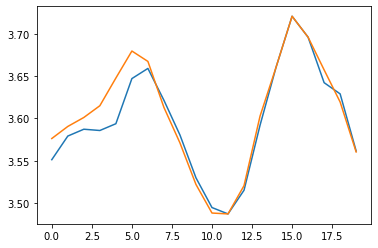

In [303]:
plt.plot(numpy.array(corrs))
plt.plot(numpy.array(uncorrs))

In [25]:
numpy.argmin(numpy.abs(1 - numpy.array(corrs)/numpy.array(clims)))

14

In [26]:
numpy.argmin(numpy.abs(1 - numpy.array(uncorrs)/numpy.array(clims)))

16

In [57]:
regions

['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [88]:
month = 9
region = 'East'

corrs = [numpy.mean([rmse_region(all_res_corr[month][lead_time][i][region], all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]
uncorrs = [numpy.mean([rmse_region(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]
clims = [numpy.mean([rmse_region(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]

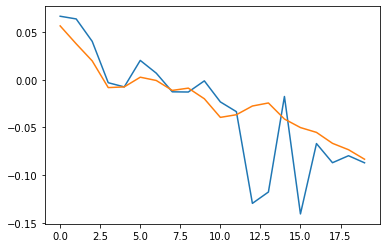

In [89]:
plt.plot(1 - numpy.array(corrs)/numpy.array(clims))
plt.plot(1 - numpy.array(uncorrs)/numpy.array(clims))

In [273]:
regions

['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [310]:
month = 8
region = 'Central'

corrs = [numpy.mean([rmse_region(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]
uncorrs = [numpy.mean([rmse_region(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]
clims = [numpy.mean([rmse_region(all_res_uncorr[month][lead_time][i]*0, all_res_obs[month][lead_time][i], region) for i in range(9)]) for lead_time in range(10, 30)]

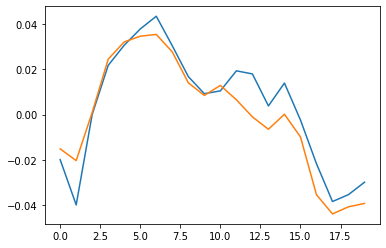

In [311]:
plt.plot(1 - numpy.array(corrs)/numpy.array(clims))
plt.plot(1 - numpy.array(uncorrs)/numpy.array(clims))

In [27]:
all_res_uncorr[month][lead_time][0].lat[12:24]

<xarray.DataArray 'lat' (lat: 12)>
array([18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
      dtype=float32)
Coordinates:
  * lat           (lat) float32 18.0 19.0 20.0 21.0 22.0 ... 26.0 27.0 28.0 29.0
    initial_time  datetime64[ns] 2008-08-01
    dayofyear     <U5 '08-01'
Attributes:
    La1:        39.0
    Lo1:        66.0
    La2:        6.0
    Lo2:        100.0
    Di:         1.0
    Dj:         1.0
    units:      degrees_north
    GridType:   Cylindrical Equidistant Projection Grid
    long_name:  latitude

In [32]:
all_res_uncorr[month][lead_time][0].lon[7:17]

<xarray.DataArray 'lon' (lon: 10)>
array([73., 74., 75., 76., 77., 78., 79., 80., 81., 82.], dtype=float32)
Coordinates:
    initial_time  datetime64[ns] 2008-08-01
  * lon           (lon) float32 73.0 74.0 75.0 76.0 77.0 ... 79.0 80.0 81.0 82.0
    dayofyear     <U5 '08-01'
Attributes:
    La1:        39.0
    Lo1:        66.0
    La2:        6.0
    Lo2:        100.0
    Di:         1.0
    Dj:         1.0
    units:      degrees_east
    GridType:   Cylindrical Equidistant Projection Grid
    long_name:  longitude

In [39]:
mask_core = mask_lowres.copy()
mask_core[:, :] = False
mask_core[12:24, 7:17] = True

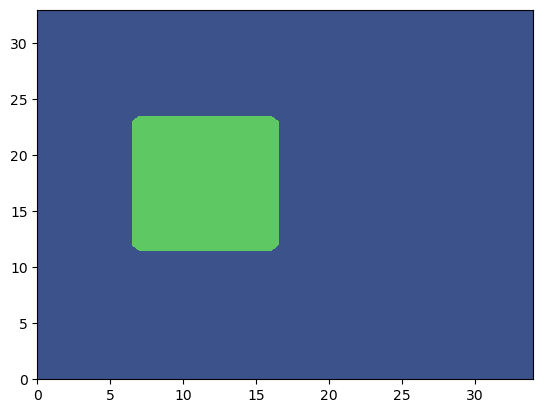

In [42]:
plt.contourf(mask_core)

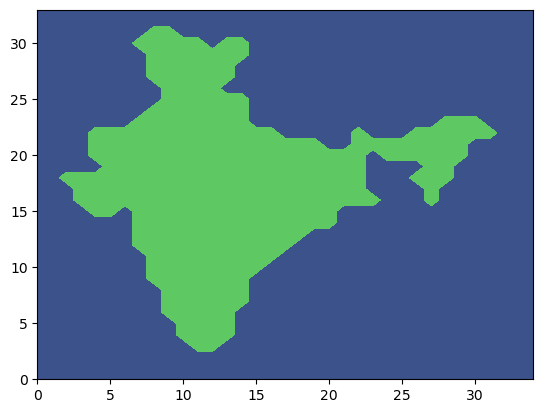

In [43]:
plt.contourf(mask_lowres)

In [38]:
all_res_corr[month][lead_time][0]['South']

<xarray.DataArray 'p' (ensemble: 19, lat: 34, lon: 35)>
array([[[-3.7436795e+00, -4.5169272e+00, -4.8042808e+00, ...,
         -4.7691455e+00, -6.2885981e+00, -6.6341367e+00],
        [-3.1018445e+00, -3.4833984e+00, -4.2806401e+00, ...,
         -5.8613992e+00, -7.8950067e+00, -6.9761534e+00],
        [-2.8781819e+00, -3.1411862e+00, -3.6459041e+00, ...,
         -2.2549241e+00, -2.9329724e+00,  1.6514219e-01],
        ...,
        [-1.9601781e-02, -2.5347224e-02, -4.1357417e-02, ...,
         -6.3803440e-01, -3.1829968e-01, -5.1800936e-01],
        [-3.3561196e-02, -7.3673502e-02, -4.2778905e-03, ...,
          8.8774905e-02, -4.7989365e-01, -8.9900440e-01],
        [-5.1744256e-02, -1.0210232e-01, -1.6244850e-01, ...,
         -5.2160096e-01, -1.1814018e+00, -7.8699547e-01]],

       [[-4.4801702e+00, -5.1638999e+00, -5.3485107e+00, ...,
         -1.1660370e+00, -2.3182614e+00, -5.8620410e+00],
        [-3.7874727e+00, -4.3755288e+00, -4.9011641e+00, ...,
         -3.0822647e+00, -3.9684112e+00, -2.5490701e+00],
        [-3.5027750e+00, -3.8278317e+00, -4.1860652e+00, ...,
         -7.0878906e+00, -4.4364719e+00, -3.2008782e-01],
...
        [-1.9601781e-02, -1.4157446e-02, -4.1357417e-02, ...,
         -3.4608290e-01, -5.5633682e-01, -8.3030593e-01],
        [ 4.3749996e-02,  4.6852213e-01, -3.4795463e-02, ...,
         -5.2768010e-01, -4.5751402e-01, -4.5955136e-01],
        [-5.1744256e-02,  1.4712457e-01,  5.2623165e-01, ...,
         -4.2394480e-01, -6.3310272e-01, -3.8518065e-01]],

       [[-4.4638944e+00, -4.8648276e+00, -4.7483315e+00, ...,
         -3.3449924e+00, -5.9152665e+00, -5.9179902e+00],
        [-3.8139215e+00, -4.0754395e+00, -4.4098310e+00, ...,
         -4.4443660e+00, -7.2571883e+00, -6.2366109e+00],
        [-3.0826497e+00, -3.5663979e+00, -3.7934058e+00, ...,
         -4.1398931e+00,  1.8654078e+00, -2.1460559e+00],
        ...,
        [-1.9601781e-02, -2.4329968e-02, -4.1357417e-02, ...,
         -3.5015193e-01, -1.8198782e-01, -4.3866375e-01],
        [-3.3561196e-02, -8.3846018e-02, -6.4295791e-02, ...,
         -4.7173122e-01, -1.0452739e-01,  8.5880822e-01],
        [-5.2761506e-02, -2.4146596e-01, -6.5378153e-01, ...,
         -2.9271919e-01,  1.3695754e-01,  3.6656901e-01]]], dtype=float32)
Coordinates:
  * lat           (lat) float32 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * ensemble      (ensemble) int32 23 12 6 2 9 20 21 7 ... 0 11 18 16 13 3 10 22
    initial_time  datetime64[ns] 2008-09-01
  * lon           (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
    dayofyear     object ...

In [144]:
month = 9
lead_time = 10

all_mprecs_corr = []
all_mprecs_uncorr = []

for lead_time in range(10, 25):
    mprec_corr = [mean_prec_india(all_res_corr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(8)]
    mprec_uncorr = [mean_prec_india(all_res_uncorr[month][lead_time][i], all_res_obs[month][lead_time][i]) for i in range(8)]
    mprec_obs = [all_res_obs[month][lead_time][i][mask_lowres].mean() for i in range(8)]
    all_mprecs_corr.append(numpy.corrcoef(mprec_corr, mprec_obs)[0, 1])
    all_mprecs_uncorr.append(numpy.corrcoef(mprec_uncorr, mprec_obs)[0, 1])

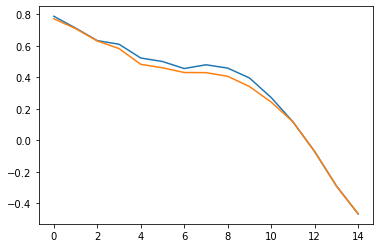

In [145]:
plt.plot(all_mprecs_corr)
plt.plot(all_mprecs_uncorr)

In [275]:
2.2828264/2.2537348

1.0129081735792516

In [62]:
numpy.corrcoef([y.mean('ensemble').sum().values for y in all_res_corr[7][20]],
               [y.sum() for y in all_res_obs[7][20]])

array([[1.        , 0.74671927],
       [0.74671927, 1.        ]])

In [283]:
numpy.mean([numpy.sqrt(numpy.mean((y.mean('ensemble') - all_res_obs[7][20][i])**2)) for i, y in enumerate(all_res_corr[7][20])])

KeyError: 7

In [284]:
numpy.mean([numpy.sqrt(numpy.mean((y.mean('ensemble') - all_res_obs[7][20][i])**2)) for i, y in enumerate(all_res_uncorr[7][20])])

KeyError: 7

In [105]:
month = 7
tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_corr[month][lead_time]], [y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
cross_corr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_uncorr[month][lead_time]], [y.mean('ensemble').values[mask_lowres].sum() for y in all_res_corr[month][lead_time]])[0, 1] for lead_time in range(10, 25)]

0.3602869138338743 0.4147162069272184 0.0544292930933441
0.4555727781288334 0.4785787553427045 0.0230059772138711
-0.11237699164163442 -0.10300408908758873 0.009372902554045687
0.041090392353700475 0.06396498088939379 0.02287458853569331
0.3569294007412691 0.37530932168436903 0.018379920943099926
0.05975658366903031 0.07486333677825555 0.015106753109225234


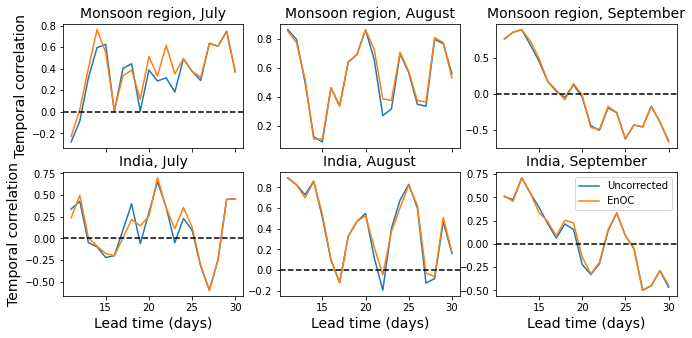

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 5), sharex=True, sharey=False)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    #plt.subplot(1, 3, i)
    tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values.sum() for y in all_res_corr[month][lead_time]], [y.sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values.sum() for y in all_res_uncorr[month][lead_time]], [y.sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
    axs[i].plot(range(11, 31), tcorr_uncorr)
    axs[i].plot(range(11, 31), tcorr_corr)
    #axs[i].set_ylim(-0.3, 0.9)
    if min(tcorr_uncorr) < 0:
        axs[i].axhline(0.0,color='black',ls='--')
    axs[i].set_title('Monsoon region, ' + ['July', 'August', 'September'][i], fontsize=14)
    print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
    i += 1

for month in range(7, 10):
    tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_corr[month][lead_time]], [y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 30)]
    axs[i].plot(range(11, 31), tcorr_uncorr, label='Uncorrected')
    axs[i].plot(range(11, 31), tcorr_corr, label='EnOC')
    #axs[i].set_ylim(-0.3, 0.9)
    axs[i].set_xlabel("Lead time (days)", fontsize=14)
    if min(tcorr_uncorr) < 0:
        axs[i].axhline(0.0,color='black',ls='--')
    axs[i].set_title('India, ' + ['July', 'August', 'September'][i%3], fontsize=14)
    print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
    i += 1
    
axs[0].set_ylabel("Temporal correlation", fontsize=14)
axs[3].set_ylabel("Temporal correlation", fontsize=14)
axs[5].legend()

#plt.savefig("tcorr_panel4.pdf")

#fig.text(0.5, 0.04, 'common X', ha='center')
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

0.5346221977055187 0.7566530783636801 0.22203088065816146
0.7014784900202996 0.730279766534488 0.0288012765141884
0.16336739766573455 0.17053685390925424 0.007169456243519695
0.07929258652903916 0.2648337822446024 0.18554119571556327
0.6645923974379493 0.7327062865042678 0.06811388906631854
0.16951754691336146 0.20639035086284413 0.03687280394948267


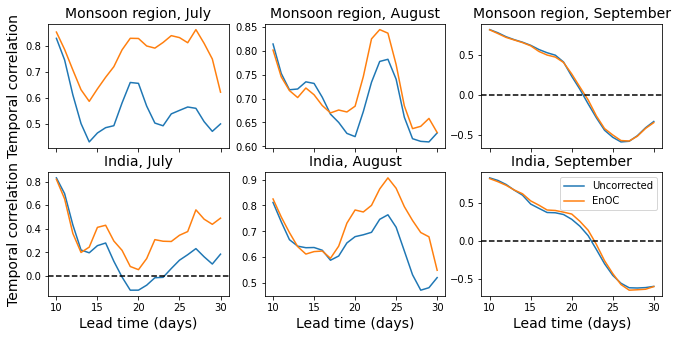

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 5), sharex=True, sharey=False)
axs=axs.flatten()

i = 0
for month in range(7, 10):
    #plt.subplot(1, 3, i)
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    axs[i].plot(range(10, 31), tcorr_uncorr)
    axs[i].plot(range(10, 31), tcorr_corr)
    #axs[i].set_ylim(-0.3, 0.9)
    if min(tcorr_uncorr) < 0:
        axs[i].axhline(0.0,color='black',ls='--')
    axs[i].set_title('Monsoon region, ' + ['July', 'August', 'September'][i], fontsize=14)
    print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
    i += 1

for month in range(7, 10):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    axs[i].plot(range(10, 31), tcorr_uncorr, label='Uncorrected')
    axs[i].plot(range(10, 31), tcorr_corr, label='EnOC')
    #axs[i].set_ylim(-0.3, 0.9)
    axs[i].set_xlabel("Lead time (days)", fontsize=14)
    if min(tcorr_uncorr) < 0:
        axs[i].axhline(0.0,color='black',ls='--')
    axs[i].set_title('India, ' + ['July', 'August', 'September'][i%3], fontsize=14)
    print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
    i += 1
    
axs[0].set_ylabel("Temporal correlation", fontsize=14)
axs[3].set_ylabel("Temporal correlation", fontsize=14)
axs[5].legend()

#plt.savefig("tcorr_panel5.pdf")

#fig.text(0.5, 0.04, 'common X', ha='center')
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

0.7014784900202996 0.730279766534488 0.0288012765141884
0.6645923974379493 0.7327062865042678 0.06811388906631854


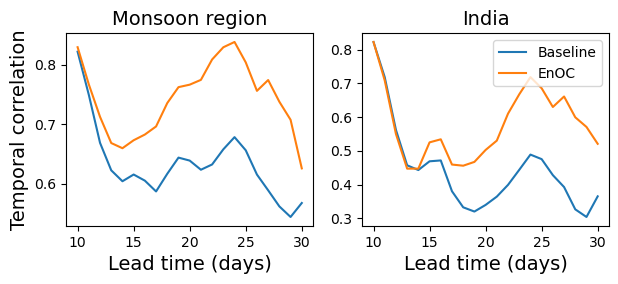

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

corr_sum = numpy.zeros(30-9)
uncorr_sum = numpy.zeros(30-9)

i = 0
for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Uncorrected')
axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.52, 0.87)
axs[i].set_title('Monsoon region', fontsize=14)
axs[i].set_xlabel("Lead time (days)", fontsize=14)

print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
i += 1

corr_sum = numpy.zeros(30-9)
uncorr_sum = numpy.zeros(30-9)

for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
    
axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Baseline')
axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.27, 0.92)
axs[i].set_xlabel("Lead time (days)", fontsize=14)
if min(tcorr_uncorr) < 0:
    axs[i].axhline(0.0,color='black',ls='--')
axs[i].set_title('India', fontsize=14)
print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
i += 1
    
axs[0].set_ylabel("Temporal correlation", fontsize=14)
axs[1].legend()
# plt.savefig('tcorr_july_august2.pdf')

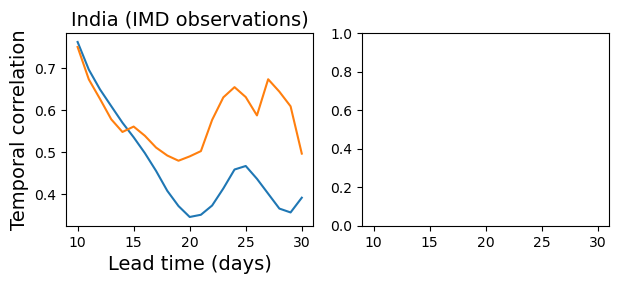

In [94]:
#IMD data

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

corr_sum = numpy.zeros(30-9)
uncorr_sum = numpy.zeros(30-9)

i = 0
for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs_imd[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs_imd[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Uncorrected')
axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.52, 0.87)
axs[i].set_title('India (IMD observations)', fontsize=14)
axs[i].set_xlabel("Lead time (days)", fontsize=14)
axs[0].set_ylabel("Temporal correlation", fontsize=14)
plt.savefig('tcorr_imd.pdf')

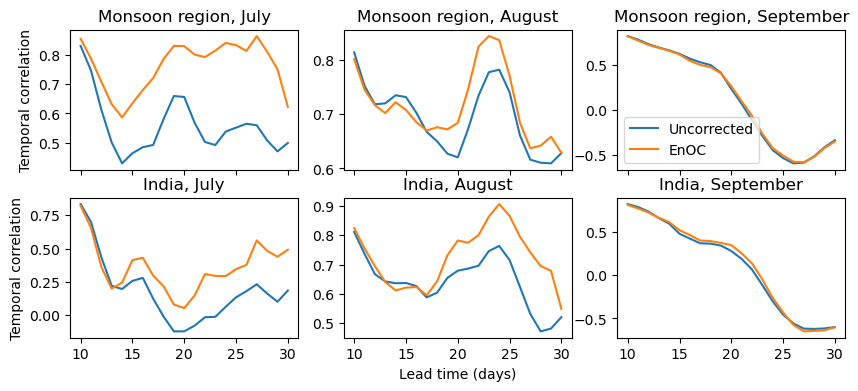

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharex=True, sharey=False)
axs=axs.flatten()

corr_sum = numpy.zeros(30-9)
uncorr_sum = numpy.zeros(30-9)

i = 0
for month in range(7, 10):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

    axs[i].plot(range(10, 31), (tcorr_uncorr), label='Uncorrected')
    axs[i].plot(range(10, 31), (tcorr_corr), label='EnOC')
    i += 1
#axs[i].set_ylim(0.52, 0.87)
axs[0].set_title('Monsoon region, July')
axs[1].set_title('Monsoon region, August')
axs[2].set_title('Monsoon region, September')

axs[4].set_xlabel("Lead time (days)")


corr_sum = numpy.zeros(30-9)
uncorr_sum = numpy.zeros(30-9)

for month in range(7, 10):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    
    axs[i].plot(range(10, 31), (tcorr_uncorr), label='Baseline')
    axs[i].plot(range(10, 31), (tcorr_corr), label='EnOC')
    i += 1
#axs[i].set_ylim(0.27, 0.92)
axs[0].set_ylabel("Temporal correlation")
axs[3].set_ylabel("Temporal correlation")
axs[2].legend()

axs[3].set_title('India, July')
axs[4].set_title('India, August')
axs[5].set_title('India, September')

plt.savefig('tcorr_july_august_september.pdf')

0.6874672588106591 0.7179744518609877 0.030507193050328674


IndexError: Unlabeled multi-dimensional array cannot be used for indexing: lat

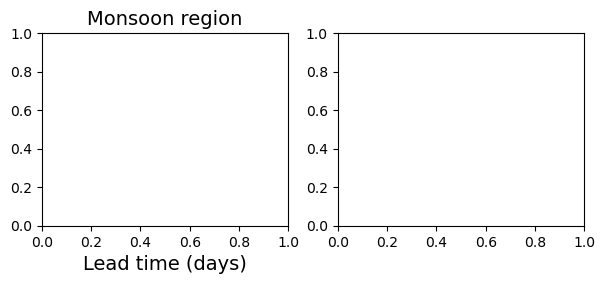

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

corr_sum = numpy.zeros(30-7)
uncorr_sum = numpy.zeros(30-7)

i = 0
for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(7, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(7, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
# axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Uncorrected')
# axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.52, 0.87)
axs[i].set_title('Monsoon region', fontsize=14)
axs[i].set_xlabel("Lead time (days)", fontsize=14)

print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
i += 1

corr_sum = numpy.zeros(30-7)
uncorr_sum = numpy.zeros(30-7)

for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_corr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(7, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0)[mask_lowres].sum() for y in avg_uncorr[month][lead_time]], [y[mask_lowres].sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(7, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
    
# axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Baseline')
# axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.27, 0.92)
axs[i].set_xlabel("Lead time (days)", fontsize=14)
if min(tcorr_uncorr) < 0:
    axs[i].axhline(0.0,color='black',ls='--')
axs[i].set_title('India', fontsize=14)
print(numpy.mean(tcorr_uncorr[3:17]), numpy.mean(tcorr_corr[3:17]), numpy.mean(tcorr_corr[3:17])-numpy.mean(tcorr_uncorr[3:17]))
i += 1
    
axs[0].set_ylabel("Temporal correlation", fontsize=14)
axs[1].legend()
# plt.savefig('tcorr_july_august_7.pdf')

In [84]:
bars_uncorr1 = []
bars_corr1 = []

for i in range(0, len(uncorr_sum), 7):
    bars_uncorr1.append(numpy.tanh(numpy.mean(uncorr_sum[i:i+7])))
    bars_corr1.append(numpy.tanh(numpy.mean(corr_sum[i:i+7])))

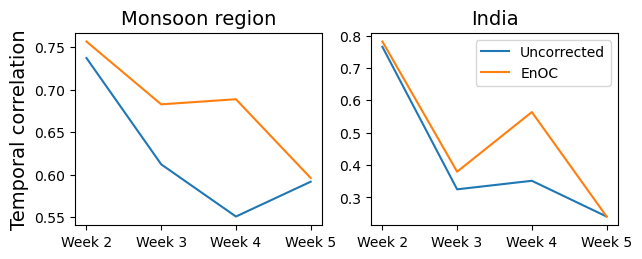

In [96]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5), sharex=True, sharey=False)
axs=axs.flatten()

axs[0].plot(["Week 2", "Week 3", "Week 4", "Week 5"], bars_uncorr1, label='Uncorrected')
axs[0].plot(["Week 2", "Week 3", "Week 4", "Week 5"], bars_corr1, label='EnOC')

axs[0].set_title('Monsoon region', fontsize=14)

axs[1].plot(["Week 2", "Week 3", "Week 4", "Week 5"], bars_uncorr2, label='Uncorrected')
axs[1].plot(["Week 2", "Week 3", "Week 4", "Week 5"], bars_corr2, label='EnOC')

axs[1].set_title('India', fontsize=14)
axs[0].set_ylabel("Temporal correlation", fontsize=14)
axs[1].legend()

plt.savefig("tcorr_weeks.pdf")

In [97]:
numpy.array(bars_uncorr1) - numpy.array(bars_corr1)

array([-0.01942146, -0.07056734, -0.1379577 , -0.00440115])

In [99]:
numpy.array(bars_uncorr2) - numpy.array(bars_corr2)

array([-1.64291859e-02, -5.44452308e-02, -2.12296542e-01, -2.02299172e-04])

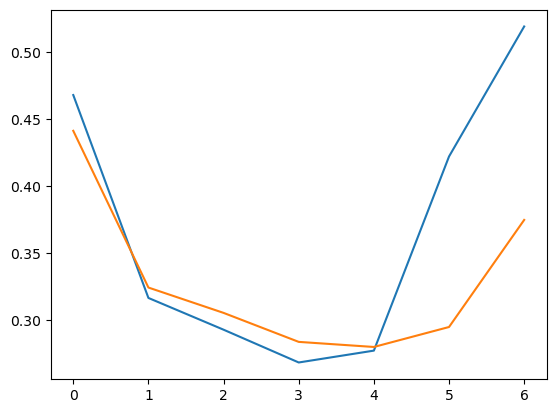

In [42]:
plt.plot(numpy.tanh(corr_sum[11-7:18-7]))
plt.plot(numpy.tanh(uncorr_sum[11-7:18-7]))

In [ ]:
1-7 7-14 14-21 21-28

In [25]:
uncorr_sum

array([1.16935059, 1.2441592 , 1.05640521, 0.72440108, 0.47354183,
       0.33637371, 0.31540657, 0.29174162, 0.28761826, 0.30383969,
       0.39380868, 0.4327228 , 0.4167682 , 0.36214217, 0.25241978,
       0.26949877, 0.38251254, 0.4925671 , 0.39423194, 0.24211493,
       0.24978616])

In [560]:
corr_sum = numpy.zeros((9, 30-9))
uncorr_sum = numpy.zeros((9, 30-9))
#corr_sum = numpy.zeros((9))
#uncorr_sum = numpy.zeros((9))

for month in range(7, 10):
    for year in range(9):
        uncorr = numpy.array([(avg_uncorr[month][lead_time][year].mean(axis=0) + seas5_clim.isel(dayofyear=month-5, forecast_time=lead_time).values).mean() for lead_time in range(9, 30)])
        corr = numpy.array([(avg_corr[month][lead_time][year].mean(axis=0) + seas5_clim.isel(dayofyear=month-5, forecast_time=lead_time).values).mean() for lead_time in range(9, 30)])
        obs = numpy.array([(avg_obs[month][lead_time][year] + seas5_clim.isel(dayofyear=month-5, forecast_time=lead_time).values).mean() for lead_time in range(9, 30)])

        corr_sum[year, :] += (numpy.cumsum(corr) - numpy.cumsum(obs))**2/9
        uncorr_sum[year, :] += (numpy.cumsum(uncorr) - numpy.cumsum(obs))**2/9
#        corr_sum[year] += numpy.corrcoef(corr, obs)[0, 1]
#        uncorr_sum[year] += numpy.corrcoef(uncorr, obs)[0, 1]

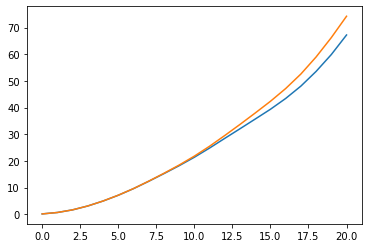

In [561]:
plt.plot(numpy.mean(corr_sum, axis=0))
plt.plot(numpy.mean(uncorr_sum, axis=0))

In [533]:
numpy.ravel([avg_obs[9][l] for l in range(9, 30)]).std()/numpy.ravel([avg_uncorr[9][l] for l in range(9, 30)]).std()

1.1031256

In [528]:
numpy.ravel([avg_uncorr[8][l] for l in range(9, 30)]).std()

3.7256255

In [481]:
corr_sum - uncorr_sum

array([-0.00092029,  0.75915863,  0.06627473,  0.08992896, -0.01146048,
        0.33908365,  0.16250145,  0.08978309,  0.5558942 ])

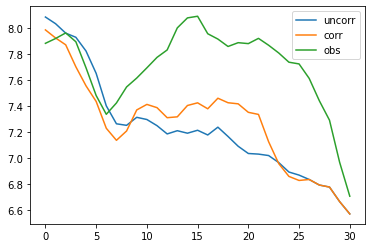

In [535]:
plt.plot(uncorr)
plt.plot(corr)
plt.plot(obs)
plt.legend(["uncorr", "corr", "obs"])

In [465]:
all_corrs = []
all_uncorrs = []
all_obs = []

for lead_time in range(9, 30):
    for month in range(7, 10):
        corr = [y.mean(axis=0).sum() for y in avg_corr[month][lead_time]]
        uncorr = [y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]]
        obs = [y.sum() for y in avg_obs[month][lead_time]]

        all_corrs.append(corr)
        all_uncorrs.append(uncorr)
        all_obs.append(obs)

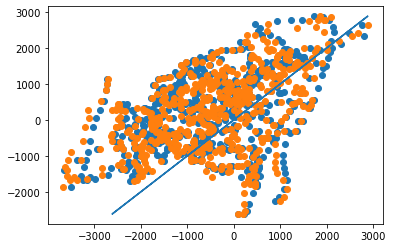

In [466]:
plt.scatter( numpy.ravel(all_uncorrs)*2, numpy.ravel(all_obs),)
plt.scatter(numpy.ravel(all_corrs)*2, numpy.ravel(all_obs))
plt.plot(numpy.ravel(all_obs), numpy.ravel(all_obs))

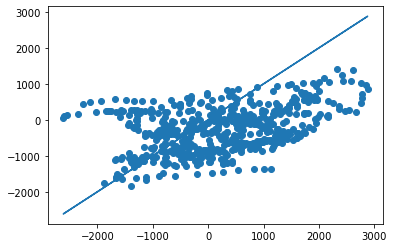

In [467]:
plt.scatter(numpy.ravel(all_obs), numpy.ravel(all_uncorrs))
plt.plot(numpy.ravel(all_obs), numpy.ravel(all_obs))

In [469]:
numpy.corrcoef(numpy.ravel(all_uncorrs), numpy.ravel(all_obs))#, numpy.corrcoef(all_uncorrs, all_obs), 

array([[1.        , 0.40135862],
       [0.40135862, 1.        ]])

In [62]:
list(zip(range(10, 31), -uncorr_sum+corr_sum))

[(10, -0.012585966372347324),
 (11, -0.007136418216972196),
 (12, -0.0016486821269705576),
 (13, -0.017841243561471654),
 (14, -0.012888735614855706),
 (15, -0.023638072485314576),
 (16, -0.01728914907093415),
 (17, 0.002581061986164812),
 (18, 0.025856714572471073),
 (19, 0.04466568901649226),
 (20, 0.06343738052381442),
 (21, 0.07290048904616242),
 (22, 0.09041864014492185),
 (23, 0.06636288952337421),
 (24, 0.054472510623034265),
 (25, 0.030495150451049113),
 (26, 0.023684546043729715),
 (27, 0.020997841423438413),
 (28, 0.03138461576227303),
 (29, 0.04903796806648364),
 (30, 0.0007946723785282606)]

In [33]:
month = 9
tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values.sum() for y in all_res_corr[month][lead_time]], [y.sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 25)]
tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values.sum() for y in all_res_uncorr[month][lead_time]], [y.sum() for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in range(10, 25)]
cross_corr = [numpy.corrcoef([y.mean('ensemble').values.sum() for y in all_res_uncorr[month][lead_time]], [y.mean('ensemble').values.sum() for y in all_res_corr[month][lead_time]])[0, 1] for lead_time in range(10, 25)]

In [34]:
tcorr_corr

[0.7853348158266359,
 0.7275446270117828,
 0.7027680196350803,
 0.6886939011942043,
 0.6675802986436433,
 0.563934069763434,
 0.5457039106986767,
 0.4728445599593202,
 0.40850009892177586,
 0.20876133927142987,
 0.05637846415094838,
 -0.1151437932938442,
 -0.2823104009239104,
 -0.4451351359134164,
 -0.5348098335920018]

In [35]:
tcorr_corr[10], tcorr_uncorr[10]

(0.05637846415094838, 0.06724261601257629)

In [47]:
cross_corr[10]

0.9844732613942697

In [25]:
range(10, 30)[10]

20

In [42]:
tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values.sum() for month in range(7, 10) for y in all_res_corr[month][lead_time]], [y.sum() for month in range(7, 10) for y in all_res_obs[month][lead_time] ])[0, 1] for lead_time in [13, 20, 27]]
tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values.sum() for month in range(7, 10) for y in all_res_uncorr[month][lead_time]], [y.sum() for month in range(7, 10) for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in [13, 20, 27]]
cross_corr = [numpy.corrcoef([y.mean('ensemble').values.sum() for month in range(7, 10) for y in all_res_uncorr[month][lead_time]], [y.mean('ensemble').values.sum() for month in range(7, 10) for y in all_res_corr[month][lead_time]])[0, 1] for lead_time in [13, 20, 27]]

In [44]:
tcorr_corr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for month in range(7, 10) for y in all_res_corr[month][lead_time]], [y[mask_lowres].sum() for month in range(7, 10) for y in all_res_obs[month][lead_time] ])[0, 1] for lead_time in [13, 20, 27]]
tcorr_uncorr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for month in range(7, 10) for y in all_res_uncorr[month][lead_time]], [y[mask_lowres].sum() for month in range(7, 10) for y in all_res_obs[month][lead_time]])[0, 1] for lead_time in [13, 20, 27]]
cross_corr = [numpy.corrcoef([y.mean('ensemble').values[mask_lowres].sum() for month in range(7, 10) for y in all_res_uncorr[month][lead_time]], [y.mean('ensemble').values[mask_lowres].sum() for month in range(7, 10) for y in all_res_corr[month][lead_time]])[0, 1] for lead_time in [13, 20, 27]]

In [45]:
tcorr_corr, tcorr_uncorr, cross_corr

([0.5119589533789954, 0.3341923317638964, -0.07044484981296688],
 [0.5123967643115213, 0.2739835475354021, -0.09554732241126115],
 [0.983539859344697, 0.9650234328019616, 0.997120065244964])

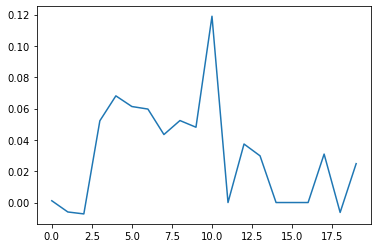

In [266]:
plt.plot(numpy.array(tcorr_corr) - numpy.array(tcorr_uncorr))

In [231]:
13+10

23

In [82]:
seas5_anomalies.lon

<xarray.DataArray 'lon' (lon: 35)>
array([ 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
Attributes:
    La1:        39.0
    Lo1:        66.0
    La2:        6.0
    Lo2:        100.0
    Di:         1.0
    Dj:         1.0
    units:      degrees_east
    GridType:   Cylindrical Equidistant Projection Grid
    long_name:  longitude

In [145]:
month = 8
lead_time = 21

In [146]:
corrs_corr = {}
corrs_uncorr = {}

for region in regions:
    ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]])
    ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_uncorr[month][lead_time]])
    observations = numpy.array([y[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_obs[month][lead_time]])
    corrs_corr[region] = numpy.corrcoef(ensembles_corr, observations)[0, 1]
    corrs_uncorr[region] = numpy.corrcoef(ensembles_uncorr, observations)[0, 1]

In [162]:
state_data["st_nm"].isnull()

0      False
1      False
2       True
3      False
4      False
       ...  
311     True
312     True
313     True
314     True
315     True
Name: st_nm, Length: 316, dtype: bool

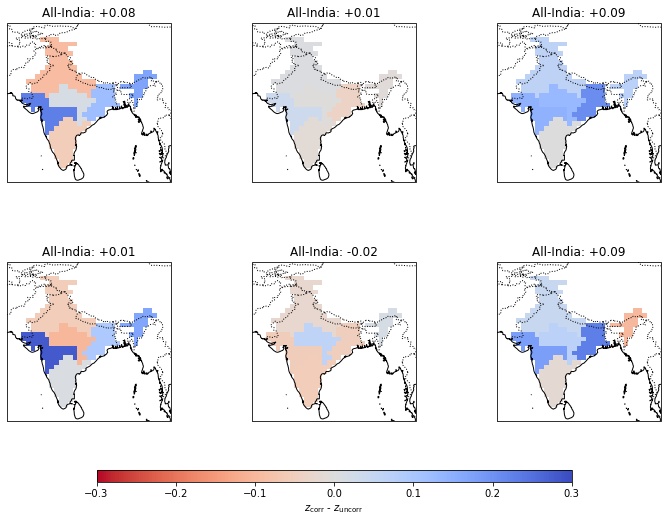

In [277]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(nrows=2, ncols=3,
                        subplot_kw={'projection': ccrs.LambertCylindrical()},
                        figsize=(11, 8.5))
axs=axs.T.flatten()
i = 0
for month in range(7, 10):
    for lead_time in [13, 15]:
        #plt.subplot(3, 2, i)
        corrs_corr = {}
        corrs_uncorr = {}

        for region in regions:
            ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]])
            ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_uncorr[month][lead_time]])
            observations = numpy.array([y[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_obs[month][lead_time]])
            corrs_corr[region] = numpy.corrcoef(ensembles_corr, observations)[0, 1]
            corrs_uncorr[region] = numpy.corrcoef(ensembles_uncorr, observations)[0, 1]
        
        #ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_corr[month][lead_time]])
        #ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_uncorr[month][lead_time]])
        #observations = numpy.array([y[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_obs[month][lead_time]])
        #corrs_corr['null'] = numpy.corrcoef(ensembles_corr, observations)[0, 1]
        #corrs_uncorr['null'] = numpy.corrcoef(ensembles_uncorr, observations)[0, 1]

        ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_corr[month][lead_time]])
        ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_uncorr[month][lead_time]])
        observations = numpy.array([y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])
        diff = numpy.round(numpy.arctanh(numpy.corrcoef(ensembles_corr, observations)[0, 1]) - numpy.arctanh(numpy.corrcoef(ensembles_uncorr, observations)[0, 1]), 2)
        if str(diff) == '-0.0':
            diff = '0.0'
        elif str(diff)[0] != '-':
            diff = '+' + str(diff)
        
        axs[i].set_title('All-India: ' + str(diff))

        dat = state_data["st_nm"].copy()
        for region in regions:
            dat[dat == region] = numpy.arctanh(corrs_corr[region]) - numpy.arctanh(corrs_uncorr[region])
        
        m = numpy.zeros(lowres_lons.shape)*numpy.nan
        m[mask_lowres] = dat
        #m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
        #ax = plt.axes(projection=ccrs.PlateCarree())

        cs = axs[i].pcolormesh(lowres_lons, lowres_lats, m, cmap='coolwarm_r', vmin=-0.3, vmax=0.3)
        axs[i].coastlines()
        axs[i].add_feature(cfeature.BORDERS, linestyle=':')

        #plt.colorbar()
        i += 1

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label="$z_\\mathrm{corr}$ - $z_\\mathrm{uncorr}$")

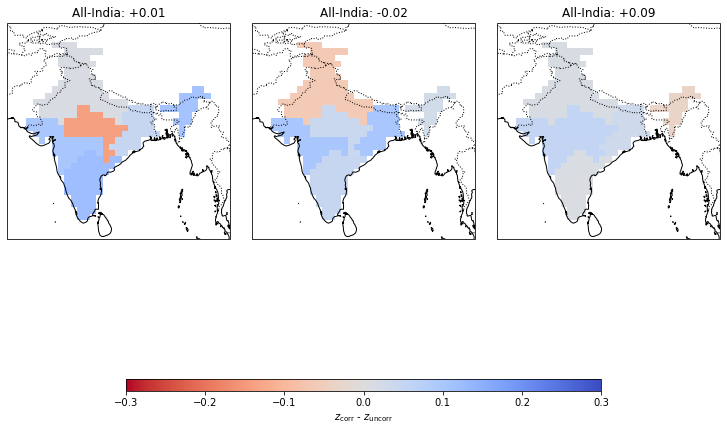

In [113]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(nrows=1, ncols=3,
                        subplot_kw={'projection': ccrs.LambertCylindrical()},
                        figsize=(11, 8.5))
axs=axs.T.flatten()
i = 0
for month in range(7, 10):
    #plt.subplot(3, 2, i)
    corrs_corr = {}
    corrs_uncorr = {}

    for region in regions:
        ensembles_corr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]] for lead_time in range(13, 28)]),
                                   axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_uncorr[month][lead_time]] for lead_time in range(13, 28)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_obs[month][lead_time]] for lead_time in range(13, 28)]),
                                 axis=0)
        corrs_corr[region] = numpy.corrcoef(ensembles_corr, observations)[0, 1]
        corrs_uncorr[region] = numpy.corrcoef(ensembles_uncorr, observations)[0, 1]

    #ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_corr[month][lead_time]])
    #ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_uncorr[month][lead_time]])
    #observations = numpy.array([y[mask_lowres][state_data["st_nm"].isnull()].sum() for y in all_res_obs[month][lead_time]])
    #corrs_corr['null'] = numpy.corrcoef(ensembles_corr, observations)[0, 1]
    #corrs_uncorr['null'] = numpy.corrcoef(ensembles_uncorr, observations)[0, 1]

    ensembles_corr = numpy.array([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_corr[month][lead_time]])
    ensembles_uncorr = numpy.array([y.mean('ensemble').values[mask_lowres].sum() for y in all_res_uncorr[month][lead_time]])
    observations = numpy.array([y[mask_lowres].sum() for y in all_res_obs[month][lead_time]])
    diff = numpy.round(numpy.arctanh(numpy.corrcoef(ensembles_corr, observations)[0, 1]) - numpy.arctanh(numpy.corrcoef(ensembles_uncorr, observations)[0, 1]), 2)
    if str(diff) == '-0.0':
        diff = '0.0'
    elif str(diff)[0] != '-':
        diff = '+' + str(diff)

    axs[i].set_title('All-India: ' + str(diff))

    dat = state_data["st_nm"].copy()
    for region in regions:
        dat[dat == region] = (corrs_corr[region]) - (corrs_uncorr[region])

    m = numpy.zeros(lowres_lons.shape)*numpy.nan
    m[mask_lowres] = dat
    #m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
    #ax = plt.axes(projection=ccrs.PlateCarree())

    cs = axs[i].pcolormesh(lowres_lons, lowres_lats, m, cmap='coolwarm_r', vmin=-0.3, vmax=0.3)
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS, linestyle=':')

    #plt.colorbar()
    i += 1

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label="$z_\\mathrm{corr}$ - $z_\\mathrm{uncorr}$")

In [42]:
def remappedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, 
name='shiftedcmap'):
    '''
    Function to offset the median value of a colormap, and scale the
    remaining color range. Useful for data with a negative minimum and
    positive maximum where you want the middle of the colormap's dynamic
    range to be at zero.
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 0.5; if your dataset mean is negative you should leave 
          this at 0.0, otherwise to (vmax-abs(vmin))/(2*vmax) 
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0; usually the
          optimal value is abs(vmin)/(vmax+abs(vmin)) 
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.5 and 1.0; if your dataset mean is positive you should leave 
          this at 1.0, otherwise to (abs(vmin)-vmax)/(2*abs(vmin)) 
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.hstack([
        np.linspace(start, 0.5, 128, endpoint=False), 
        np.linspace(0.5, stop, 129)
    ])

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [43]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib

vmin = -0.05
vmax = 0.2

np = numpy
cmap = matplotlib.colormaps['RdBu']
cmap = ListedColormap(cmap(np.linspace(0.2, 0.8, 256)))
cmap = remappedColorMap(cmap, start=(vmax-abs(vmin))/(2*vmax), midpoint=abs(vmin)/(vmax+abs(vmin)), stop=1.0, name='shrunk')
#levels = numpy.linspace(vmin, vmax, 17)

/tmp/ipykernel_55353/2596916599.py:51: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

corrs_corr = dict((region, 0) for region in regions)
corrs_uncorr = dict((region, 0) for region in regions)
for month in range(7, 10):
    #plt.subplot(3, 2, i)

    for region in regions:
        ensembles_corr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]] for lead_time in range(13, 20)]),
                                   axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_uncorr[month][lead_time]] for lead_time in range(13, 20)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_obs[month][lead_time]] for lead_time in range(13, 20)]),
                                 axis=0)
        corrs_corr[region] += numpy.corrcoef(ensembles_corr, observations)[0, 1]/3
        corrs_uncorr[region] += numpy.corrcoef(ensembles_uncorr, observations)[0, 1]/3

fig, axs = plt.subplots(nrows=1, ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11, 8.5))
axs=axs.T.flatten()

import cmocean

dat = state_data["st_nm"].copy()
for region in regions:
    dat[dat == region] = (corrs_corr[region]) - (corrs_uncorr[region])
    print(region, (corrs_corr[region]) - (corrs_uncorr[region]))

m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
#m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
#ax = plt.axes(projection=ccrs.PlateCarree())

#z = m[:-1, :-1]
#levels = MaxNLocator(nbins=50).tick_values(-numpy.nanmax(z) - 0.2, numpy.nanmax(z) + 0.2)


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
#cmap = cmocean.cm.balance_r
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#ax = plt.axes(projection=ccrs.LambertCylindrical())
cs = axs[0].pcolormesh(lowres_lons, lowres_lats, m, cmap=cmap, vmin=vmin, vmax=vmax)#, norm=divnorm)
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')

axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']+0.4), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].set_title('Weeks 3–4', fontsize=20)

corrs_corr = dict((region, 0) for region in regions)
corrs_uncorr = dict((region, 0) for region in regions)
for month in range(7, 10):
    #plt.subplot(3, 2, i)

    for region in regions:
        ensembles_corr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]] for lead_time in range(20, 27)]),
                                   axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_uncorr[month][lead_time]] for lead_time in range(20, 27)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_obs[month][lead_time]] for lead_time in range(20, 27)]),
                                 axis=0)
        corrs_corr[region] += numpy.corrcoef(ensembles_corr, observations)[0, 1]/3
        corrs_uncorr[region] += numpy.corrcoef(ensembles_uncorr, observations)[0, 1]/3

dat = state_data["st_nm"].copy()
for region in regions:
    dat[dat == region] = (corrs_corr[region]) - (corrs_uncorr[region])
    print(region, (corrs_corr[region]) - (corrs_uncorr[region]))

m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
#m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
#ax = plt.axes(projection=ccrs.PlateCarree())

#ax = plt.axes(projection=ccrs.LambertCylindrical())
cs = axs[1].pcolormesh(lowres_lons, lowres_lats, m, cmap=cmap, vmin=vmin, vmax=vmax)#, norm=divnorm)
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')

axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']+0.4), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].set_title('Weeks 4–5', fontsize=20)

# m2 = numpy.zeros(lowres_lons.shape)
# dat = state_data["st_nm"].copy()
# dat[dat != 'South'] = 0
# dat[dat == 'South'] = 1
# m2[mask_lowres] = dat.values
# plt.pcolor(lowres_lons, lowres_lats, ma.masked_array(m2, mask=m2), facecolor='red')

#fig.colorbar(boundaries=numpy.linspace(-0.015, 0.085, 21))
import matplotlib as mpl
#norm = mpl.colors.BoundaryNorm(boundaries=[-0.015, 0.085], ncolors=50)
#mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
#                                norm=norm,
#                                orientation='horizontal')
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal',
                  ticks=sorted(numpy.concatenate([numpy.arange(-0.015, 0.085 + 0.01, 0.01), [0]])))
cbar.ax.set_xticklabels(['-0.015', '-0.005', '', '0.005', '0.015', '0.025', '0.035', '0.045', '0.055', '0.065', '0.075', '0.085'])
cbar.set_label("$r_\\mathrm{corr}$ - $r_\\mathrm{uncorr}$", size=20)
#cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(labelsize=12)
#plt.savefig("tcorr_spatial_panel.pdf")

NameError: name 'regions' is not defined

In [24]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

corrs_corr = dict((region, 0) for region in regions)
corrs_uncorr = dict((region, 0) for region in regions)
for month in range(7, 10):
    #plt.subplot(3, 2, i)

    for region in regions:
        ensembles_corr = numpy.sum(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_corr[month][lead_time]] for lead_time in range(13, 20)]),
                                   axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_uncorr[month][lead_time]] for lead_time in range(13, 20)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_obs[month][lead_time]] for lead_time in range(13, 20)]),
                                 axis=0)
        corrs_corr[region] += numpy.arctanh(numpy.corrcoef(ensembles_corr, observations)[0, 1])/3
        corrs_uncorr[region] += numpy.arctanh(numpy.corrcoef(ensembles_uncorr, observations)[0, 1])/3

fig, axs = plt.subplots(nrows=1, ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11, 8.5))
axs=axs.T.flatten()

import cmocean

dat = state_data["st_nm"].copy()
for region in regions:
    dat[dat == region] = numpy.tanh(corrs_corr[region]) - numpy.tanh(corrs_uncorr[region])
    print(region, numpy.tanh(corrs_corr[region]) - numpy.tanh(corrs_uncorr[region]))

m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
#m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
#ax = plt.axes(projection=ccrs.PlateCarree())

#z = m[:-1, :-1]
#levels = MaxNLocator(nbins=50).tick_values(-numpy.nanmax(z) - 0.2, numpy.nanmax(z) + 0.2)


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
#cmap = cmocean.cm.balance_r
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#ax = plt.axes(projection=ccrs.LambertCylindrical())
cs = axs[0].pcolormesh(lowres_lons, lowres_lats, m, cmap=cmap, vmin=vmin, vmax=vmax)#, norm=divnorm)
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')

axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']+0.4), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[0].set_title('Days 14–20', fontsize=20)

corrs_corr = dict((region, 0) for region in regions)
corrs_uncorr = dict((region, 0) for region in regions)
for month in range(7, 10):
    #plt.subplot(3, 2, i)

    for region in regions:
        ensembles_corr = numpy.sum(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_corr[month][lead_time]] for lead_time in range(20, 27)]),
                                   axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_uncorr[month][lead_time]] for lead_time in range(20, 27)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y[mask_lowres][state_data["st_nm"] == region].sum() for y in avg_obs[month][lead_time]] for lead_time in range(20, 27)]),
                                 axis=0)
        corrs_corr[region] += numpy.arctanh(numpy.corrcoef(ensembles_corr, observations)[0, 1])/3
        corrs_uncorr[region] += numpy.arctanh(numpy.corrcoef(ensembles_uncorr, observations)[0, 1])/3

dat = state_data["st_nm"].copy()
for region in regions:
    dat[dat == region] = numpy.tanh(corrs_corr[region]) - numpy.tanh(corrs_uncorr[region])
    print(region, numpy.tanh(corrs_corr[region]) - numpy.tanh(corrs_uncorr[region]))

m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
#m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
#ax = plt.axes(projection=ccrs.PlateCarree())

#ax = plt.axes(projection=ccrs.LambertCylindrical())
cs = axs[1].pcolormesh(lowres_lons, lowres_lats, m, cmap=cmap, vmin=vmin, vmax=vmax)#, norm=divnorm)
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')

axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']+0.4), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
axs[1].set_title('Days 21–27', fontsize=20)

# m2 = numpy.zeros(lowres_lons.shape)
# dat = state_data["st_nm"].copy()
# dat[dat != 'South'] = 0
# dat[dat == 'South'] = 1
# m2[mask_lowres] = dat.values
# plt.pcolor(lowres_lons, lowres_lats, ma.masked_array(m2, mask=m2), facecolor='red')

#fig.colorbar(boundaries=numpy.linspace(-0.015, 0.085, 21))
import matplotlib as mpl
#norm = mpl.colors.BoundaryNorm(boundaries=[-0.015, 0.085], ncolors=50)
#mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
#                                norm=norm,
#                                orientation='horizontal')
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal',
                  ticks=sorted(numpy.concatenate([numpy.arange(vmin, vmax + 0.01, 0.05), [0]])))
#cbar.ax.set_xticklabels(['-0.015', '-0.005', '', '0.005', '0.015', '0.025', '0.035', '0.045', '0.055', '0.065', '0.075', '0.085'])
cbar.set_label("$r_\\mathrm{corr}$ - $r_\\mathrm{uncorr}$", size=20)
#cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(labelsize=12)
#plt.savefig("tcorr_spatial_panel4.pdf")

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: lat

/tmp/ipykernel_239073/2596916599.py:51: UserWarning: Trying to register the cmap 'shrunk2' which already exists.
  plt.register_cmap(cmap=newcmap)


South 0.09325285805079409
North -0.009783331172117382
East 0.04897878988666804
West 0.1886086049537843
Northeast 0.027957889279742076
Central 0.008630782150772731


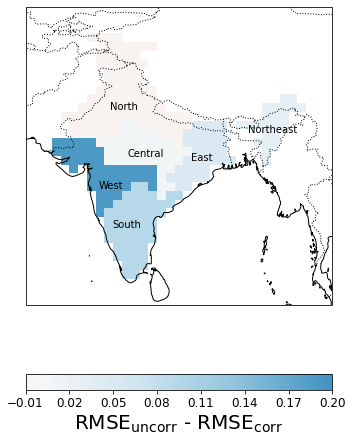

In [226]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib

vmin = -0.01
vmax = 0.2

np = numpy
cmap = matplotlib.colormaps['RdBu']
cmap = ListedColormap(cmap(np.linspace(0.2, 0.8, 256)))
cmap = remappedColorMap(cmap, start=(vmax-abs(vmin))/(2*vmax), midpoint=abs(vmin)/(vmax+abs(vmin)), stop=1.0, name='shrunk2')
#levels = numpy.linspace(vmin, vmax, 17)

rmse_corr = dict((region, 0) for region in regions)
rmse_uncorr = dict((region, 0) for region in regions)
stds = dict((region, 0) for region in regions)

for month in range(7, 10):
    #plt.subplot(3, 2, i)
    for region in regions:
        ensembles_corr = numpy.mean(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region] for y in avg_corr[month][lead_time]] for lead_time in range(9, 35)]), axis=0)
        ensembles_uncorr = numpy.mean(numpy.array([[y.mean(axis=0)[mask_lowres][state_data["st_nm"] == region] for y in avg_uncorr[month][lead_time]] for lead_time in range(9, 35)]), axis=0)
        observations = numpy.mean(numpy.array([[y[mask_lowres][state_data["st_nm"] == region] for y in avg_obs[month][lead_time]] for lead_time in range(9, 35)]), axis=0)
        rmse_corr[region] += numpy.mean((ensembles_corr - observations)**2)/3
        rmse_uncorr[region] += numpy.mean((ensembles_uncorr - observations)**2)/3
        stds[region] += numpy.std(observations)/3

dat = state_data["st_nm"].copy()
for region in regions:
    dat[dat == region] = numpy.sqrt(rmse_uncorr[region]) - numpy.sqrt(rmse_corr[region])
    print(region, numpy.sqrt(rmse_uncorr[region]) - numpy.sqrt(rmse_corr[region]))

m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
#m[~mask_lowres] = corrs_corr['null'] - corrs_uncorr['null']
#ax = plt.axes(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(nrows=1, ncols=1,
                        subplot_kw={'projection': ccrs.LambertCylindrical()},
                        figsize=(5.5, 8.5))

#ax = plt.axes(projection=ccrs.LambertCylindrical())
cs = ax.pcolormesh(lowres_lons, lowres_lats, m, cmap=cmap, vmin=vmin, vmax=vmax)#, norm=divnorm)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
ax.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']+0.4), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
fig = plt.gcf()
cbar=fig.colorbar(cs, orientation='horizontal',
                  ticks=sorted(numpy.concatenate([numpy.arange(vmin, vmax + 0.01, 0.03), []])))
#cbar.ax.set_xticklabels(['-0.015', '-0.005', '', '0.005', '0.015', '0.025', '0.035', '0.045', '0.055', '0.065', '0.075', '0.085'])
cbar.set_label("$\mathrm{RMSE}_\\mathrm{uncorr}$ - $\mathrm{RMSE}_\\mathrm{corr}$", size=20)
#cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(labelsize=12)

#ax.set_title('Days 21–27', fontsize=20)

In [182]:
[rmse_uncorr[region] - rmse_corr[region] for region in regions]

[0.6629152297973651,
 -0.08373403549194158,
 0.20264116923014264,
 1.9301312764485665,
 0.10032717386881274,
 0.008263270060222538]

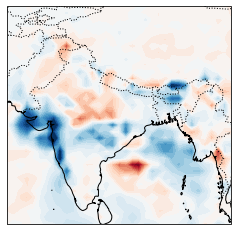

In [134]:
ax = plt.axes(projection=ccrs.LambertCylindrical())

ax.contourf(lowres_lons, lowres_lats, numpy.sqrt(rmse_uncorr) - numpy.sqrt(rmse_corr), 40, vmin=-1, vmax=1, cmap="RdBu")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

In [115]:
numpy.max(numpy.sqrt(rmse_uncorr) - numpy.sqrt(rmse_corr))

0.7296413266523611

In [42]:
avg_corr[month][lead_time][0].shape

(25, 34, 35)

In [64]:
corrs_corr['North'] - corrs_uncorr['North']

0.000391326230152228

In [243]:
ma.masked_array(m2, mask=m2)

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

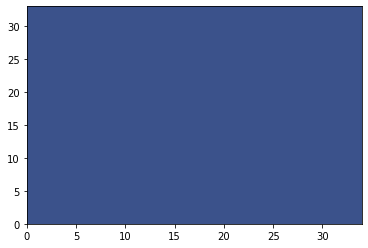

In [212]:
plt.contourf(m2)

In [207]:
dat == 'South'

0      False
1      False
2      False
3      False
4      False
       ...  
311    False
312    False
313    False
314    False
315    False
Name: st_nm, Length: 316, dtype: bool

In [134]:
[(region, (corrs_corr[region]) - (corrs_uncorr[region])) for region in regions]

[('South', 0.05860981966712009),
 ('North', -0.013033048264291164),
 ('East', 0.06037028491044227),
 ('West', 0.08384647787752153),
 ('Northeast', 0.03371050657949326),
 ('Central', -0.015055950433020493)]

In [132]:
regions

['South', 'North', 'East', 'West', 'Northeast', 'Central']

In [108]:
            ensembles_corr = numpy.sum(numpy.array([[y.mean('ensemble').values[mask_lowres][state_data["st_nm"] == region].sum() for y in all_res_corr[month][lead_time]] for lead_time in range(13, 28)]),
                                       axis=0)

In [109]:
ensembles_corr

array([   72.50965,  1515.2827 ,   -85.10237,   170.93488, -1033.1652 ,
        1514.3646 ,   731.75555, -1333.2633 , -2087.8494 ], dtype=float32)

In [101]:
numpy.sum(ensembles_corr, axis=0)

array([  138.6437 , -1377.168  ,   357.6343 ,   601.0443 ,   233.30286,
        -278.3545 ,   263.2605 , -1456.4207 ,  -190.36389], dtype=float32)

In [243]:
corrs_corr

{'South': -0.31573965704138535,
 'North': 0.2524467287062714,
 'East': 0.13237215883564593,
 'West': 0.3376256820634797,
 'Northeast': 0.5855185561834577,
 'Central': 0.47775820716379686}

In [218]:
numpy.round

<function numpy.round_(a, decimals=0, out=None)>

In [144]:
corrs_corr, corrs_uncorr

({'South': 0.3158866475592922,
  'North': -0.04475761429687114,
  'East': 0.3492415492292441,
  'West': 0.4674708082389551,
  'Northeast': 0.5222744084996793,
  'Central': 0.45596541988125827},
 {'South': 0.15194471299249934,
  'North': -0.2102289104048516,
  'East': 0.47934426919914236,
  'West': 0.5176417783234776,
  'Northeast': 0.3754937446109039,
  'Central': 0.6659643257797093})

In [146]:
map_corr = numpy.zeros((34, 35))
map_uncorr = numpy.zeros((34, 35))

for i in range(34):
    print(i)
    for j in range(35):
        ensembles_corr = numpy.sum(numpy.array([[y.mean('ensemble').values for y in all_res_corr[month][lead_time]] for lead_time in range(13, 28)]),
                           axis=0)
        ensembles_uncorr = numpy.sum(numpy.array([[y.mean('ensemble').values for y in all_res_uncorr[month][lead_time]] for lead_time in range(13, 28)]),
                                   axis=0)
        observations = numpy.sum(numpy.array([[y for y in all_res_obs[month][lead_time]] for lead_time in range(13, 28)]),
                                 axis=0)
        map_corr[i, j] = numpy.corrcoef(ensembles_corr[:, i, j], observations[:, i, j])[0,1]
        map_uncorr[i, j] = numpy.corrcoef(ensembles_uncorr[:, i, j], observations[:, i, j])[0,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


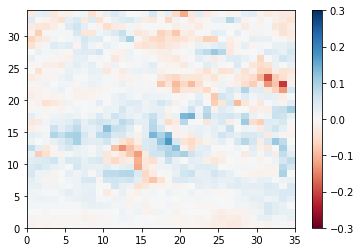

In [153]:
plt.pcolormesh(map_corr - map_uncorr, cmap='RdBu', vmax=0.3, vmin=-0.3)
plt.colorbar()

In [ ]:
for i in range(34):
    for j in range(35):
        corrs_corr[i, j] = numpy.corrcoef(ensembles_corr[:, i, j], observations[:, i, j])[0,1]
        corrs_uncorr[i, j] = numpy.corrcoef(ensembles_uncorr[:, i, j], observations[:, i, j])[0,1]

In [223]:
state_data["st_nm"] == 'South'

0       True
1       True
2      False
3       True
4       True
       ...  
311    False
312    False
313    False
314    False
315    False
Name: st_nm, Length: 316, dtype: bool

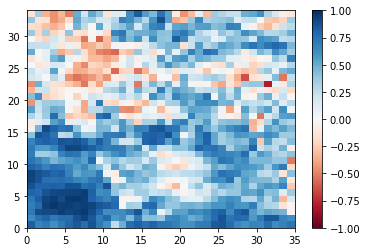

In [202]:
plt.pcolormesh(corrs_corr, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()

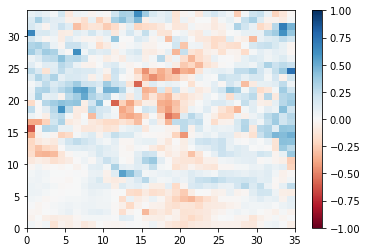

In [209]:
plt.pcolormesh(corrs_corr - corrs_uncorr, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()

In [208]:
numpy.mean(corrs_corr - corrs_uncorr)

0.033659032011019045

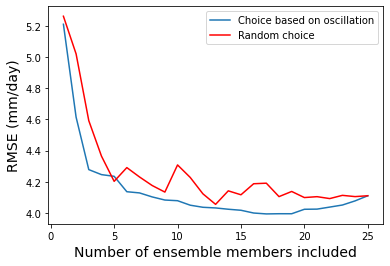

In [731]:
plt.plot(range(1, 26), numpy.mean(numpy.array(opt_mps[15:]), axis=0), label="Choice based on oscillation")
plt.plot(range(1, 26), numpy.mean(numpy.array(rand_mps[15:]), axis=0), c="red", label="Random choice")
plt.legend()
plt.ylabel("RMSE (mm/day)", fontsize=14)
plt.xlabel("Number of ensemble members included", fontsize=14)
plt.savefig("opt_mp.pdf")

In [237]:
all_res_clim[7][15][0]['rmse'], all_res_corr[7][15][0]['rmse']

(3.776031, 2.9546115)

In [17]:
rmse_corr = []
rmse_uncorr = []
rmse_clim = []

for month in range(7, 8):
    for lead_time in range(20, 21):
        #rmse_corr.append(numpy.corrcoef(numpy.hstack([[r['mean_prec'] for r in all_res_corr[7][lead_time]], [r['mean_prec'] for r in all_res_corr[8][lead_time]]]),
        #                                numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead_time]], [r['mean_prec'] for r in all_res_obs[8][lead_time]]]))[0, 1])
        #rmse_uncorr.append(numpy.corrcoef(numpy.hstack([[r['mean_prec'] for r in all_res_uncorr[7][lead_time]], [r['mean_prec'] for r in all_res_uncorr[8][lead_time]]]),
        #                                  numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead_time]], [r['mean_prec'] for r in all_res_obs[8][lead_time]]]))[0, 1])
        #rmse_corr.append(numpy.corrcoef([r['mean_prec'] for r in all_res_corr[month][lead_time]],
        #                                [r['mean_prec'] for r in all_res_obs[month][lead_time]])[0, 1])
        #rmse_uncorr.append(numpy.corrcoef([r['mean_prec'] for r in all_res_uncorr[month][lead_time]],
        #                                  [r['mean_prec'] for r in all_res_obs[month][lead_time]])[0, 1])

        rmse_corr.append(numpy.mean([r['corr'] for r in numpy.hstack([all_res_corr[month][lead_time]])]))
        rmse_uncorr.append(numpy.mean([r['corr'] for r in numpy.hstack([all_res_uncorr[month][lead_time]])]))
        rmse_clim.append(numpy.mean([r['corr'] for r in numpy.hstack([all_res_clim[month][lead_time]])]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

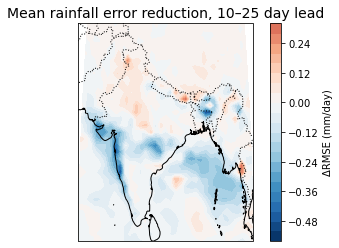

In [1039]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.EqualEarth(central_longitude=83))
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

map_corr = numpy.sqrt(numpy.mean([[[r['diff_map']**2 for r in all_res_corr[month][lead_time]] for month in range(7, 9)] for lead_time in range(10, 26)], axis=(0, 1, 2)))
map_uncorr = numpy.sqrt(numpy.mean([[[r['diff_map']**2 for r in all_res_uncorr[month][lead_time]] for month in range(7, 9)] for lead_time in range(10, 26)], axis=(0, 1, 2)))

dat = map_corr - map_uncorr
#dat[abs(dat) < 0.05] = numpy.nan
plt.contourf(era5_verify_anomalies.lon, era5_verify_anomalies.lat, dat, 25, vmin=numpy.nanmin(dat), vmax=-numpy.nanmin(dat), cmap="RdBu_r",
             transform=ccrs.PlateCarree())
plt.colorbar(label="ΔRMSE (mm/day)")

plt.title("Mean rainfall error reduction, 10–25 day lead", fontsize=14)
plt.savefig("diff_map.pdf")

In [1017]:
maps_corr = numpy.array([[[(r['diff_map']) for r in all_res_corr[month][lead_time]] for month in range(7, 8)] for lead_time in range(10, 25)]).reshape(-1, 34, 35)
maps_uncorr = numpy.array([[[(r['diff_map']) for r in all_res_uncorr[month][lead_time]] for month in range(7, 8)] for lead_time in range(10, 25)]).reshape(-1, 34, 35)

In [994]:
import scipy.stats

In [883]:
import cmocean

In [16]:
plt.plot(range(10, 30), (numpy.array(rmse_uncorr)), label="Raw")
plt.plot(range(10, 30), (numpy.array(rmse_corr)), label="EnOC")
#plt.hlines([0], xmin=10, xmax=29, label="Climatology", color='g')

plt.xlabel("Lead time (days)", fontsize=14)
plt.ylabel("RMSE skill score", fontsize=14)
plt.legend()
plt.title("15-day rainfall, RMSE skill score, July", fontsize=14)
#plt.plot(range(10, 15), rmse_clim)

#plt.savefig("crps_july.pdf")

NameError: name 'rmse_uncorr' is not defined

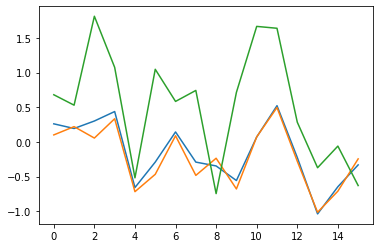

In [561]:
plt.plot(numpy.hstack([[r['mean_prec'] for r in all_res_corr[7][20]], [r['mean_prec'] for r in all_res_corr[8][20]]]))
plt.plot(numpy.hstack([[r['mean_prec'] for r in all_res_uncorr[7][20]], [r['mean_prec'] for r in all_res_uncorr[8][20]]]))
plt.plot(numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][20]], [r['mean_prec'] for r in all_res_obs[8][20]]]))

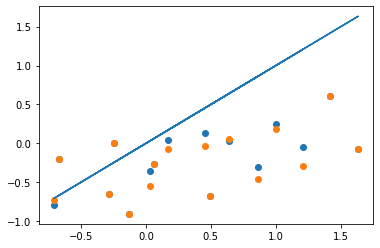

In [571]:
lead = 18

plt.scatter(numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead]], [r['mean_prec'] for r in all_res_obs[8][lead]]]), numpy.hstack([[r['mean_prec'] for r in all_res_corr[7][lead]], [r['mean_prec'] for r in all_res_corr[8][lead]]]))
plt.scatter(numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead]], [r['mean_prec'] for r in all_res_obs[8][lead]]]), numpy.hstack([[r['mean_prec'] for r in all_res_uncorr[7][lead]], [r['mean_prec'] for r in all_res_uncorr[8][lead]]]))
plt.plot(numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead]], [r['mean_prec'] for r in all_res_obs[8][lead]]]), numpy.hstack([[r['mean_prec'] for r in all_res_obs[7][lead]], [r['mean_prec'] for r in all_res_obs[8][lead]]]))

In [159]:
numpy.array(all_errs_corr).mean(axis=1)/numpy.array(all_errs_uncorr).mean(axis=1)

array([0.9732643 , 0.96725905], dtype=float32)

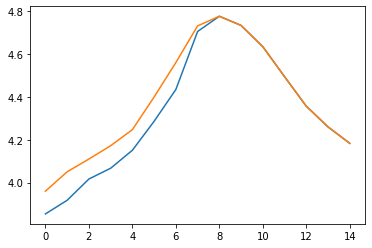

In [47]:
plt.plot([numpy.mean(e[:8]) for e in all_errs_corr[:15]])
plt.plot([numpy.mean(e[:8]) for e in all_errs_uncorr[:15]])

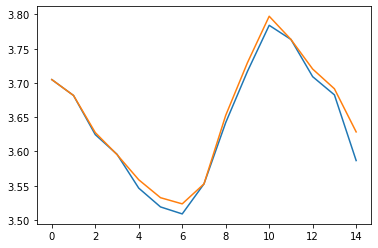

In [68]:
plt.plot([numpy.mean(e[:8]) for e in all_errs_corr[30:]])
plt.plot([numpy.mean(e[:8]) for e in all_errs_uncorr[30:]])

In [20]:
Metrics(ens_corr[0], obs_states[0], metrics).results

IndexError: list index out of range

In [214]:
def run_pc_fcst(year, month, lead_time):
    
    initial_date = datetime.datetime(year=year, month=month, day=day)
    
        #initial_data = numpy.hstack([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values for i in range(-regress_days_past + 1, 1)])
    initial_data = numpy.hstack([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-regress_days + 1, 1)])
    initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    initial_pc_true = pcs2[year - year0, date_days, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k, year=year)

    true_pc = pcs2[year - year0, date_days + lead_time, :]

    fcst_pcs.append(pcs_fcst)
    true_pcs.append(true_pc)

In [102]:
def run_pc_fcst_ssa(year, month, lead_time):
    initial_date = datetime.datetime(year=year, month=month, day=day)

    initial_data = numpy.array([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-M + 1, 1)])
    
    r = reconstruct_ssa(initial_data, M, eig_vecs, [1, 2])
    
    initial_pc = numpy.sum(r, axis=0)@eofs

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    initial_pc_true = pcs2[year - 1901, date_days, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    true_pc = pcs2[year - 1901, date_days + lead_time, :]

    fcst_pcs_ssa.append(pcs_fcst)
    true_pcs_ssa.append(true_pc)

In [32]:
def run_pc_fcst_lasso(year, month, lead_time):
    
    initial_date = datetime.datetime(year=year, month=month, day=day)
    
        #initial_data = numpy.hstack([era5_verify_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values for i in range(-regress_days_past + 1, 1)])
    initial_data = numpy.hstack([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-regress_days + 1, 1)])
    initial_pc = numpy.array(get_pcs_past_lasso(initial_data.reshape(1, -1)))

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    initial_pc_true = pcs2[year - 1901, date_days, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    true_pc = pcs2[year - 1901, date_days + lead_time, :]

    fcst_pcs_lasso.append(pcs_fcst)
    true_pcs_lasso.append(true_pc)

In [215]:
true_pcs = []
fcst_pcs = []

initial_pcs_true = []
initial_pcs = []

all_true = []
all_fcst = []

all_true_ssa = []
all_fcst_ssa = []

for month in range(7, 10):
    for lead_time in range(0, 45):
        print(lead_time)
        true_pcs = []
        fcst_pcs = []
        #true_pcs_ssa = []
        #fcst_pcs_ssa = []
        for year in range(1993, 2008):
            run_pc_fcst(year, month, lead_time)
            #run_pc_fcst_ssa(year, month, lead_time)
        all_true.append(true_pcs)
        all_fcst.append(fcst_pcs)

        #all_true_ssa.append(true_pcs_ssa)
        #all_fcst_ssa.append(fcst_pcs_ssa)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


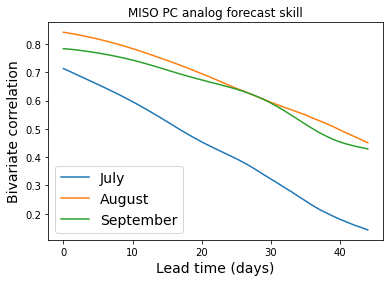

In [217]:
plt.plot([bcorr(numpy.array(all_true[i]), numpy.squeeze(numpy.array(all_fcst[i]))) for i in range(0, 45)], label='July')
plt.plot([bcorr(numpy.array(all_true[i]), numpy.squeeze(numpy.array(all_fcst[i]))) for i in range(45, 90)], label='August')
plt.plot([bcorr(numpy.array(all_true[i]), numpy.squeeze(numpy.array(all_fcst[i]))) for i in range(90, 135)], label='September')
plt.legend(fontsize=14)
plt.xlabel('Lead time (days)', fontsize=14)
plt.ylabel('Bivariate correlation', fontsize=14)
plt.title('MISO PC analog forecast skill')
plt.savefig('analog_forecast_skill.pdf')

In [190]:
all_fcst[45]

[array([[0.17181721, 0.40063736]], dtype=float32),
 array([[1.5291371 , 0.79270905]], dtype=float32),
 array([[0.29198065, 1.7665755 ]], dtype=float32),
 array([[-1.1289142,  2.8655787]], dtype=float32),
 array([[-1.436493  ,  0.24971229]], dtype=float32),
 array([[-0.48512593, -1.7272713 ]], dtype=float32),
 array([[-0.11498103,  1.4484895 ]], dtype=float32),
 array([[3.8876364 , 0.16693756]], dtype=float32),
 array([[ 2.1277964, -1.9558197]], dtype=float32),
 array([[-0.18734851, -1.352691  ]], dtype=float32),
 array([[1.6252487, 1.5534629]], dtype=float32),
 array([[-1.0485358 , -0.11622855]], dtype=float32),
 array([[-2.342825 ,  1.8334998]], dtype=float32),
 array([[-0.7007308 , -0.18383339]], dtype=float32),
 array([[ 1.0701158, -3.3719368]], dtype=float32)]

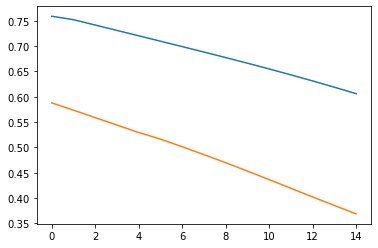

In [104]:
plt.plot([bcorr(numpy.array(all_true[i]), numpy.squeeze(numpy.array(all_fcst[i]))) for i, lead_time in enumerate(range(0, 15))])
plt.plot([bcorr(numpy.array(all_true_ssa[i]), numpy.squeeze(numpy.array(all_fcst_ssa[i]))) for i, lead_time in enumerate(range(0, 15))])

In [115]:
for i, lead_time in enumerate(range(0, 45)):
    print(bcorr(numpy.array(all_true[i]), numpy.squeeze(numpy.array(all_fcst[i]))))
    #print(numpy.sqrt(numpy.mean((numpy.array(all_true[i]) - numpy.array(all_fcst[i]))**2)))

0.7588601093546569


IndexError: list index out of range

In [21]:
def bcorr(true, fcst):
    return sum(true[:, 0]*fcst[:, 0] + true[:, 1]*fcst[:, 1])/(numpy.sqrt(sum(true[:, 0]**2 + true[:, 1]**2))*numpy.sqrt(sum(fcst[:, 0]**2 + fcst[:, 1]**2)))

In [6]:
import geopandas
from shapely.geometry import Point
import glob

In [ ]:
# From https://www.igismap.com/download-india-boundary-shapefile-free-states-boundary-assembly-constituencies-village-boundaries/
states = geopandas.read_file("Indian_States.shp")

In [29]:
regions_dict = {'Chhattisgarh': 'Central', 'Madhya Pradesh': 'Central', 'Bihar': 'East', 'Jharkhand': 'East', 'Odisha': 'East', 'West Bengal': 'East', 'Andaman & Nicobar Island': 'East', 'NCT of Delhi': 'North', 'Haryana': 'North', 'Himachal Pradesh': 'North', 'Jammu & Kashmir': 'North', 'Punjab': 'North', 'Rajasthan': 'North', 'Uttarakhand': 'North', 'Uttar Pradesh': 'North', 'Chandigarh': 'North', 'Arunanchal Pradesh': 'Northeast', 'Assam': 'Northeast', 'Manipur': 'Northeast', 'Meghalaya': 'Northeast', 'Mizoram': 'Northeast', 'Nagaland': 'Northeast', 'Sikkim': 'Northeast', 'Tripura': 'Northeast', 'Andhra Pradesh': 'South', 'Karnataka': 'South', 'Kerala': 'South', 'Tamil Nadu': 'South', 'Telangana': 'South', 'Puducherry': 'South', 'Goa': 'West', 'Gujarat': 'West', 'Maharashtra': 'West', 'Dadara & Nagar Havelli': 'West'}

In [ ]:
regions_dict_new = {'Chhattisgarh': 'Central', 'Madhya Pradesh': 'Central', 'Bihar': 'East', 'Jharkhand': 'East', 'Odisha': 'East', 'West Bengal': 'East', 'Andaman & Nicobar Island': 'East', 'NCT of Delhi': 'North', 'Haryana': 'North', 'Himachal Pradesh': 'North', 'Jammu & Kashmir': 'North', 'Punjab': 'North', 'Rajasthan': 'North', 'Uttarakhand': 'North', 'Uttar Pradesh': 'North', 'Chandigarh': 'North', 'Arunanchal Pradesh': 'Northeast', 'Assam': 'Northeast', 'Manipur': 'Northeast', 'Meghalaya': 'Northeast', 'Mizoram': 'Northeast', 'Nagaland': 'Northeast', 'Sikkim': 'Northeast', 'Tripura': 'Northeast', 'Andhra Pradesh': 'South', 'Karnataka': 'South', 'Kerala': 'South', 'Tamil Nadu': 'South', 'Telangana': 'South', 'Puducherry': 'South', 'Goa': 'West', 'Gujarat': 'West', 'Maharashtra': 'West', 'Dadara & Nagar Havelli': 'West'}

In [10]:
lowres_lons, lowres_lats = numpy.meshgrid(seas5_anomalies.lon, seas5_anomalies.lat)

In [13]:
points = list(map(Point, zip(lowres_lons[mask_lowres], lowres_lats[mask_lowres])))

In [14]:
df = geopandas.GeoDataFrame(geometry=points)
df.crs = {'init': 'epsg:4326'}

/home/ebach/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [33]:
state_data = geopandas.sjoin(df, states, how="left", op="intersects")

/home/ebach/miniconda3/envs/enoc/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_55353/126525070.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  state_data = geopandas.sjoin(df, states, how="left", op="intersects")


In [34]:
state_data["st_nm"] = state_data["st_nm"].apply(lambda x: regions_dict[x] if isinstance(x, str) else float('nan'))

In [7]:
import pandas

In [8]:
region_data = pandas.read_hdf('data/homo_regions.h5')

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


dat = state_data["st_nm"].copy()
dat[dat == 'South'] = 0
dat[dat == 'North'] = 1
dat[dat == 'East'] = 2
dat[dat == 'West'] = 3
dat[dat == 'Northeast'] = 4
dat[dat == 'Central'] = 5
m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.contourf(lowres_lons, lowres_lats, m, cmap='Pastel2')
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'South'])-1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'South']), 'South',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'North']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'North']), 'North',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'East']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'East']), 'East',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'West'])+1,
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'West'])-1.5, 'West',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][state_data["st_nm"] == 'Central']),
         numpy.mean(lowres_lats[mask_lowres][state_data["st_nm"] == 'Central']-0.2), 'Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
#plt.savefig("india_regions.pdf")

NameError: name 'state_data' is not defined

Text(73.36842, 25.817545, 'Northwest')

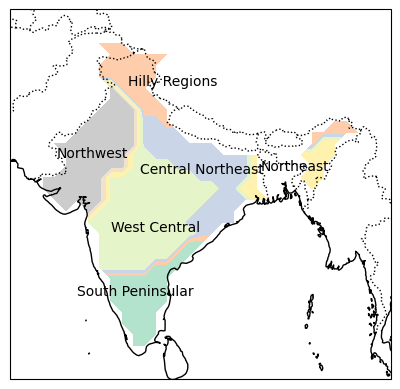

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


dat = region_data.copy()
dat[dat == 'South_Peninsular'] = 0
dat[dat == 'Hilly_Regions'] = 1
dat[dat == 'Central_Northeast'] = 2
dat[dat == 'West_Central'] = 3
dat[dat == 'Northeast'] = 4
dat[dat == 'Northwest'] = 5
m = numpy.zeros(lowres_lons.shape)*numpy.nan
m[mask_lowres] = dat
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.contourf(lowres_lons, lowres_lats, m, cmap='Pastel2')
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'South_Peninsular'])-1,
         numpy.mean(lowres_lats[mask_lowres][region_data == 'South_Peninsular']), 'South Peninsular',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'Hilly_Regions']),
         numpy.mean(lowres_lats[mask_lowres][region_data == 'Hilly_Regions']), 'Hilly Regions',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'Central_Northeast']),
         numpy.mean(lowres_lats[mask_lowres][region_data == 'Central_Northeast']), 'Central Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'West_Central'])+1,
         numpy.mean(lowres_lats[mask_lowres][region_data == 'West_Central'])-1.5, 'West Central',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'Northeast']),
         numpy.mean(lowres_lats[mask_lowres][region_data == 'Northeast']), 'Northeast',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
plt.text(numpy.mean(lowres_lons[mask_lowres][region_data == 'Northwest']),
         numpy.mean(lowres_lats[mask_lowres][region_data == 'Northwest']-0.2), 'Northwest',
         horizontalalignment='center',
         transform=ccrs.PlateCarree())
#plt.savefig("india_regions.pdf")

In [ ]:
all_errs = []
for month in range(5):
    errs = []
    for lead in range(len(maps2_all[month])):
        region_errs = []
        for region in ['South', 'North', 'East', 'West', 'Northeast', 'Central']:
            region_errs.append(numpy.mean((numpy.mean(maps2_all[month][lead], axis=0))[mask][state_data["st_nm"] == region]))
        errs.append(region_errs)
    all_errs.append(errs)

In [35]:
era5_verify_anomalies

<xarray.DataArray 'tp' (time: 19710, lat: 34, lon: 35)>
[23454900 values with dtype=float32]
Coordinates:
  * lat        (lat) float32 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * time       (time) datetime64[ns] 1950-03-01 1950-03-02 ... 2021-09-01
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
    dayofyear  (time) object '03-01' '03-02' '03-03' ... '08-30' '08-31' '09-01'

In [37]:
state_data["st_nm"] == 'South'

0       True
1       True
2      False
3       True
4       True
       ...  
311    False
312    False
313    False
314    False
315    False
Name: st_nm, Length: 316, dtype: bool

In [41]:
mask_lowres

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [27]:
era5_masked[:, state_data["st_nm"] == 'South']

array([[ 5.13894200e-01,  3.68561506e-01,  5.08222163e-01, ...,
        -5.34292102e-01,  2.16351077e-01, -4.80401032e-02],
       [-4.71711159e-03,  7.43267000e-01, -2.27212161e-01, ...,
        -2.83380866e-01,  1.23478985e+01,  1.02284393e+01],
       [-2.29959989e+00, -4.23853397e-01, -8.12742949e-01, ...,
        -4.30182010e-01,  1.25578451e+00,  4.27457601e-01],
       ...,
       [-5.61537743e-01,  6.68904185e-01,  1.76081657e-01, ...,
        -1.34918213e-01,  7.37644863e+00, -3.09479523e+00],
       [-4.74645519e+00,  4.24977541e-01, -6.60417938e+00, ...,
         3.10200644e+00, -9.76146984e+00, -8.76102829e+00],
       [-6.01290321e+00, -7.33791947e-01, -7.98015833e+00, ...,
        -7.42911911e+00, -1.08191442e+01, -6.10155296e+00]], dtype=float32)

In [31]:
seas5_masked[:, :, :, state_data["st_nm"] == 'South']

array([[[[-1.94454479e+00, -3.33175087e+00,  5.70038319e+00, ...,
          -3.75474524e+00, -4.97116119e-01, -7.11288393e-01],
         [-3.47937584e+00, -2.95611095e+00, -3.56910801e+00, ...,
          -3.78293324e+00, -1.94300309e-01, -3.33185852e-01],
         [-2.98430443e+00, -1.75012183e+00, -9.08167458e+00, ...,
          -3.45904541e+00, -2.38576263e-01, -2.32818604e-01],
         ...,
         [-5.17757225e+00, -4.54264402e-01,  3.14779282e-01, ...,
          -6.62207031e+00, -5.74414062e+00, -5.51448536e+00],
         [-5.31022215e+00, -1.44840503e+00,  1.04443312e+00, ...,
          -1.02897167e+00, -5.58658886e+00, -5.87613964e+00],
         [-2.79703712e+00, -1.19514966e+00, -3.69856882e+00, ...,
           9.05762196e-01, -5.32649708e+00, -5.22200489e+00]],

        [[-5.05950451e+00, -8.08497012e-01, -5.94599342e+00, ...,
          -3.44083166e+00, -1.25661206e+00, -1.08281446e+00],
         [-5.96404457e+00, -5.54306030e-01, -4.15914059e+00, ...,
          -2.75265026e

In [ ]:
seas5_anomalies.values[:, :, :, mask_lowres].shape

In [ ]:
seas5_anomalies.values[:, mask_lowres][:, state_data["st_nm"] == 'South']

In [2]:
import sklearn.linear_model
import pickle

In [43]:
clf_lasso = pickle.load(open('clf_lasso', 'rb'))
scaler_past_lasso = pickle.load(open('scaler_past_lasso', 'rb'))

In [8]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [16]:
jl.eval('include("ssa.jl"); using .SSA')

In [17]:
reconstruct_ssa = jl.eval("SSA.reconstruct_past")

In [42]:
eig_vecs = xarray.open_dataset('eig_vecs.h5')["eig_vecs"].values[:2, :].T

In [48]:
eofs = xarray.open_dataset('eofs.h5')["eofs"].values.T

In [69]:
M = 61
r = reconstruct_ssa(initial_data, M, eig_vecs, [1, 2])

In [71]:
numpy.sum(r, axis=0)@eofs

array([-0.0543628 , -0.05651375], dtype=float32)

In [39]:
eig_vecs[:, :2]

array([[-0.00083468, -0.00097283],
       [ 0.00072988,  0.00065569],
       [ 0.00096385,  0.00099406],
       ...,
       [-0.00026309,  0.00010586],
       [-0.00019949, -0.00444323],
       [ 0.00066711, -0.00094489]], dtype=float32)

In [67]:
initial_date = datetime.datetime(year=1901, month=4, day=30)

In [68]:
initial_data = numpy.array([imd_regress_anomalies.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-M + 1, 1)])

In [37]:
initial_data.shape

(61, 4964)

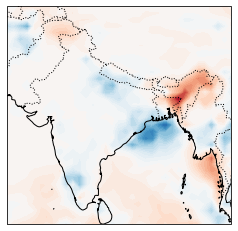

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.contourf(seas5_anomalies.lon, seas5_anomalies.lat,
            seas5_anomalies.isel(initial_time=0, ensemble=4, forecast_time=range(7)).mean('forecast_time'), 50,
            cmap='RdBu', vmin=-20, vmax=20, transform=ccrs.PlateCarree())
#plt.colorbar()

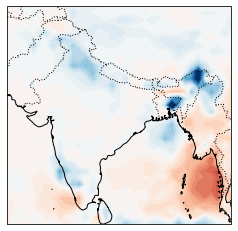

In [75]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.contourf(seas5_anomalies.lon, seas5_anomalies.lat,
            seas5_anomalies.isel(initial_time=0, ensemble=4, forecast_time=range(7, 14)).mean('forecast_time'), 50,
            cmap='RdBu', vmin=-20, vmax=20, transform=ccrs.PlateCarree())
#plt.colorbar()

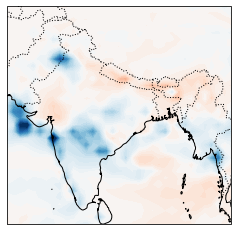

In [238]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.contourf(seas5_anomalies.lon, seas5_anomalies.lat,
            seas5_anomalies.isel(initial_time=42, ensemble=5, forecast_time=range(20, 30)).mean('forecast_time'), 50,
            cmap='RdBu', vmin=-40, vmax=40, transform=ccrs.PlateCarree())
#plt.colorbar()

(-1.4500000000000002, 30.45, -3.5589258074760437, 4.136743485927582)

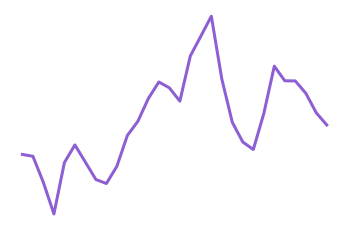

In [292]:
#fig = plt.figure(figsize=(15, 3))
ax = plt.gca()
ax.plot(seas5_anomalies.isel(initial_time=42, ensemble=5, forecast_time=range(0, 30)).mean(['lat', 'lon']), linewidth=3, c='#8d5fd3ff')
ax.axis('off')

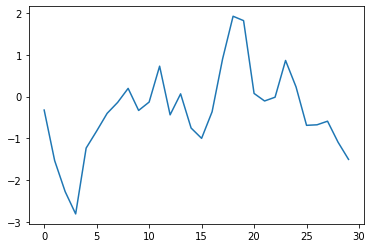

In [219]:
plt.plot(seas5_anomalies.isel(initial_time=42, ensemble=0, forecast_time=range(0, 30)).mean(['lat', 'lon']))

In [100]:
r = xarray.open_dataarray('r_summed.h5')

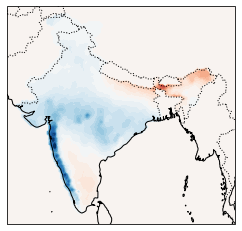

In [229]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

arr = numpy.zeros(mask.shape)
arr[mask] = r[88, :, 61*2+25].values

ax.contourf(numpy.arange(66.5, 100.25, 0.25), numpy.arange(6.5, 38.75, 0.25),
            arr*10, 50, vmin=-80, vmax=80,
            cmap='RdBu', transform=ccrs.PlateCarree())

(-1.4500000000000002, 30.45, -1.0204155296087265, 0.7934101074934006)

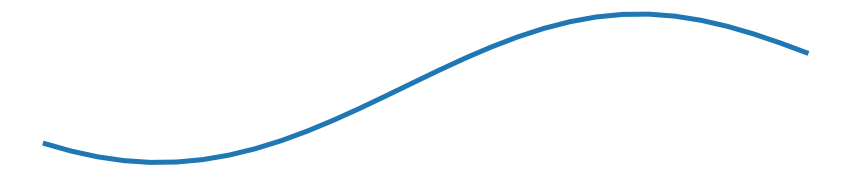

In [244]:
fig = plt.figure(figsize=(15, 3))
ax = plt.gca()
ax.plot(r[88, :, 61*2:61*2+30].mean(axis=0), linewidth=5)
ax.axis('off')

In [203]:
1901+87

1988

In [251]:
seas5_anomalies.isel(initial_time=42).initial_time

<xarray.DataArray 'initial_time' ()>
array('1989-07-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    initial_time  datetime64[ns] 1989-07-01
    dayofyear     object '07-01'
Attributes:
    long_name:  initial time

In [283]:
ens = 5
lead_time = 30
initial_date = datetime.datetime(year=1989, month=7, day=1)
data_ens = [(seas5_anomalies.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values).ravel() for i in range(lead_time - half_regress_days, lead_time + half_regress_days + 1)]
pcs_model = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

In [281]:
numpy.mean((pcs_model - pcs2[1989 - 1901, 61*2+30, :])**2)

0.81434023

In [284]:
numpy.mean((pcs_model - pcs2[1989 - 1901, 61*2+30, :])**2)

1.9878073

In [273]:
pcs2[1989 - 1901, 61*2+30, :]

array([-0.1386652,  1.2343704], dtype=float32)

0.2486503125633211
0.5865811390595952
0.773906778066184


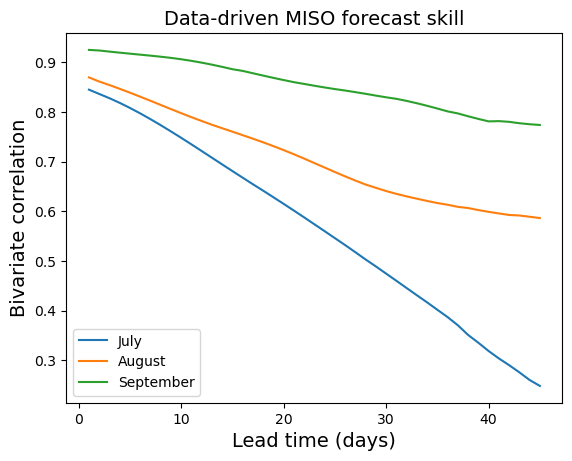

In [23]:
for i, month in enumerate(range(7, 10)):
    bcorrs = [bcorr(numpy.array([all_pcs[month][l][y][0] for y in range(9)]), numpy.array([all_pcs[month][l][y][1] for y in range(9)]).reshape(9, 2)) for l in range(45)]
    plt.plot(range(1, 46), bcorrs, label=["July", "August", "September"][i%3])
    print(bcorrs[-1])

plt.title("Data-driven MISO forecast skill", fontsize=14)
plt.xlabel("Lead time (days)", fontsize=14)
plt.ylabel("Bivariate correlation", fontsize=14)
plt.legend()
#plt.savefig("miso_dd_skill.pdf")

In [170]:
numpy.argmin(abs(numpy.array(bcorrs) - 0.5))

27

In [677]:
rmses = [rmse2(avg_uncorr[m][l][y], avg_obs[m][l][y]) - rmse2(avg_corr[m][l][y], avg_obs[m][l][y]) for m in range(9, 10) for l in range(7, 38) for y in range(9)]

In [678]:
pc_errs = [numpy.sqrt(numpy.mean((all_pcs[m][l][y][0] - numpy.mean(all_pcs[m][l][y][2], axis=0))**2)) - numpy.sqrt(numpy.mean((all_pcs[m][l][y][0] - all_pcs[m][l][y][1])**2)) for m in range(9, 10) for l in range(7, 38) for y in range(9)]

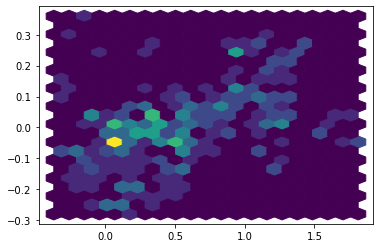

In [679]:
plt.hexbin(pc_errs, rmses, gridsize=20)

In [203]:
import scipy.stats

In [277]:
scipy.stats.pearsonr(pc_errs, rmses)

PearsonRResult(statistic=0.4480237649513209, pvalue=3.5190049765110746e-15)

In [621]:
m = 7
imr = numpy.array([[all_res_obs[m][lead][y][mask_lowres].mean() for lead in range(10, 30)] for y in range(9)])
imr_corr = numpy.array([[all_res_corr[m][lead][y].mean('ensemble').values[mask_lowres].mean() for lead in range(10, 30)] for y in range(9)])
imr_uncorr = numpy.array([[all_res_uncorr[m][lead][y].mean('ensemble').values[mask_lowres].mean() for lead in range(10, 30)] for y in range(9)])

In [622]:
import numpy as np


def find_runs(x, l=3):
    """Find runs of consecutive items in an array."""

    runs = numpy.zeros(x.shape)
    
    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        long_runs = (run_lengths >= l) & run_values
        
        for i, s in enumerate(run_starts[long_runs]):
            runs[s:s+run_lengths[long_runs][i]] = 1

        return runs.astype(bool)

In [623]:
low_thresh, high_thresh = numpy.mean(imr) - numpy.std(imr)/2, numpy.mean(imr) + numpy.std(imr)/2

In [624]:
obs_class = numpy.zeros(20*9)
obs_class[numpy.ravel([find_runs((imr < low_thresh)[y, :]) for y in range(9)])] = 1
obs_class[numpy.ravel([find_runs((imr > high_thresh)[y, :]) for y in range(9)])] = 2

In [625]:
corr_class = numpy.zeros(20*9)
corr_class[numpy.ravel([find_runs((imr_corr < low_thresh)[y, :]) for y in range(9)])] = 1
corr_class[numpy.ravel([find_runs((imr_corr > high_thresh)[y, :]) for y in range(9)])] = 2

In [626]:
uncorr_class = numpy.zeros(20*9)
uncorr_class[numpy.ravel([find_runs((imr_uncorr < low_thresh)[y, :]) for y in range(9)])] = 1
uncorr_class[numpy.ravel([find_runs((imr_uncorr > high_thresh)[y, :]) for y in range(9)])] = 2

In [627]:
obs_class1, corr_class1, uncorr_class1 = obs_class, corr_class, uncorr_class

In [615]:
obs_class2, corr_class2, uncorr_class2 = obs_class, corr_class, uncorr_class

In [628]:
cm_u = confusion_matrix(numpy.hstack([obs_class1, ]), numpy.hstack([uncorr_class1, ]))

In [629]:
cm_c = confusion_matrix(numpy.hstack([obs_class1, ]), numpy.hstack([corr_class1, ]))

In [630]:
from sklearn.metrics import zero_one_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

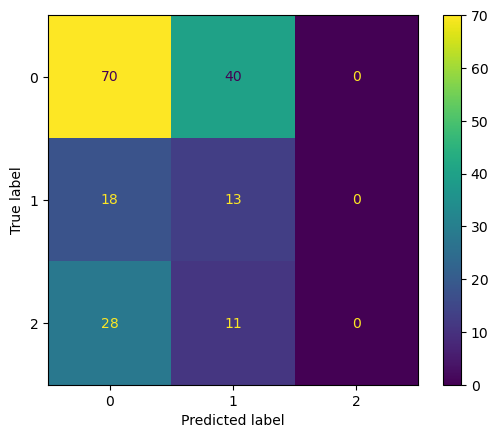

In [631]:
ConfusionMatrixDisplay(cm_u).plot()

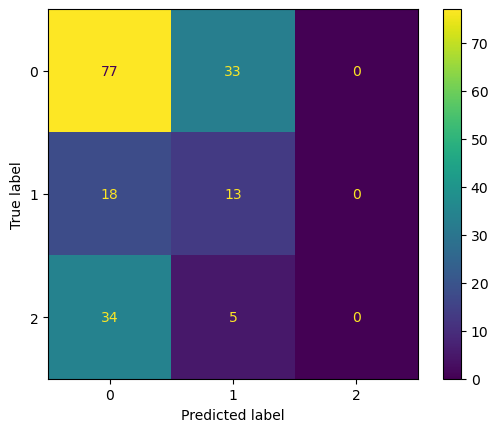

In [632]:
ConfusionMatrixDisplay(cm_c).plot()

In [82]:
sum((imr < low_thresh) == (imr_corr < low_thresh))

193

In [83]:
sum((imr < low_thresh) == (imr_uncorr < low_thresh))

189

In [84]:
sum((imr > high_thresh) == (imr_corr > high_thresh))

195

In [85]:
sum((imr > high_thresh) == (imr_uncorr > high_thresh))

196

In [38]:
for month in range(7, 10):
    for lead_time in range(7, 38):
        means = [avg_uncorr[month][lead_time][y].mean() for y in range(9)]
        print(lead_time, max(means)/numpy.std(means), range(2008,2017)[numpy.argmax(means)])

7 0.9399767 2016
8 0.80347663 2016
9 0.6319046 2016
10 0.31341225 2016
11 0.0055010673 2016
12 -0.07021533 2011
13 -0.32051244 2011
14 -0.3683843 2009
15 -0.27686247 2009
16 0.040707774 2011
17 0.37086666 2011
18 0.55775416 2011
19 0.73788834 2011
20 0.8637864 2011
21 0.9067094 2011
22 0.9738902 2010
23 1.2713767 2010
24 1.4991426 2010
25 1.774403 2010
26 1.9649595 2010
27 2.050936 2010
28 2.0861056 2010
29 2.0471823 2010
30 1.9449991 2010
31 1.8390044 2010
32 1.8541305 2011
33 2.010484 2011
34 2.0683637 2011
35 2.065978 2011
36 2.0629463 2011
37 2.0741303 2011
7 1.311853 2008
8 1.250721 2008
9 1.0664892 2008
10 0.9538094 2008
11 0.9241566 2008
12 1.053553 2011
13 1.1473378 2011
14 1.2203809 2011
15 1.2690157 2011
16 1.2833629 2011
17 1.2989471 2011
18 1.2971853 2011
19 1.1837665 2011
20 1.0887713 2011
21 1.0638402 2011
22 1.0446341 2011
23 1.0192164 2011
24 0.9759471 2011
25 0.88960946 2011
26 0.74992573 2011
27 0.7026582 2012
28 0.82303685 2012
29 0.99454385 2012
30 1.1371019 2012
31

In [36]:
i = 0
for month in range(7, 9):
    tcorr_corr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_corr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]
    tcorr_uncorr = [numpy.corrcoef([y.mean(axis=0).sum() for y in avg_uncorr[month][lead_time]], [y.sum() for y in avg_obs[month][lead_time]])[0, 1] for lead_time in range(9, 30)]

    corr_sum += numpy.arctanh(numpy.array(tcorr_corr))/2
    uncorr_sum += numpy.arctanh(numpy.array(tcorr_uncorr))/2
axs[i].plot(range(10, 31), numpy.tanh(uncorr_sum), label='Uncorrected')
axs[i].plot(range(10, 31), numpy.tanh(corr_sum), label='EnOC')
#axs[i].set_ylim(0.52, 0.87)
axs[i].set_title('Monsoon region', fontsize=14)
axs[i].set_xlabel("Lead time (days)", fontsize=14)


2010

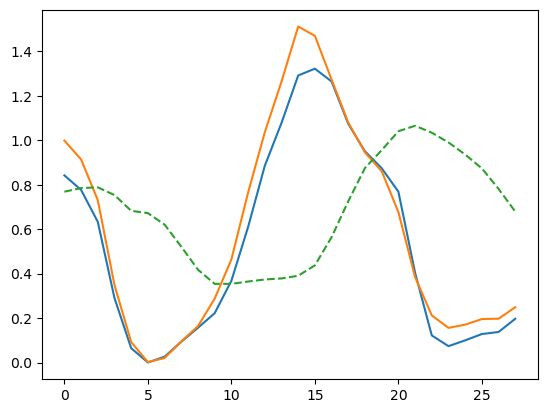

In [131]:
month = 9
year = 4

#plt.plot([numpy.corrcoef(avg_corr[month][i][year].mean(axis=0), avg_obs[month][i][year])[0, 1] for i in range(10, 38)])
#plt.plot([numpy.corrcoef(avg_uncorr[month][i][year].mean(axis=0), avg_obs[month][i][year])[0, 1] for i in range(10, 38)])

clim_error = numpy.var([[avg_obs[month][i][j].mean() for i in range(10, 38)] for j in range(9)], axis=0)
plt.plot([(avg_corr[month][i][year].mean() - avg_obs[month][i][year].mean())**2 for i in range(10, 38)])
plt.plot([(avg_uncorr[month][i][year].mean() - avg_obs[month][i][year].mean())**2 for i in range(10, 38)])
plt.plot(clim_error, '--')
#plt.plot([avg_obs[7][i][2].mean() for i in range(7, 38)])

In [124]:
avg_uncorr[7][7][0].mean(axis=0)

array([[-0.7000925 , -0.6981581 , -0.9121337 , ...,  1.5992165 ,
         1.30064   , -0.02069231],
       [-1.0037407 , -1.209066  , -1.3943928 , ...,  0.87977976,
        -0.23454385,  0.58637416],
       [-1.4775659 , -1.8003932 , -1.5811658 , ..., -1.7699596 ,
        -1.3422986 ,  1.4365016 ],
       ...,
       [-0.0107449 ,  0.01288792,  0.02185601, ..., -0.01214742,
         0.3541911 , -0.3922608 ],
       [-0.03056912, -0.10319553, -0.03198783, ..., -0.02914764,
         0.40926665, -0.43546814],
       [ 0.00273167, -0.1411811 , -1.170288  , ..., -0.88761413,
        -1.2793726 , -0.5559814 ]], dtype=float32)